# E10s/Multi testing for Beta 54 week 1

(This covers data from 2017-04-30 to 2017-05-07)

## **NOTE: At the moment, Mac and Linux sample sizes are quite small as the cohorts still populate. Results for these OS's should not be used.**

Jump down the results section, or a specific probe within the results section:

*Each probe is broken down by OS (Darwin, Linux, Windows)*

# ** [Results](#Results) **

##  [Jank](#Jank-)

* [GC_MAX_PAUSE_MS](#GC_MAX_PAUSE_MS)
* [CYCLE_COLLECTOR_MAX_PAUSE](#CYCLE_COLLECTOR_MAX_PAUSE)
* [INPUT_EVENT_RESPONSE_MS](#INPUT_EVENT_RESPONSE_MS)

## [Memory Usage](#MemoryUsage)
* [MEMORY_TOTAL](#MEMORY_TOTAL)
* [MEMORY_VSIZE_MAX_CONTIGUOUS](#MEMORY_VSIZE_MAX_CONTIGUOUS)
* [MEMORY_DISTRIBUTION_AMONG_CONTENT](#MEMORY_DISTRIBUTION_AMONG_CONTENT)

# [Tab Switching](#TabSwitching)
* [FX_TAB_SWITCH_TOTAL_MS](#FX_TAB_SWITCH_TOTAL_MS)
* [FX_TAB_SWITCH_UPDATE_MS](#FX_TAB_SWITCH_UPDATE_MS)
* [FX_TAB_SWITCH_SPINNER_VISIBLE_MS](#FX_TAB_SWITCH_SPINNER_VISIBLE_MS)
* [FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS](#FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS)
* [FX_TAB_REMOTE_NAVIGATION_DELAY_MS](#FX_TAB_REMOTE_NAVIGATION_DELAY_MS )

# [Slow Scripts](#SlowScripts)
* [SLOW_SCRIPT_NOTICE_COUNT](#SLOW_SCRIPT_NOTICE_COUNT)
* [SLOW_SCRIPT_PAGE_COUNT](#SLOW_SCRIPT_PAGE_COUNT)
* [SLOW_SCRIPT_NOTIFY_DELAY](#SLOW_SCRIPT_NOTIFY_DELAY)


   






In [102]:
from __future__ import division

import ujson as json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#from colour import Color
import math
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
import pyspark.sql.types as st
from pyspark.sql import Row
from collections import Counter, defaultdict

from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

IPython.core.pylabtools.figsize(16, 7)
sns.set_style('whitegrid')
sc.setLogLevel('INFO')

from operator import add
pd.set_option("display.max_rows", None)

def get_active_addon_info(addons_str):
    """ Return a list of currently enabled add-ons in the form (GUID, name, version, isSystem). """
    addons = json.loads(addons_str)
    addons = addons.get("activeAddons", {})
    if not addons:
        return []
    return [(guid, meta.get("name"), meta.get("isSystem"), meta.get('isWebExtension'), meta.get('version')) for guid, meta in addons.iteritems()]

def get_top_addons(df, cohort_filter, n_top=100):
    cohort_num, cohort_table = dataset_installed_addons(
        df.filter(cohort_filter),
        n_top=n_top)
    print("There were {:,} distinct add-ons installed across the '{}' cohort."\
          .format(cohort_num, cohort_filter))

    cohort_table["n_installs"] = cohort_table["n_installs"]
    cohort_table["pct_installed"] = cohort_table["pct_installed"]
    return cohort_table


def dataset_installed_addons(data, n_top=100):
    """ Extract add-on info from a subset of the main dataset, and generate a table of top add-ons
        with installation counts.
        
        Returns a Pandas DataFrame.
    """
    data_addons = data.select("addons").rdd.map(lambda row: row["addons"])
    data_addons.cache()
    n_in_data = data_addons.count()
    
    ##  Get counts by add-on ID/name/isSystem value.
    addon_counts = data_addons.flatMap(get_active_addon_info)\
        .map(lambda a: (a, 1))\
        .reduceByKey(add)\
        .map(lambda ((guid, name, sys, we, version), n): (guid, (name, sys, version, n)))
    
    ## Summarize using the most common name and isSystem value.
    top_vals = addon_counts.reduceByKey(lambda a, b: a if a[-1] > b[-1] else b)\
        .map(lambda (guid, (name, sys, we, version, n)): (guid, (name, sys, version)))
    n_installs = addon_counts.mapValues(lambda (name, sys, version, we, n): n)\
        .reduceByKey(add)
    addon_info = top_vals.join(n_installs)\
        .map(lambda (guid, ((name, sys, we, version), n)): {
                "guid": guid,
                "name": name,
                "is_system": sys,
                "is_webextension": we,
                "version":version,
                "n_installs": n,
                "pct_installed": n / n_in_data * 100
            })\
        .sortBy(lambda info: info["n_installs"], ascending=False)
    
    addon_info_coll = addon_info.collect() if not n_top else addon_info.take(n_top)
    addon_info_table = pd.DataFrame(addon_info_coll)
    addon_info_table = addon_info_table[["guid", "name", "version","is_system", "is_webextension", "n_installs", "pct_installed"]]
    ## Number rows from 1.
    addon_info_table.index += 1
    n_addons = addon_info.count()
    data_addons.unpersist()
    return (n_addons, addon_info_table)

def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    """ The comparison metric for histograms. """
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def median(lst, n):
    # take average of middle two numbers if even
    cut = int(np.ceil(n/2))
    return (lst[cut-1] + lst[cut]) / 2 if n % 2 == 0 else lst[cut-1]

def make_group_histogram(group_data):
    """ Combine separate client histograms into a single group histogram, normalizing bin counts
        to relative frequencies.       
    """
    N = len(group_data)
    def median(lst, n):
        # take average of middle two numbers if even
        cut = int(np.ceil(n/2))
        return (lst[cut-1] + lst[cut]) / 2 if n % 2 == 0 else lst[cut-1]
            
    ## Check for histograms with 0 counts.
    client_totals = group_data.map(lambda x: x.sum())
    group_data = group_data[client_totals > 0]
    raw_counts = group_data.sum()
    
    # compute median 
    n = raw_counts.sum()
    acc = -0.001
    curr_dec = 0
    deciles = []
    dec = 0
    for i, j in raw_counts.iteritems():
        acc += j
        while acc >= curr_dec:
            deciles.append(i)
            dec+=.1
            curr_dec = n*dec
                
    ## Convert frequency counts to relative frequency for each client histogram.
    group_data = group_data.map(lambda x: x/x.sum())
    ## Merge the group's client histograms by adding up the frequencies over all clients
    ## in the group, separately for each bin.
    group_data = group_data.sum()
    ## Convert the merged bin frequencies to relative percentages.
    group_data= 100 * group_data / group_data.sum()
    return group_data, deciles, N
    

def compare_histogram(histogram, webext_multi_1, webext_multi_4, multi_1=None, multi_4=None,
                      include_diff=True, include_diff_in_diff=True, did_separate_plot=True):
    """ Compare an e10s histogram to a non-e10s one, and graph the results.
        
        Plots the two histograms overlaid on the same graph, and prints a p-value
        for testing whether they are different. If 'include_diff' is True, also
        draw a plot of the frequency differences for each bin.
        
        If 'include_diff_in_diff' is True and data is supplied, include a plot of
        differences between addon cohort differences and non-addon cohort differences.
    """
    multi_1_total, dec1, n1 = make_group_histogram(webext_multi_1)
    multi_4_total, dec4, n4 = make_group_histogram(webext_multi_4)

    
    if include_diff:
        if include_diff_in_diff and did_separate_plot:
            fig, (ax, diff_ax, diff_diff_ax) = plt.subplots(3, sharex=True, figsize=(16,10), 
                                                            gridspec_kw={"height_ratios": [2,2,1]})
        else:
            fig, (ax, diff_ax) = plt.subplots(2, sharex=True)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    fig.subplots_adjust(hspace=0.3)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(multi_1_total.max(), multi_4_total.max())
        
    multi_1_total.plot(kind="bar", alpha=0.5, color="green", label="Multi 1", ax=ax, width=width,
                position=0, ylim=(0, ylim + 1))
    multi_4_total.plot(kind="bar", alpha=0.5, color="blue", label="Multi 4", ax=ax2, width=width,
                position=1, grid=False, ylim=ax.get_ylim())
    
    ## Combine legend info from both Axes.
    ax_h, ax_l = ax.get_legend_handles_labels()
    ax2_h, ax2_l = ax2.get_legend_handles_labels()
    ax.legend(ax_h + ax2_h, ax_l + ax2_l, loc = 0)
 
    plt.title(histogram)
    ax.xaxis.grid(False)
    ax.set_ylabel("Frequency %")

    if include_diff:
        ## Add a second barplot of the difference in frequency for each bucket.
        #diff_ax = fig.add_subplot(2, 1, 2)
        enDiff = multi_1_total - multi_4_total
        
        has_diff_in_diff_data = (multi_1 is not None and len(multi_1) > 0 and
                                 multi_4 is not None and len(multi_4) > 0)
        if include_diff_in_diff and has_diff_in_diff_data:
            ## Add bin differences for between e10s/non-e10s for the no-addons cohorts.
            ## The assumption is that the difference between addons cohorts would look the same
            ## if there is no additional effect of having addons.
            multi_1_total_std, dec_std1, n1_std = make_group_histogram(multi_1)
            multi_4_total_std, dec_std4, n4_std = make_group_histogram(multi_4)
            enDiff_std = multi_1_total_std - multi_4_total_std
            ylims = (min(enDiff.min(), enDiff_std.min()) - 0.5, max(enDiff.max(), enDiff_std.max()) + 0.5)
            diff_ax2 = diff_ax.twinx()
            
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="WebExtensions", ax=diff_ax, width=width,
                        position=1, ylim=ylims)
            enDiff_std.plot(kind="bar", alpha=0.5, color="gray", label="no WebExtensions", ax=diff_ax2, width=width,
                        position=0, grid=False, ylim=diff_ax.get_ylim())

            ## Combine legend info from both Axes.
            diff_ax_h, diff_ax_l = diff_ax.get_legend_handles_labels()
            diff_ax2_h, diff_ax2_l = diff_ax2.get_legend_handles_labels()
            leg_h = diff_ax_h + diff_ax2_h
            leg_l = diff_ax_l + diff_ax2_l
            
            if did_separate_plot:
                enDiffDiff = enDiff - enDiff_std
                enDiffDiff.plot(kind="bar", alpha=0.5, color="maroon", ax=diff_diff_ax, ylim=diff_ax.get_ylim())
                diff_diff_ax.xaxis.grid(False)
                diff_diff_ax.set_ylabel("Diff in freq %")
                diff_diff_ax.set_title("Diff between multi 1/4 with webextensions and multi 1/4 diff without webextensions" +
                                      " (with webextensions higher when > 0)")
            
        else:
            if include_diff_in_diff:
                ## We wanted to do the additional comparison, but there wasn't enough data.
                print("\nNo diff-in-diff comparison: one of the standard cohorts has no non-missing observations.")
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="WebExtensions", ax=diff_ax)
            leg_h, leg_l = diff_ax.get_legend_handles_labels()
        
        plt.title("multi1/multi4 difference (more multi1 in bucket when > 0)")
        diff_ax.xaxis.grid(False)
        diff_ax.set_ylabel("Diff in frequency %")
        diff_ax.legend(leg_h, leg_l, loc = 0)
    
    
    # Only display at most 100 tick labels on the x axis.
    xticklabs = plt.gca().get_xticklabels()
    max_x_ticks = 100
    if len(xticklabs) > max_x_ticks:
        step_size = math.ceil(float(len(xticklabs)) / max_x_ticks)
        for i, tl in enumerate(xticklabs):
            if i % step_size != 0:
                tl.set_visible(False)
    plt.show()
    
    ## Compute a p-value for the chi-square distance between the groups' combined histograms.
    pvalue = grouped_permutation_test(chi2_distance, [webext_multi_1, webext_multi_4], num_samples=100)
    print("The probability that the distributions for {} (with webextensions)\nare differing by chance is {:.3f}."\
          .format(histogram, pvalue))
    
    ret = {
            "dec_1": dec1,
            "dec_4": dec4,
            "n_1": n1,
            "n_4": n4,
            "pvalue_14": pvalue
          }
        
           
    if include_diff_in_diff:
        pvalue_std = grouped_permutation_test(chi2_distance, [multi_1, multi_4], num_samples=1000)
        print("The probability that the distributions for {} (without webextensions)\nare differing by chance is {:.3f}."\
          .format(histogram, pvalue_std))
        ret['dec_1_std'] = dec_std1
        ret['dec_4_std'] = dec_std4
        ret['n_1_std'] = n1_std
        ret['n_4_std'] = n4_std
        ret['pvalue_14_std'] = pvalue_std
    return ret

def normalize_uptime_hour(frame):
    """ Convert metrics to rates per hour of uptime. """
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    removed_os = False
    os = None
    try:
        os = frame["system/os/name"]
        frame = frame.drop("system/os/name", axis=1)
        removed_os = True
    except:
        pass
    
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    if removed_os:
        frame["system/os/name"] = os
    return frame
    
def compare_e10s_count_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple count histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Treats count histograms as scalars for comparison purposes, without distinguishing between
        parent and child processes. Expects a dict containing overall cohort sizes
        for computing sample size proportions.
    """
    properties = histogram_names + ("payload/simpleMeasurements/totalTime", "cohort", "system/os/name")
    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())
    
    ret = defaultdict(dict)
    for os in np.unique(frame['system/os/name']):
        print_with_markdown("---")
        print_with_markdown("# {}".format(os))
        frame_os = frame[frame['system/os/name'] == os]
        # multi with webextensions
        we_multi1 = normalize_uptime_hour(
                frame_os[frame_os.cohort=="webextensions-multiBucket1"].drop("cohort",axis=1))
        we_multi4 = normalize_uptime_hour(
            frame_os[frame_os.cohort=="webextensions-multiBucket4"].drop("cohort", axis=1))

    
        include_diff_in_diff = kwargs.get("include_diff_in_diff", True)
        if include_diff_in_diff:
            multi1 = normalize_uptime_hour(frame_os[frame_os.cohort=="multiBucket1"].drop("cohort", axis=1))
            multi4 = normalize_uptime_hour(frame_os[frame_os.cohort=="multiBucket4"].drop("cohort", axis=1))     

        for histogram in histogram_names:
            if histogram not in multi1.columns:
                continue

            ## Remove the property path from the histogram name for display purposes.
            hist_name = hist_base_name(histogram)
            if type(hist_name) == list:
                ## Key was given for keyed histogram.
                hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
                hist_name = hist_name[0]
            else:
                hist_str = hist_name
            ## Print a header for the block of graphs, including a link to the histogram definition.
            print_with_markdown("Comparison for count histogram {} (with add-ons):".format(hist_str))

            we_multi1_hist = we_multi1[[histogram, 'system/os/name']].dropna()
            we_multi4_hist = we_multi4[[histogram, 'system/os/name']].dropna()

            ## Print some information on sample sizes.
            print("{} Multi 4 profiles (with webextenisons) have this histogram.".format(
                    sample_size_str(len(we_multi4_hist), cohort_sizes.get(WEBEXTENSION_MULTI_4))))
            print("{} Multi 1 profiles (with webextensions) have this histogram.".format(
                    sample_size_str(len(we_multi1_hist), cohort_sizes.get(WEBEXTENSION_MULTI_1))))
            ## If either group has no data, nothing more to do.
            if len(we_multi4_hist) == 0 or len(we_multi1_hist) == 0:
                continue

            print("")
            hist_name = histogram.split('/')[-1]
            ret[os][hist_name] =  compare_scalars(hist_name + " per hour", we_multi1_hist, we_multi4_hist,
                            multi1[[histogram, 'system/os/name']].dropna() if include_diff_in_diff else None,
                            multi4[[histogram, 'system/os/name']].dropna() if include_diff_in_diff else None)
    return ret
 
def compare_e10s_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple histograms from a collection of pings, and compare multi1 /
        multi4 + webextenson / no webextension   for each.
    
        Outputs separate comparisons for parent process, child processes, and merged histograms.
        Expects a dict containing overall cohort sizes for computing sample
        size proportions.
    """
    ## Load histogram data from the ping set, separating parent & child processes for e10s.

    has_hist = lambda f, samp, suff: f([bool(samp[i + suff]) for i in ("multi_4", "multi_4", "webext_multi_1", "webext_multi_4")])

    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("cohort", "has_webextension", "system/os/name"), 
                                              with_processes=True)\
        .collect())
    
    ret = defaultdict(dict)
    for os in np.unique(frame['system/os/name']):
        print_with_markdown("# {}".format(os))
        frame_os = frame[frame['system/os/name'] == os]
        # multi with no webextenions
        multi1 = frame_os[frame_os.cohort=="multiBucket1"]
        multi4 = frame_os[frame_os.cohort=="multiBucket4"]
        # multi with webextensions
        we_multi1 = frame_os[frame_os.cohort=="webextensions-multiBucket1"]
        we_multi4 = frame_os[frame_os.cohort=="webextensions-multiBucket4"]

        for histogram in histogram_names:
            if histogram not in we_multi1.columns:
                continue

            ## Remove the property path from the histogram name for display purposes.
            hist_name = hist_base_name(histogram)
            if type(hist_name) == list:
                ## Key was given for keyed histogram.
                hist_str = "{}/{}".format(link_to_histogram(hist_name[0]), hist_name[1])
                hist_name = hist_name[0]
            else:
                hist_str = hist_name
            ## Print a header for the block of graphs, including a link to the histogram definition.
            print_with_markdown("Comparison for {} (with add-ons):".format(hist_str))

            ## Compare main, parent and child histograms
            addons_hist_data = {
                "multi_1_merged": multi1[histogram],
                "multi_4_merged": multi4[histogram],
                "webext_multi_1_merged": we_multi1[histogram],
                "webext_multi_4_merged": we_multi4[histogram],
                "multi_1_parent": multi1[histogram + "_parent"],
                "multi_4_parent": multi4[histogram + "_parent"],
                "webext_multi_1_parent": we_multi1[histogram + "_parent"],
                "webext_multi_4_parent": we_multi4[histogram + "_parent"],
                "multi_1_child": multi1[histogram + "_children"],
                "multi_4_child": multi4[histogram + "_children"],
                "webext_multi_1_child": we_multi1[histogram + "_children"],
                "webext_multi_4_child": we_multi4[histogram + "_children"],

            }
            for htype in addons_hist_data:
                addons_hist_data[htype] = addons_hist_data[htype].dropna()

            ## Print some information on sample sizes.
            sample_sizes = { htype: len(hdata) for htype, hdata in addons_hist_data.iteritems() }
            print("{} multi_1 profiles have this histogram.".format(
                    sample_size_str(sample_sizes["multi_1_merged"], cohort_sizes.get(MULTI_1))))
            print("{} multi_4 profiles have this histogram.".format(
                    sample_size_str(sample_sizes["multi_4_merged"], cohort_sizes.get(MULTI_4))))
            print("{} webext_multi_1 profiles have this histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_1_merged"], cohort_sizes.get(WEBEXTENSION_MULTI_1))))
            print("{} webext_multi_4 profiles have this histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_4_merged"], cohort_sizes.get(WEBEXTENSION_MULTI_4))))

            ## If either group has no data, nothing more to do.
            if not has_hist(any, sample_sizes, "_merged"):
                print "No hists found"
                continue

            print("{} multi_1 profiles have the parent histogram.".format(
                    sample_size_str(sample_sizes["multi_1_parent"], cohort_sizes.get(MULTI_1))))
            print("{} multi_4 profiles have the parent histogram.".format(
                    sample_size_str(sample_sizes["multi_4_parent"], cohort_sizes.get(MULTI_4))))
            print("{} webext_multi_1 profiles have the parent histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_1_parent"], cohort_sizes.get(WEBEXTENSION_MULTI_1))))
            print("{} webextx_multi_4 profiles have the parent histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_4_parent"], cohort_sizes.get(WEBEXTENSION_MULTI_4))))

            print("{} multi_1 profiles have the child histogram.".format(
                    sample_size_str(sample_sizes["multi_1_child"], cohort_sizes.get(MULTI_1))))
            print("{} multi_4 profiles have the child histogram.".format(
                    sample_size_str(sample_sizes["multi_4_child"], cohort_sizes.get(MULTI_4))))
            print("{} webext_multi_1 profiles have the child histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_1_child"], cohort_sizes.get(WEBEXTENSION_MULTI_1))))
            print("{} webextx_multi_4 profiles have the child histogram.".format(
                    sample_size_str(sample_sizes["webext_multi_4_child"], cohort_sizes.get(WEBEXTENSION_MULTI_4))))

            has_parents = has_hist(all, sample_sizes, "_parent")
            has_children = has_hist(all, sample_sizes, "_child")
    
            result = None

            ## Compare merged histograms, groups have either no parents or children
            if has_children and has_parents:
                result = compare_histogram(hist_name + " (merged)", 
                                  addons_hist_data["webext_multi_1_merged"],
                                  addons_hist_data["webext_multi_4_merged"],
                                  addons_hist_data["multi_1_merged"],
                                  addons_hist_data["multi_4_merged"],
                                  **kwargs)
                ret[os][hist_name + " (merged)"] = result

            if has_parents:
                result = compare_histogram(hist_name + " (parent)",
                                  addons_hist_data["webext_multi_1_parent"],
                                  addons_hist_data["webext_multi_4_parent"],
                                  addons_hist_data["multi_1_parent"],
                                  addons_hist_data["multi_4_parent"],
                                  **kwargs)
                ret[os][hist_name + " (parent)"] = result

            if has_children:
                result = compare_histogram(hist_name + " (children)",
                                  addons_hist_data["webext_multi_1_child"],
                                  addons_hist_data["webext_multi_4_child"],
                                  addons_hist_data["multi_1_child"],
                                  addons_hist_data["multi_4_child"],
                                  **kwargs)
                ret[os][hist_name + " (child)"] = result
    return ret

def compare_scalars(metric, we_multi1, we_multi4, multi1=None, multi4=None, unit="units"):
    """ Prints info about the median difference between the groups, together with a p-value
        for testing the difference.
        
        Optionally include a string indicating the units the metric is measured in.
        If data is supplied, also print a comparison for non-addons cohorts.
    """
    def fix_nested_series(series):
        x = np.zeros(len(series.iloc[0]))
        for i in series:
            x += i
        return x
    
    ret = defaultdict(dict)
    col = we_multi1.columns[0]

    we_multi1 = we_multi1.dropna()[col]
    we_multi4 = we_multi4.dropna()[col]
    if len(we_multi1) == 0 or len(we_multi4) == 0:
        print("Cannot run comparison: one of the groups has no non-missing observations.")
        continue
    print("Comparison for {}{} (with webextensions):\n".format(metric, " ({})".format(unit) if unit != "units" else ""))

    if type(we_multi1.iloc[0]) == pd.Series:
        we_multi1 = fix_nested_series(we_multi1)
    if type(we_multi4_s.iloc[0]) == pd.Series:
        we_multi4 = fix_nested_series(we_multi4)    

    we1_n = len(we_multi1[we_multi1 > 0])
    we4_n = len(we_multi4[we_multi4 > 0])

    we1_dec = np.percentile(we_multi1, np.arange(0, 100, 10))
    we4_dec = np.percentile(we_multi4, np.arange(0, 100, 10))


    mdiff = median_diff(we_multi1, we_multi4)

    print("- Median with 1 content process is {:.3g} {} {} median with 4 processes."\
         .format(
            #abs(mdiff),
            mdiff,
            unit,
            #"higher than" if mdiff >= 0 else "lower than"
            "different from"))
    print("- This is a relative difference of {:.1f}%.".format(float(mdiff) / we4_dec[5] * 100))
    print("- Multi 1 group median is {:.4g}, Multi 4 group median is {:.4g}.".format(we1_dec[5], we4_dec[5]))

    pvalue = grouped_permutation_test(median_diff, [we_multi1, we_multi4], num_samples=10000)
    print("\n(with webextensions) The probability of this difference occurring purely by chance is {:.3f}."\
        .format(pvalue))

    mname = col.split("/")[-1] 
    ret = {
                    'dec_1': we1_dec,
                    'dec_4': we4_dec,
                    'n_1': we1_n,
                    'n_4': we4_n,
                    'pvalue_14': pvalue
                }



    if multi1 is not None and multi4 is not None:
        ## Include a comparison between non-addon cohorts.
        multi1_s = multi1.dropna()[col]
        multi4_s = multi4.dropna()[col]
        if len(multi1_s) > 0 and len(multi4_s) > 0:
            if type(multi1_s.iloc[0]) == pd.Series:
                multi1_s = fix_nested_series(multi1_s)
            if type(multi4_s.iloc[0]) == pd.Series:
                multi4_s = fix_nested_series(multi4_s)   

            m1_n = len(multi1_s[multi1_s > 0])
            m4_n= len(multi4_s[multi4_s > 0])

            m1_dec = np.percentile(multi1_s, np.arange(0, 100, 10))
            m4_dec = np.percentile(multi4_s, np.arange(0, 100, 10))
            
            mdiff_std = median_diff(multi1_s, multi4_s)
            print("\nFor cohorts with no webextensions, median with 1 content process is {:.3g} {} ({:.1f}%) {} median with 4 processes"\
                 .format(
                    #abs(mdiff_std),
                    mdiff_std,
                    unit,
                    float(mdiff_std) / m4_dec[5] * 100,
                    #"higher than" if mdiff_std >= 0 else "lower than"
                    "different from"))
            print("- This is a relative difference of {:.1f}%."\
                  .format(float(mdiff_std) / m4_dec[5] * 100))
            print("- Multi 1 group median is {:.4g}, Multi 4 group median is {:.4g}."\
                  .format(m1_dec[5], m4_dec[5]))

            pvalue_std = grouped_permutation_test(median_diff, [multi1_s, multi4_s], num_samples=10000)
            print("\n(without webextensions) The probability of this difference occurring purely by chance is {:.3f}."\
                .format(pvalue_std))

            ret["dec_1_std"] = m1_dec
            ret["dec_4_std"] = m4_dec
            ret["n_1_std"] = m1_n
            ret["n_4_std"] = m4_n
            ret["pvalue_14_std"] = pvalue_std
            
    return ret
                



    
def link_to_histogram(hist_name):
    """ Create a link to the histogram definition in Markdown. """
    return "[{}](https://dxr.mozilla.org/mozilla-central/search?q={}+file%3AHistograms.json&redirect=true)"\
            .format(hist_name, hist_name)

def hist_base_name(path_to_histogram):
    """ Remove any path components from histogram name.
    
        If histogram is specified as a path in the payload, with separator '/',
        remove everything but the last component (the actual name).
        However, if the histogram is keyed, and specified with a key, return
        [histname, key].
    """
    path_to_histogram = path_to_histogram.rsplit("/")
    if len(path_to_histogram) > 1 and path_to_histogram[-3] == "keyedHistograms":
        ## There was a keyedHistogram name and key given.
        return path_to_histogram[-2:]
    return path_to_histogram[-1]

## Hack to render links in code output.
from IPython.display import Markdown, display
def print_with_markdown(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))

def sample_size_str(sample_size, cohort_size=None):
    """ Convert a sample size to a string representation, including a percentage if available. """
    if sample_size == 0:
        return "No"
    if cohort_size:
        if sample_size == cohort_size:
            return "All"
        return "{} ({:.1f}%)".format(sample_size, float(sample_size) / cohort_size * 100)
    return str(sample_size)

def get_cohort_dist(dataset):
    cohort_counts = dataset.groupby("e10sCohort").count().collect()
    dataset_count = sum(map(lambda r: r["count"], cohort_counts))

    def cohort_proportions(r):
        prop = r["count"] * 100.0 / dataset_count
        return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

    print("\nTotal number of clients: {:,}".format(dataset_count))

    d = pd.DataFrame(sorted(map(cohort_proportions, cohort_counts), key = lambda r: r[0]))
    d.columns = ['cohort', 'count', 'pct']
    return d


SyntaxError: 'continue' not properly in loop (<ipython-input-102-8fa1eace3e8c>, line 496)

### Get e10s/non-e10s cohorts for the add-ons experiment

The derived dataset is computed from profiles on Beta 50 who have e10sCohort set. It contains a single record (ping) per client, which is randomly selected from among the client's pings during the date range.

In [2]:
# regenerated data and loaded into telemetry-test-bucket
dataset = sqlContext.read.parquet(
    "s3://telemetry-test-bucket/e10s_experiment_view/multi_webExtensions_beta54_cohorts/v20170430_20170507/")
dataset.printSchema()

root
 |-- clientId: string (nullable = true)
 |-- submission: string (nullable = true)
 |-- psubmission: string (nullable = true)
 |-- e10sCohort: string (nullable = true)
 |-- creationTimestamp: string (nullable = true)
 |-- submissionDate: string (nullable = true)
 |-- documentId: string (nullable = true)
 |-- sampleId: integer (nullable = true)
 |-- buildId: string (nullable = true)
 |-- simpleMeasurements: string (nullable = true)
 |-- settings: string (nullable = true)
 |-- addons: string (nullable = true)
 |-- system: string (nullable = true)
 |-- build: string (nullable = true)
 |-- threadHangStats: string (nullable = true)
 |-- histograms: string (nullable = true)
 |-- keyedHistograms: string (nullable = true)
 |-- childPayloads: string (nullable = true)



How many records are in the overall dataset?

In [3]:
dataset.count()

2801131

What are the cohorts, and how many clients do we have in each cohort?

In [4]:
get_cohort_dist(dataset)


Total number of clients: 2,801,131


cohort   count     pct
0                addons-set49a-test       1   0.00%
1        addons-set50allmpc-control   14274   0.51%
2   addons-set50allmpc-multiBucket1    2164   0.08%
3   addons-set50allmpc-multiBucket2    2184   0.08%
4   addons-set50allmpc-multiBucket4    2130   0.08%
5   addons-set50allmpc-multiBucket8    2120   0.08%
6           addons-set50allmpc-test   85011   3.03%
7     addons-set51alladdons-control       9   0.00%
8        addons-set51alladdons-test      10   0.00%
9             addons-set51set1-test       3   0.00%
10                          control   80805   2.88%
11                     disqualified       7   0.00%
12             disqualified-control  106106   3.79%
13        disqualified-multiBucket1    5515   0.20%
14        disqualified-multiBucket2    5521   0.20%
15        disqualified-multiBucket4    5434   0.19%
16        disqualified-multiBucket8    5437   0.19%
17                disqualified-test  882104  31.49%
18                     multiBucket1  577669  20.62%
19                     multiBucket2  112822   4.03%
20                     multiBucket4  577063  20.60%
21                     multiBucket8  111633   3.99%
22                          optedIn    2435   0.09%
23                         optedOut   14482   0.52%
24             temp-disqualified-ru       1   0.00%
25          temp-qualified-devtools  136089   4.86%
26                             test    3959   0.14%
27                          unknown    2540   0.09%
28               unsupportedChannel      25   0.00%
29       webextensions-multiBucket1   31881   1.14%
30       webextensions-multiBucket4   31697   1.13%

In [5]:
WEBEXTENSION_MULTI_1 = u'webextensions-multiBucket1'
WEBEXTENSION_MULTI_4 = u'webextensions-multiBucket4'
MULTI_1 = u'multiBucket1'
MULTI_4 = u'multiBucket4'

Restrict to pings belonging to the e10s add-ons experiment. Also include the standard e10s test/control for comparison.

In [6]:
webext_exp_dataset = dataset.filter(\
"e10sCohort in ('%s','%s', '%s', '%s')" % (WEBEXTENSION_MULTI_1,
                                           WEBEXTENSION_MULTI_4,
                                           MULTI_1,
                                           MULTI_4))

How many clients are left?

In [7]:
webext_exp_dataset.count()

1218310

We want to make sure that the pings tagged into the cohorts satisfy the basic assumptions of the experiment, as this not guaranteed. All add-ons cohort pings should have active add-ons, and e10s should be enabled if and only if the ping belongs to the test cohort.

In [8]:
def e10s_status_check(settings, addons):
    """ Check whether e10s is enabled, and whether there are add-ons. """
    e10sEnabled = bool(json.loads(settings).get("e10sEnabled"))
    aa = json.loads(addons).get("activeAddons")
    
    # check if all addons (that are non-system) are webextensions
    addon_status_lst = []
    if aa:
        for i in aa:
            if not aa[i].get("isSystem"):
                addon_status_lst.append(aa[i].get('isWebExtension'))
    
    onlyWebExtension = all(addon_status_lst) if len(addon_status_lst) > 0 else False
    
    return Row(
        e10s_enabled = e10sEnabled,
        only_webextension = onlyWebExtension
   )

def bad_ping(cohort, settings, addons):
    """ e10s should be enabled iff the profile is in the test cohort, and profiles should have active add-ons
        if they are in the addons cohorts. 
    """
    check_data = e10s_status_check(settings, addons)
    # must have e10s
    is_bad = not check_data.e10s_enabled
    if cohort.startswith("webextensions"):
        is_bad = is_bad or not check_data.only_webextension
    return is_bad

## Add a Column to the DF with the outcome of the check.
## This will be used to remove any bad rows after examining them.
from pyspark.sql.types import BooleanType

status_check_udf = fun.udf(bad_ping, BooleanType())

webext_exp_dataset_check = webext_exp_dataset.withColumn("badPing",
    status_check_udf(webext_exp_dataset.e10sCohort, 
                     webext_exp_dataset.settings, 
                     webext_exp_dataset.addons))

If there are any bad pings, describe the problems and remove them from the dataset.

In [9]:
webext_exp_dataset_bad = webext_exp_dataset_check.filter("badPing")\
    .select("e10sCohort", "settings", "addons")\
    .rdd

has_bad = not webext_exp_dataset_bad.isEmpty()

In [10]:
if not has_bad:
    print("No issues")
else:
    check_counts = webext_exp_dataset_bad\
        .map(lambda r: (r.e10sCohort, e10s_status_check(r.settings, r.addons)))\
        .countByValue()
    print("Issues:")
    for k, v in check_counts.iteritems():
        print("{}: {}".format(k, v))

Issues:
(u'multiBucket1', Row(e10s_enabled=False, only_webextension=True)): 669
(u'webextensions-multiBucket4', Row(e10s_enabled=False, only_webextension=True)): 440
(u'multiBucket1', Row(e10s_enabled=False, only_webextension=False)): 36202
(u'webextensions-multiBucket4', Row(e10s_enabled=False, only_webextension=False)): 109
(u'webextensions-multiBucket1', Row(e10s_enabled=True, only_webextension=False)): 4899
(u'webextensions-multiBucket1', Row(e10s_enabled=False, only_webextension=True)): 441
(u'multiBucket4', Row(e10s_enabled=False, only_webextension=False)): 36488
(u'webextensions-multiBucket4', Row(e10s_enabled=True, only_webextension=False)): 4854
(u'webextensions-multiBucket1', Row(e10s_enabled=False, only_webextension=False)): 85
(u'multiBucket4', Row(e10s_enabled=False, only_webextension=True)): 655


In [11]:
if has_bad:
    print("\nRemoving these pings from the dataset.")
    webext_exp_dataset = webext_exp_dataset_check.filter("not badPing").drop("badPing")
    print("The dataset now contains {} clients".format(webext_exp_dataset.count()))


Removing these pings from the dataset.
The dataset now contains 1133468 clients


What add-ons are present for the addons cohorts?

In [12]:
def get_active_addon_info(addons_str):
    """ Return a list of currently enabled add-ons in the form (GUID, name, version, isSystem). """
    addons = json.loads(addons_str)
    addons = addons.get("activeAddons", {})
    if not addons:
        return []
    return [(guid, meta.get("name"), meta.get("isSystem"), meta.get("isWebExtension"), 
             meta.get('version')) for guid, meta in addons.iteritems()]


def get_top_addons(df, cohort_filter, n_top=100):
    cohort_num, cohort_table = dataset_installed_addons(
        df.filter(cohort_filter),
        n_top=n_top)
    print("There were {:,} distinct add-ons installed across the '{}' cohort."\
          .format(cohort_num, cohort_filter))

    cohort_table["n_installs"] = cohort_table["n_installs"]
    cohort_table["pct_installed"] = cohort_table["pct_installed"]
    return cohort_table

def dataset_installed_addons(data, n_top=100):
    """ Extract add-on info from a subset of the main dataset, and generate a table of top add-ons
        with installation counts.
        
        Returns a Pandas DataFrame.
    """
    data_addons = data.select("addons").rdd.map(lambda row: row["addons"])
    data_addons.cache()
    n_in_data = data_addons.count()
    
    ##  Get counts by add-on ID/name/isSystem value.
    addon_counts = data_addons.flatMap(get_active_addon_info)\
        .map(lambda a: (a, 1))\
        .reduceByKey(add)\
        .map(lambda ((guid, name, sys, we, version), n): (guid, (name, sys, we, version, n)))
    
    ## Summarize using the most common name and isSystem value.
    top_vals = addon_counts.reduceByKey(lambda a, b: a if a[-1] > b[-1] else b)\
        .map(lambda (guid, (name, sys, we, version, n)): (guid, (name, sys, we, version)))
    n_installs = addon_counts.mapValues(lambda (name, sys, we, version, n): n)\
        .reduceByKey(add)
    addon_info = top_vals.join(n_installs)\
        .map(lambda (guid, ((name, sys, we, version), n)): {
                "guid": guid,
                "name": name,
                "is_system": sys,
                "is_webextension": we,
                "version":version,
                "n_installs": n,
                "pct_installed": n / n_in_data * 100
            })\
        .sortBy(lambda info: info["n_installs"], ascending=False)
    
    addon_info_coll = addon_info.collect() if not n_top else addon_info.take(n_top)
    addon_info_table = pd.DataFrame(addon_info_coll)
    addon_info_table = addon_info_table[["guid", "name", "version","is_system", 
                                         "is_webextension", "n_installs", "pct_installed"]]
    ## Number rows from 1.
    addon_info_table.index += 1
    n_addons = addon_info.count()
    data_addons.unpersist()
    return (n_addons, addon_info_table)

In [13]:
get_top_addons(webext_exp_dataset, "e10sCohort like 'webextensions%'", n_top=10)

There were 453 distinct add-ons installed across the 'e10sCohort like 'webextensions%'' cohort.


guid  \
1                   screenshots@mozilla.org   
2                     aushelper@mozilla.org   
3                     webcompat@mozilla.org   
4                   e10srollout@mozilla.org   
5                     firefox@getpocket.com   
6          shield-recipe-client@mozilla.org   
7                   helper-sig@savefrom.net   
8   mozilla_cc3@internetdownloadmanager.com   
9                             wrc@avast.com   
10                             sp@avast.com   

                                 name   version is_system is_webextension  \
1                 Firefox Screenshots     6.3.0      True           False   
2   Application Update Service Helper       2.0      True           False   
3                          Web Compat       1.1      True           False   
4        Multi-process staged rollout      1.50      True           False   
5                              Pocket     1.0.5      True           False   
6                Shield Recipe Client     1.0.0      True           False   
7                 SaveFrom.net helper      7.31     False            True   
8              IDM Integration Module    6.28.2     False            True   
9               Avast Online Security  12.0.163     False            True   
10                    Avast SafePrice  12.0.163     False            True   

    n_installs  pct_installed  
1        52704      99.912796  
2        52481      99.490047  
3        52312      99.169668  
4        52120      98.805687  
5        52085      98.739336  
6        47555      90.151659  
7        14624      27.723223  
8        14068      26.669194  
9         8291      15.717536  
10        4865       9.222749

What add-ons are present in the standard (non-addons) cohorts, if any?

In [14]:
get_top_addons(webext_exp_dataset, "e10sCohort in ('multiBucket1', 'multiBucket4')", n_top=10)

There were 984 distinct add-ons installed across the 'e10sCohort in ('multiBucket1', 'multiBucket4')' cohort.


guid  \
1                     aushelper@mozilla.org   
2                     webcompat@mozilla.org   
3                   e10srollout@mozilla.org   
4                     firefox@getpocket.com   
5                   screenshots@mozilla.org   
6          shield-recipe-client@mozilla.org   
7     www.facebook.com@services.mozilla.org   
8   mozilla_cc3@internetdownloadmanager.com   
9                   helper-sig@savefrom.net   
10               firefox-hotfix@mozilla.org   

                                 name      version is_system is_webextension  \
1   Application Update Service Helper          2.0      True           False   
2                          Web Compat          1.1      True           False   
3        Multi-process staged rollout         1.50      True           False   
4                              Pocket        1.0.5      True           False   
5                 Firefox Screenshots        6.3.0      True           False   
6                Shield Recipe Client        1.0.0      True           False   
7                            Facebook            2      None            None   
8              IDM Integration Module       6.28.2     False            True   
9                 SaveFrom.net helper         7.31     False            True   
10                     Firefox Hotfix  20170302.01     False           False   

    n_installs  pct_installed  
1      1070607      99.064418  
2      1070136      99.020836  
3      1069574      98.968834  
4      1069472      98.959396  
5      1014798      93.900351  
6       938708      86.859662  
7         3988       0.369014  
8         2385       0.220687  
9         2204       0.203938  
10        2019       0.186820

### Transform Dataframe to RDD of pings

In [15]:
def row_2_ping(row):
    # work around to get "processes" (child payloads) into payload 
    submission = json.loads(row.submission) if row.submission else {}
    processes = submission.get("payload", {}).get("processes", {})
    ping = {
        "payload": {
                    "simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                    "histograms": json.loads(row.histograms) if row.histograms else {},
                    "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                    "childPayloads": json.loads(row.childPayloads) if row.childPayloads else {},
                    "threadHangStats": json.loads(row.threadHangStats) if row.threadHangStats else {},
                    "processes": processes
                    },
       "e10s": True if row.e10sCohort.endswith("test") else False,
       "has_webextension": True if row.e10sCohort.startswith("webextensions") else False,
       "system": json.loads(row.system),
       "cohort": row.e10sCohort
    }
    return ping

def notxp(p):
    os = p.get("system", {}).get("os", {})
    return os["name"] != "Windows_NT" or os["version"] != "5.1"

subset = webext_exp_dataset.rdd.map(row_2_ping).filter(notxp)

In [16]:
def add_gecko_activity(ping):
    try:
        uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    except TypeError:
        uptime = 0
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        try:
            child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        except TypeError:
            return ping
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)

At this point, how many clients are left in each cohort? Key first by cohort.

In [17]:
subset = subset.filter(lambda x: x is not None).map(lambda r: (r["cohort"], r))

cohort_sizes = subset.countByKey()
cohort_sizes

defaultdict(int,
            {u'multiBucket1': 540707,
             u'multiBucket4': 539829,
             u'webextensions-multiBucket1': 26454,
             u'webextensions-multiBucket4': 26287})

Sample from minority groups to generate groups where $n_1 \approx n_2, ..., \approx n_i $

In [18]:
multi_prop1 = cohort_sizes[WEBEXTENSION_MULTI_1] / cohort_sizes[MULTI_1]
multi_prop4 = cohort_sizes[WEBEXTENSION_MULTI_4] / cohort_sizes[MULTI_4]

sampling_props = {
    MULTI_1: multi_prop1,
    MULTI_4: multi_prop4,
    WEBEXTENSION_MULTI_1: 1,
    WEBEXTENSION_MULTI_4: 1  
}
subset = subset.sampleByKey(False, sampling_props).cache()
    
print 'Sampling the following proportions from each group:'
sampling_props

Sampling the following proportions from each group:


{u'multiBucket1': 0.04892483359749365,
 u'multiBucket4': 0.04869504972871039,
 u'webextensions-multiBucket1': 1,
 u'webextensions-multiBucket4': 1}

Now compute the final cohort sizes, and wrap them into the histogram comparison functions.

In [19]:
e10s_addon_cohort_sizes = subset.countByKey()

## Remove the cohort label key from the dataset.
subset = subset.map(lambda r: r[1])

In [20]:
print("Final cohort sizes:")
print(" - multi-1 (no webextensions): {}".format(e10s_addon_cohort_sizes[MULTI_1]))
print(" - multi-4 (no webextensions): {}".format(e10s_addon_cohort_sizes[MULTI_4]))
print(" - multi-1 (webextensions): {}".format(e10s_addon_cohort_sizes[WEBEXTENSION_MULTI_1]))
print(" - multi-4 (webextensions): {}".format(e10s_addon_cohort_sizes[WEBEXTENSION_MULTI_4]))

def compare_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)
    
def compare_count_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_count_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)

Final cohort sizes:
 - multi-1 (no webextensions): 26661
 - multi-4 (no webextensions): 26252
 - multi-1 (webextensions): 26454
 - multi-4 (webextensions): 26287


In [21]:
def fix_hist(ping):
    """ Rename the histogram for e10s profiles. """
    hist = ping.get("payload", {}).get("histograms", {})
    if "FX_TAB_SWITCH_TOTAL_E10S_MS" in hist and "FX_TAB_SWITCH_TOTAL_MS" not in hist:
        hist["FX_TAB_SWITCH_TOTAL_MS"] = hist["FX_TAB_SWITCH_TOTAL_E10S_MS"]
    return ping

subset = subset.map(fix_hist)

---

# Results

In [103]:
results = []

## Jank-

### GC_MAX_PAUSE_MS

# Darwin

Comparison for GC_MAX_PAUSE_MS (with add-ons):

160 (0.6%) multi_1 profiles have this histogram.
173 (0.7%) multi_4 profiles have this histogram.
126 (0.5%) webext_multi_1 profiles have this histogram.
134 (0.5%) webext_multi_4 profiles have this histogram.
160 (0.6%) multi_1 profiles have the parent histogram.
173 (0.7%) multi_4 profiles have the parent histogram.
126 (0.5%) webext_multi_1 profiles have the parent histogram.
134 (0.5%) webextx_multi_4 profiles have the parent histogram.
153 (0.6%) multi_1 profiles have the child histogram.
167 (0.6%) multi_4 profiles have the child histogram.
123 (0.5%) webext_multi_1 profiles have the child histogram.
133 (0.5%) webextx_multi_4 profiles have the child histogram.


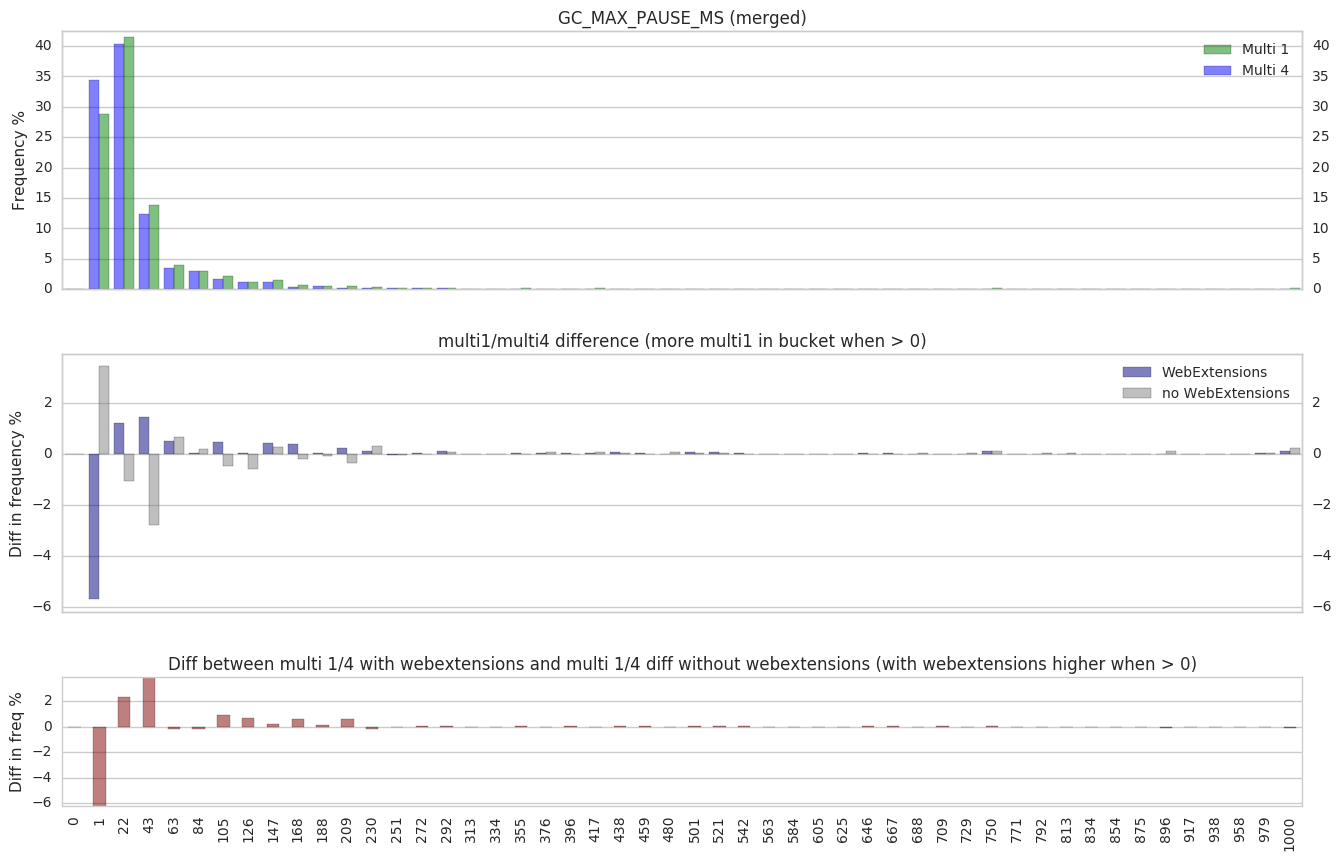

The probability that the distributions for GC_MAX_PAUSE_MS (merged) (with webextensions)
are differing by chance is 0.473.
The probability that the distributions for GC_MAX_PAUSE_MS (merged) (without webextensions)
are differing by chance is 0.024.


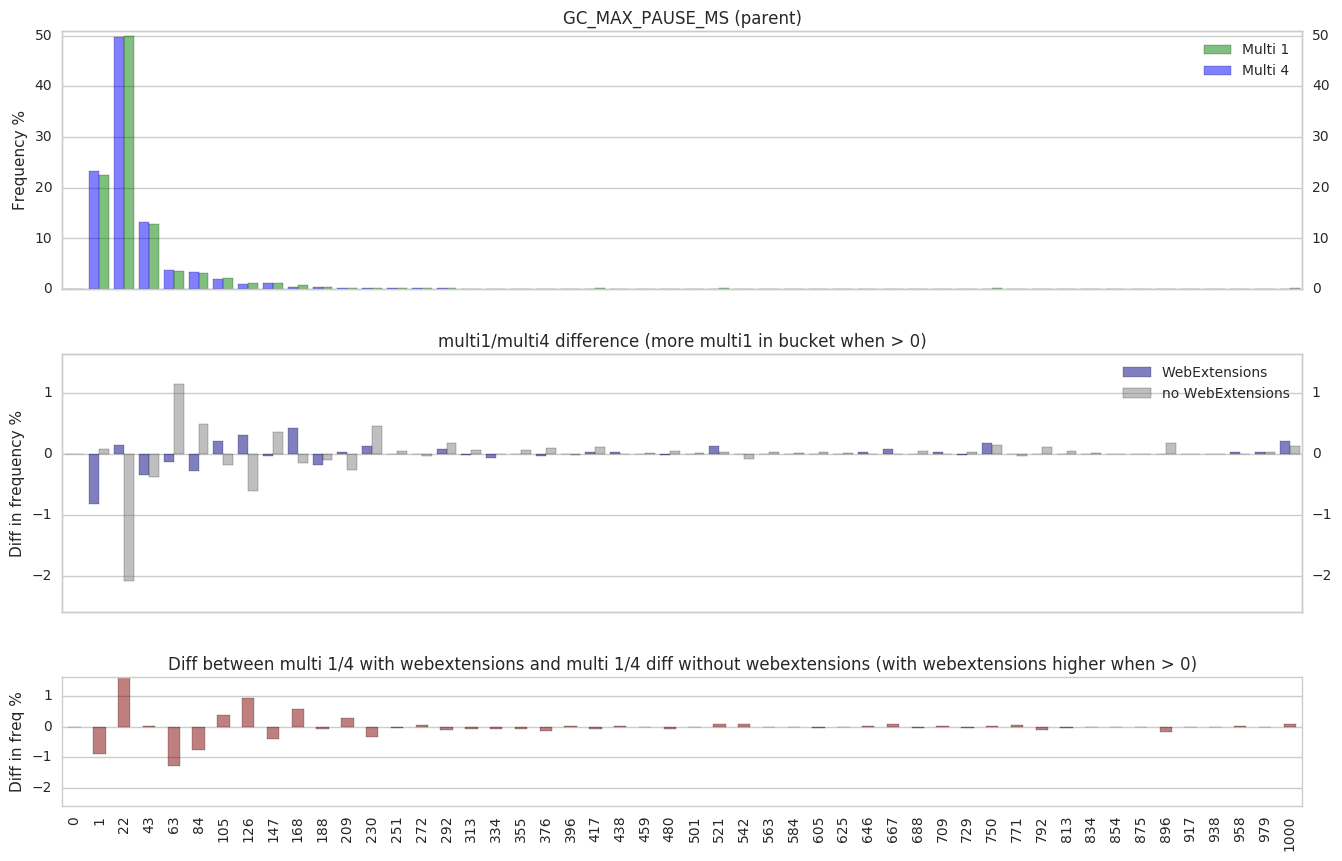

The probability that the distributions for GC_MAX_PAUSE_MS (parent) (with webextensions)
are differing by chance is 0.804.
The probability that the distributions for GC_MAX_PAUSE_MS (parent) (without webextensions)
are differing by chance is 0.221.


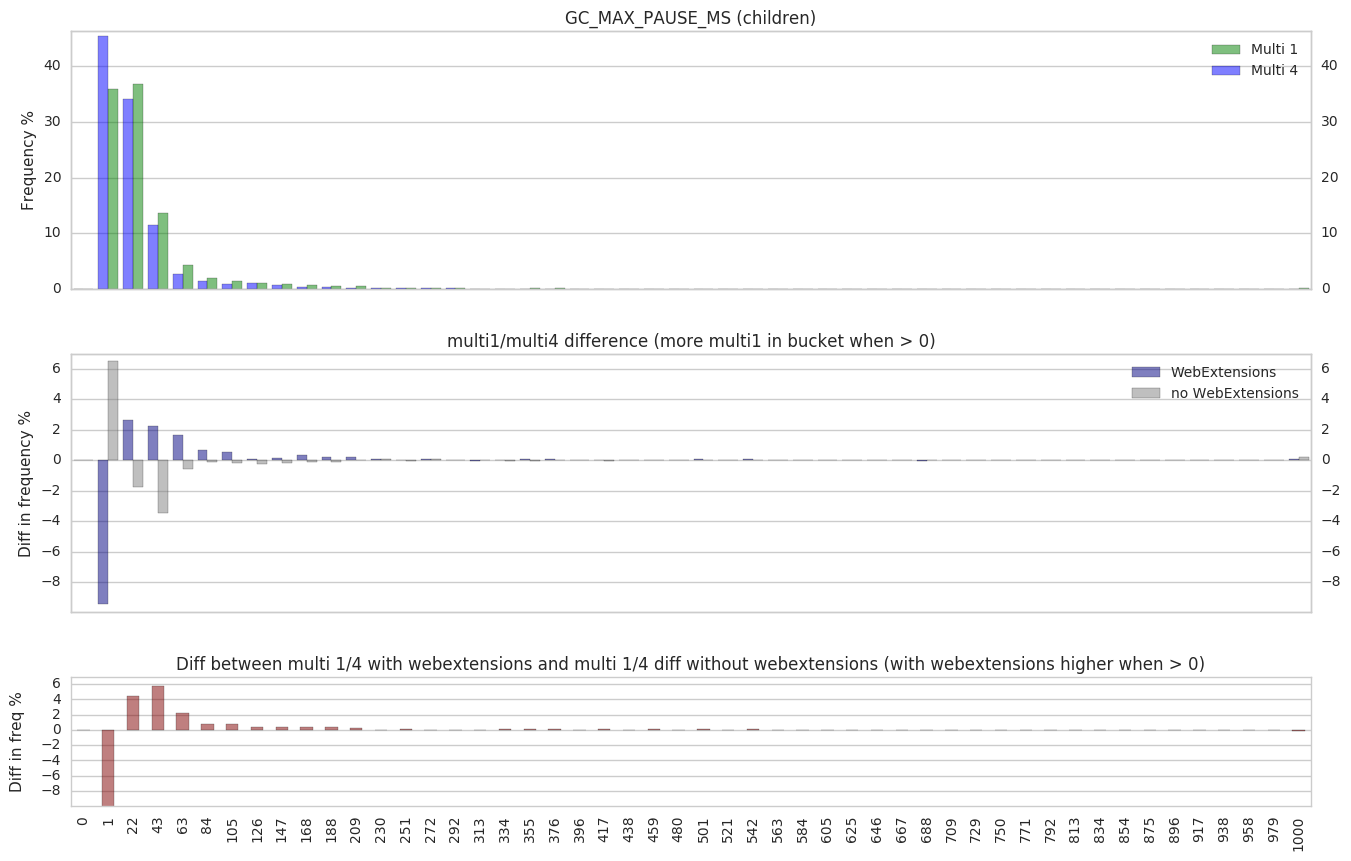

The probability that the distributions for GC_MAX_PAUSE_MS (children) (with webextensions)
are differing by chance is 0.545.
The probability that the distributions for GC_MAX_PAUSE_MS (children) (without webextensions)
are differing by chance is 0.040.


# Linux

Comparison for GC_MAX_PAUSE_MS (with add-ons):

6 (0.0%) multi_1 profiles have this histogram.
3 (0.0%) multi_4 profiles have this histogram.
2 (0.0%) webext_multi_1 profiles have this histogram.
2 (0.0%) webext_multi_4 profiles have this histogram.
6 (0.0%) multi_1 profiles have the parent histogram.
3 (0.0%) multi_4 profiles have the parent histogram.
2 (0.0%) webext_multi_1 profiles have the parent histogram.
2 (0.0%) webextx_multi_4 profiles have the parent histogram.
5 (0.0%) multi_1 profiles have the child histogram.
3 (0.0%) multi_4 profiles have the child histogram.
2 (0.0%) webext_multi_1 profiles have the child histogram.
2 (0.0%) webextx_multi_4 profiles have the child histogram.


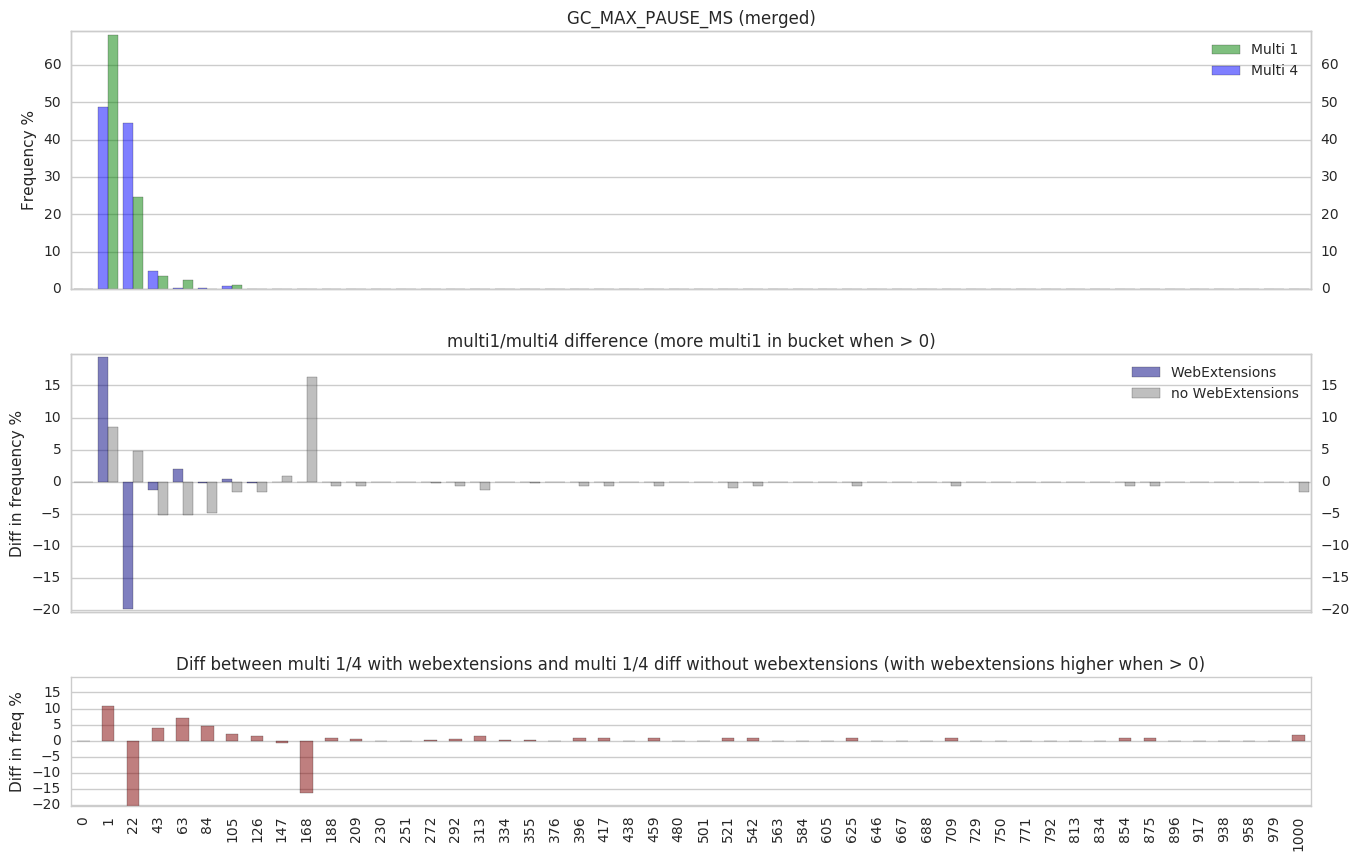

The probability that the distributions for GC_MAX_PAUSE_MS (merged) (with webextensions)
are differing by chance is 0.339.
The probability that the distributions for GC_MAX_PAUSE_MS (merged) (without webextensions)
are differing by chance is 0.582.


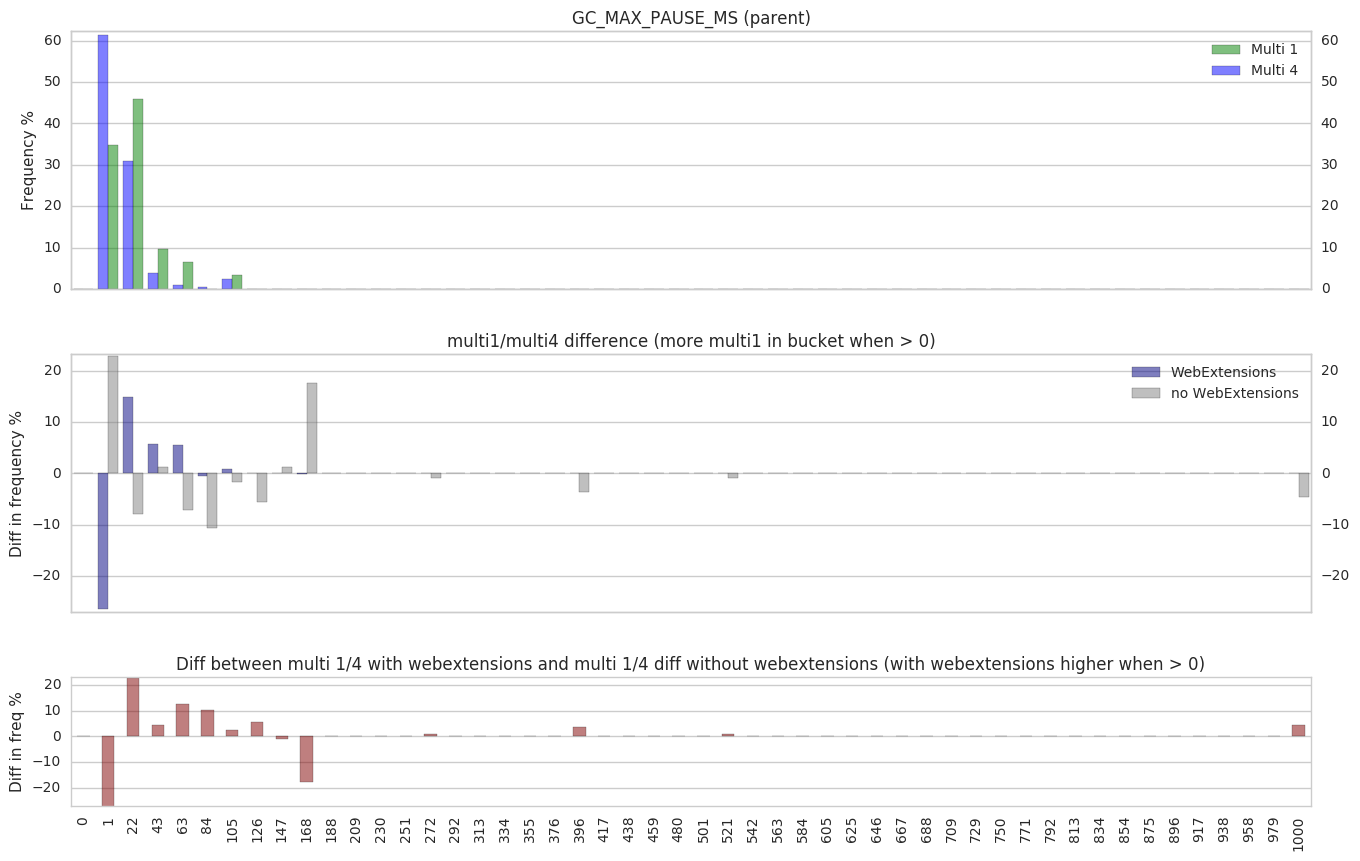

The probability that the distributions for GC_MAX_PAUSE_MS (parent) (with webextensions)
are differing by chance is 0.357.
The probability that the distributions for GC_MAX_PAUSE_MS (parent) (without webextensions)
are differing by chance is 0.396.


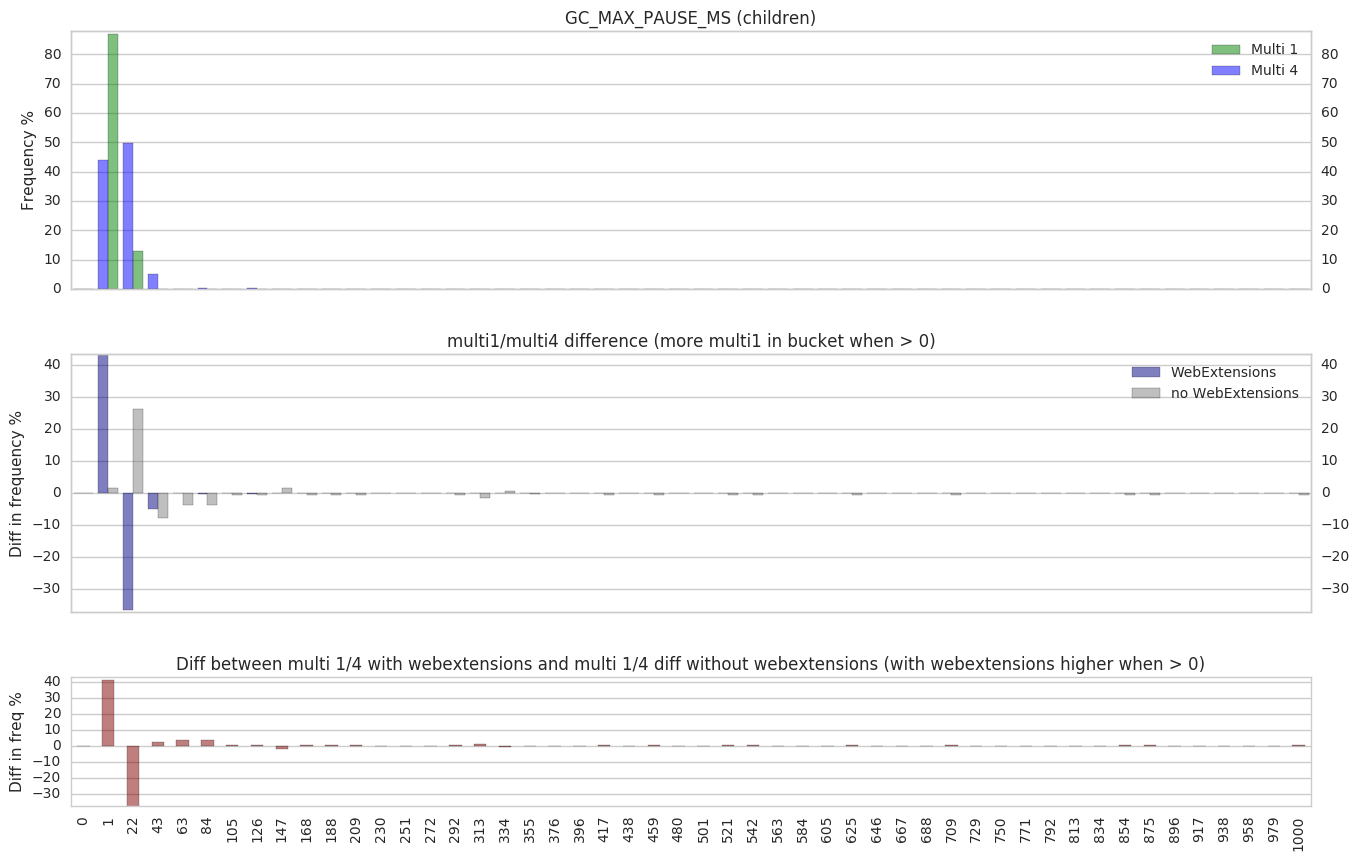

The probability that the distributions for GC_MAX_PAUSE_MS (children) (with webextensions)
are differing by chance is 0.375.
The probability that the distributions for GC_MAX_PAUSE_MS (children) (without webextensions)
are differing by chance is 0.657.


# Windows_NT

Comparison for GC_MAX_PAUSE_MS (with add-ons):

26474 (99.3%) multi_1 profiles have this histogram.
26059 (99.3%) multi_4 profiles have this histogram.
26311 (99.5%) webext_multi_1 profiles have this histogram.
26139 (99.4%) webext_multi_4 profiles have this histogram.
26474 (99.3%) multi_1 profiles have the parent histogram.
26059 (99.3%) multi_4 profiles have the parent histogram.
26311 (99.5%) webext_multi_1 profiles have the parent histogram.
26139 (99.4%) webextx_multi_4 profiles have the parent histogram.
24582 (92.2%) multi_1 profiles have the child histogram.
24237 (92.3%) multi_4 profiles have the child histogram.
24706 (93.4%) webext_multi_1 profiles have the child histogram.
24457 (93.0%) webextx_multi_4 profiles have the child histogram.


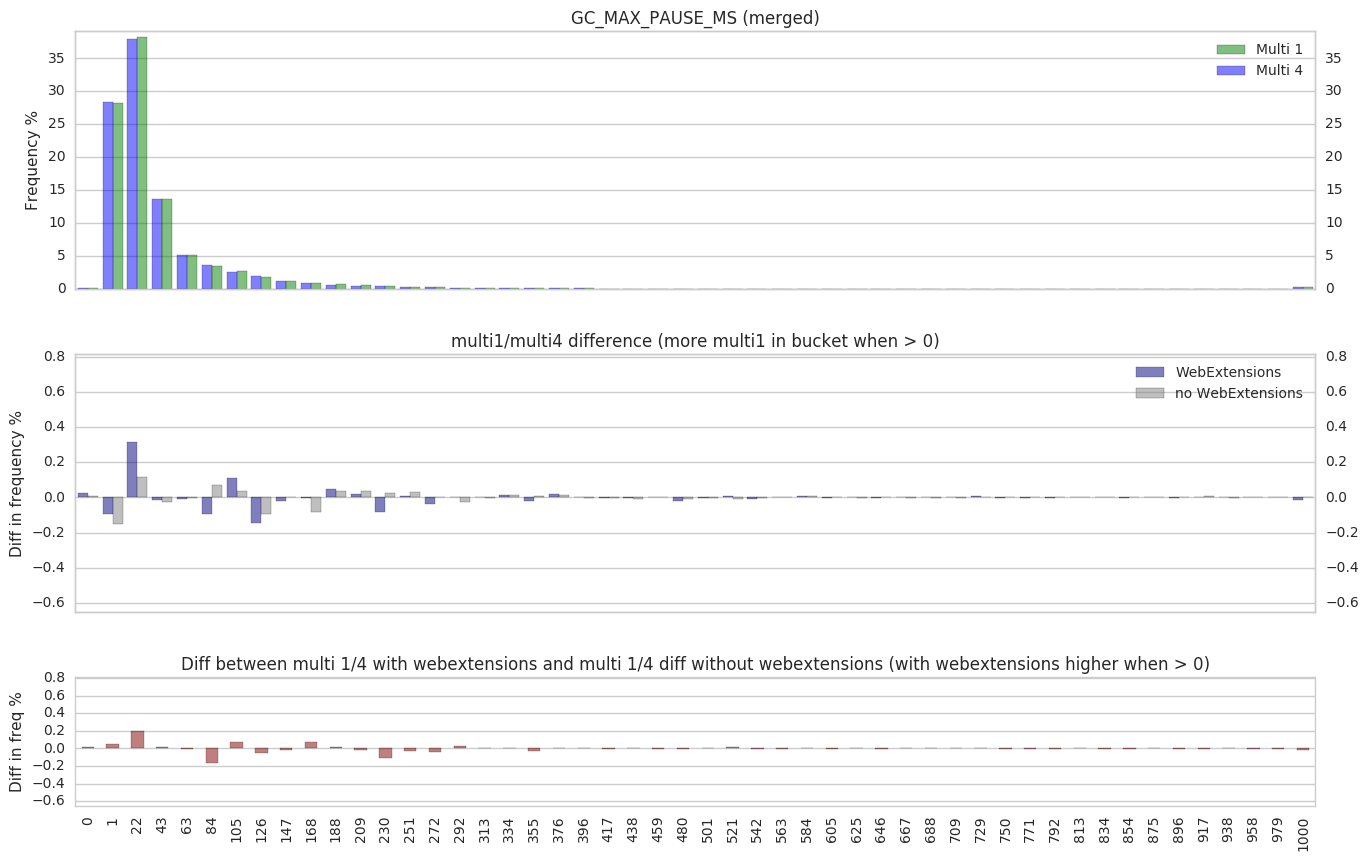

The probability that the distributions for GC_MAX_PAUSE_MS (merged) (with webextensions)
are differing by chance is 0.500.
The probability that the distributions for GC_MAX_PAUSE_MS (merged) (without webextensions)
are differing by chance is 0.789.


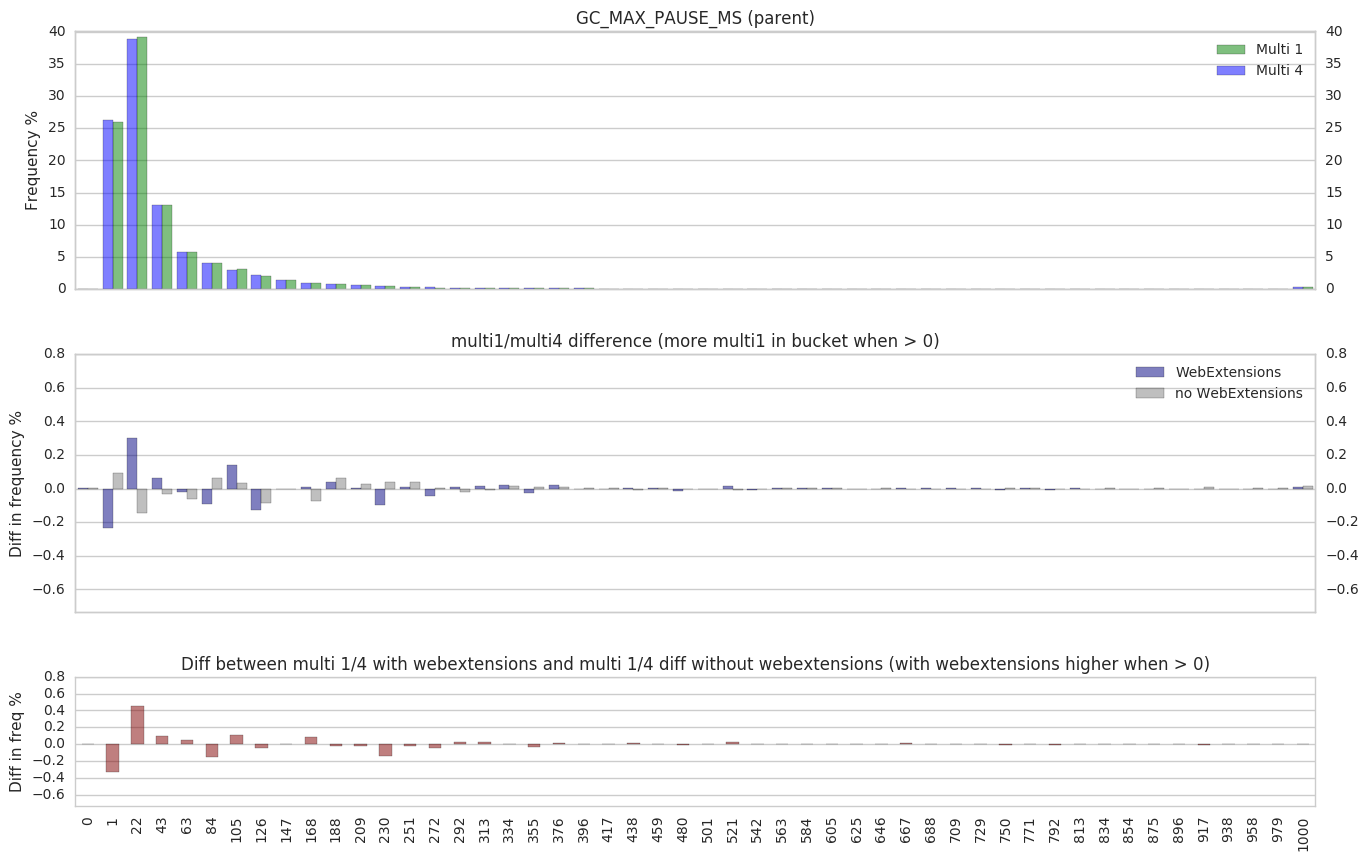

The probability that the distributions for GC_MAX_PAUSE_MS (parent) (with webextensions)
are differing by chance is 0.509.
The probability that the distributions for GC_MAX_PAUSE_MS (parent) (without webextensions)
are differing by chance is 0.292.


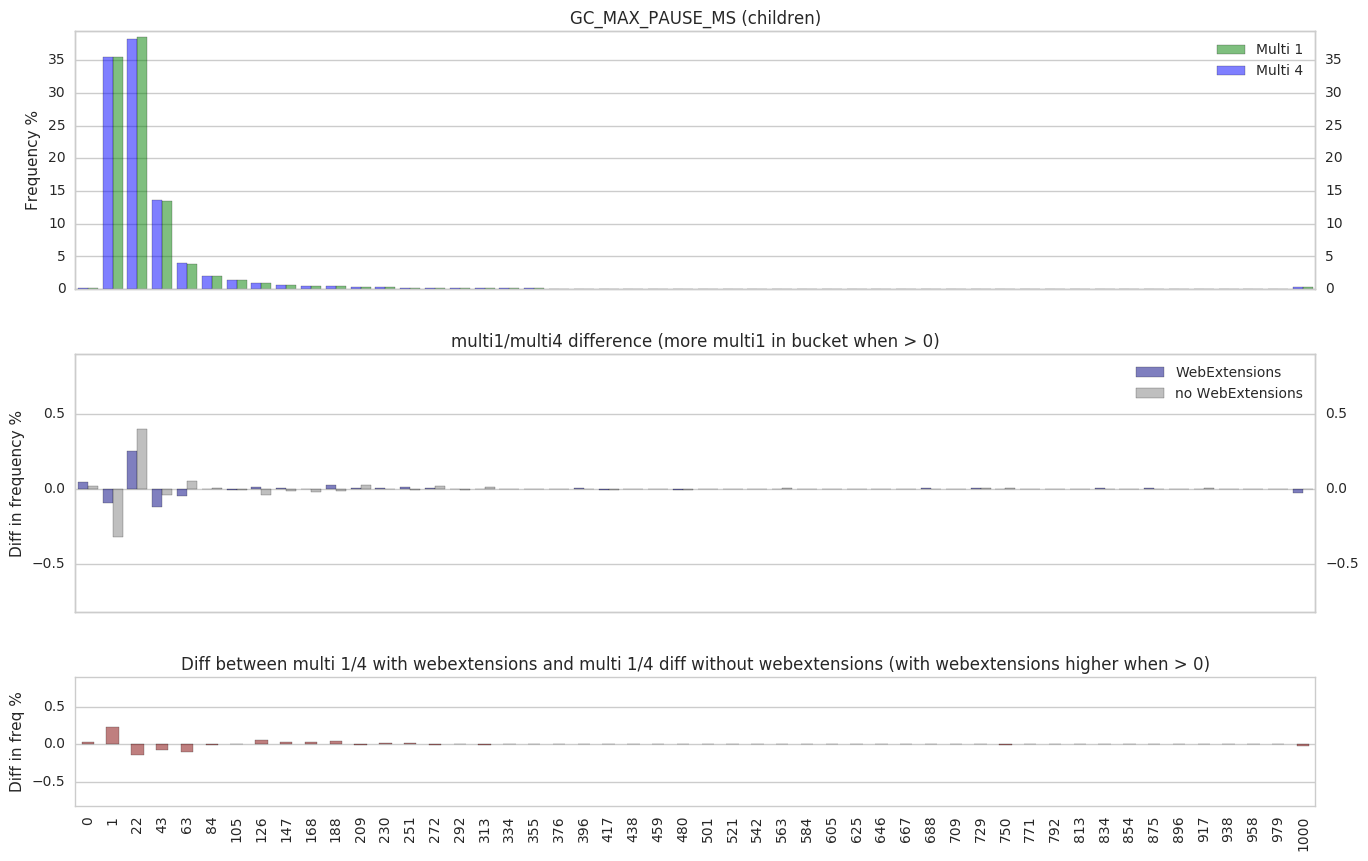

The probability that the distributions for GC_MAX_PAUSE_MS (children) (with webextensions)
are differing by chance is 0.384.
The probability that the distributions for GC_MAX_PAUSE_MS (children) (without webextensions)
are differing by chance is 0.909.


In [104]:
results.append(compare_histograms(subset,  "payload/histograms/GC_MAX_PAUSE_MS"))

### CYCLE_COLLECTOR_MAX_PAUSE

# Darwin

Comparison for CYCLE_COLLECTOR_MAX_PAUSE (with add-ons):

155 (0.6%) multi_1 profiles have this histogram.
170 (0.6%) multi_4 profiles have this histogram.
123 (0.5%) webext_multi_1 profiles have this histogram.
130 (0.5%) webext_multi_4 profiles have this histogram.
155 (0.6%) multi_1 profiles have the parent histogram.
170 (0.6%) multi_4 profiles have the parent histogram.
123 (0.5%) webext_multi_1 profiles have the parent histogram.
130 (0.5%) webextx_multi_4 profiles have the parent histogram.
153 (0.6%) multi_1 profiles have the child histogram.
166 (0.6%) multi_4 profiles have the child histogram.
123 (0.5%) webext_multi_1 profiles have the child histogram.
128 (0.5%) webextx_multi_4 profiles have the child histogram.


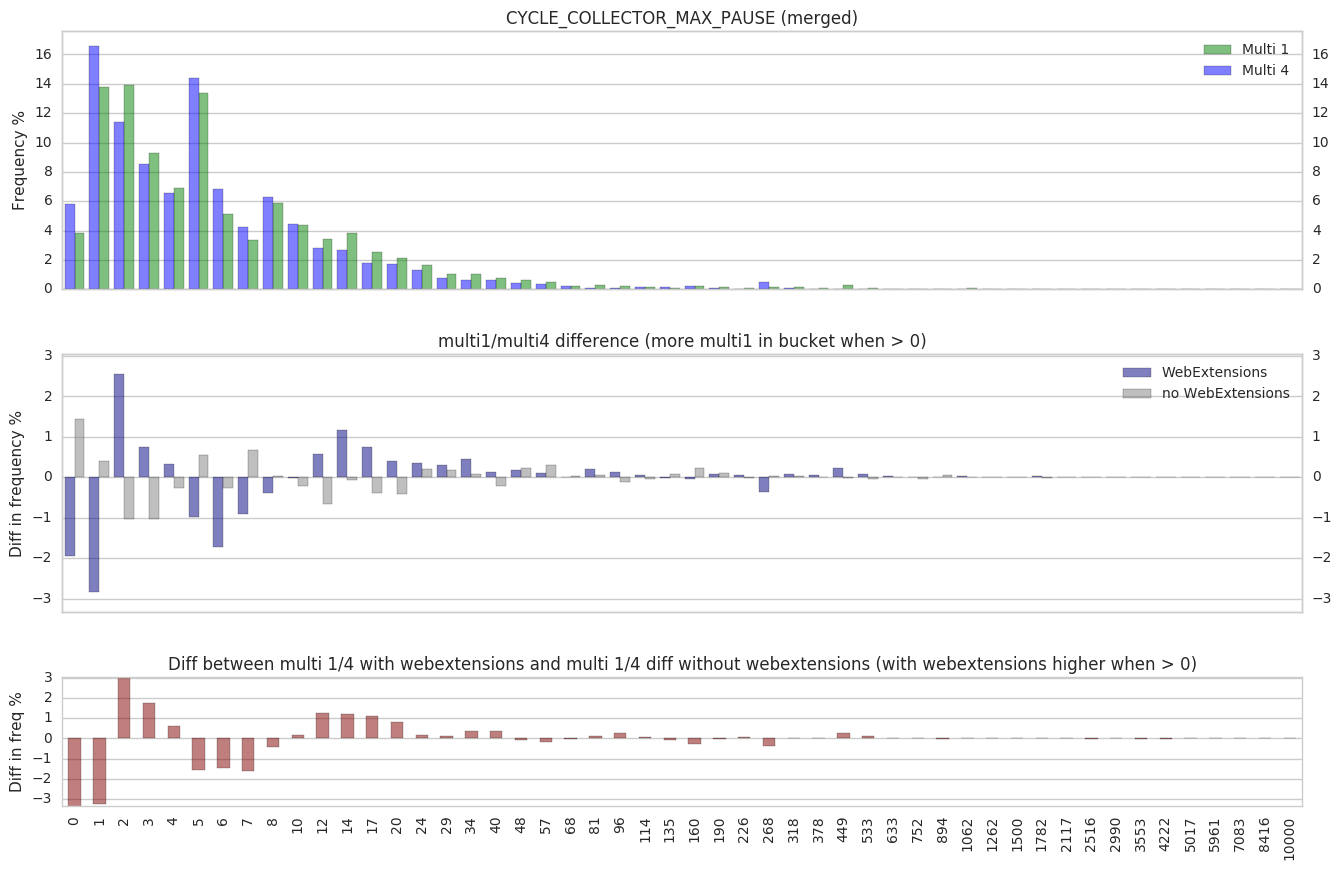

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (merged) (with webextensions)
are differing by chance is 0.402.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (merged) (without webextensions)
are differing by chance is 0.119.


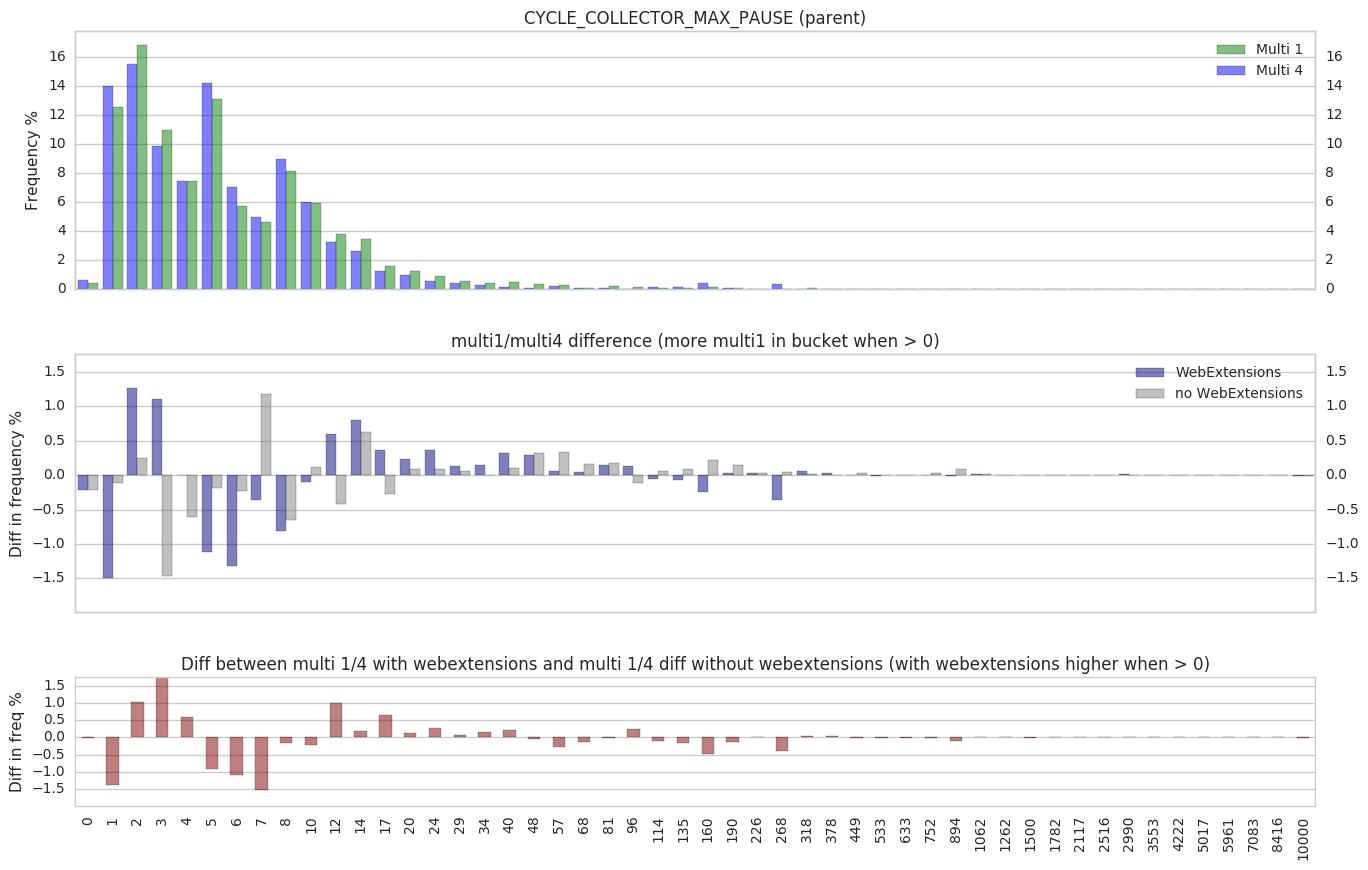

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (with webextensions)
are differing by chance is 0.116.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (without webextensions)
are differing by chance is 0.955.


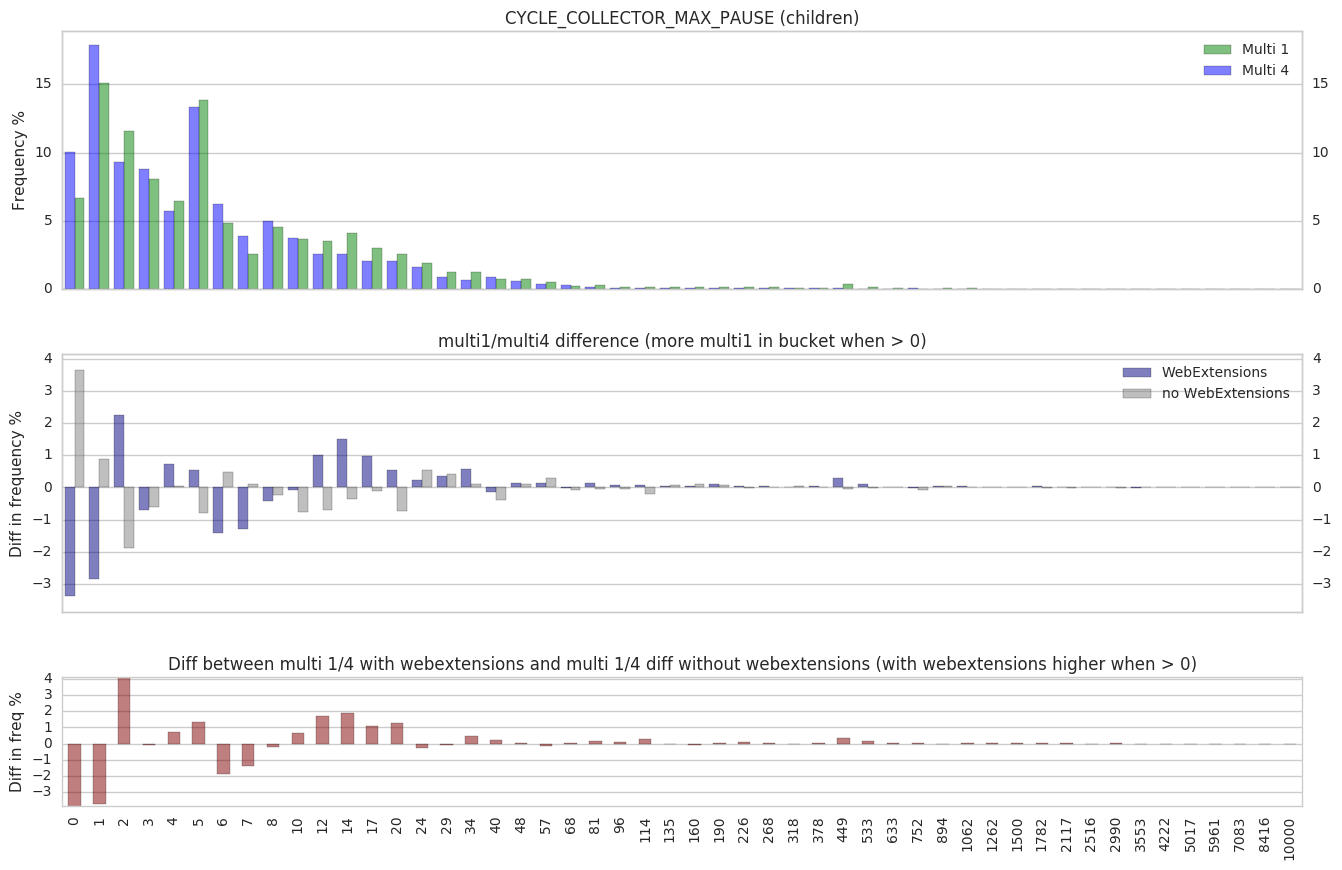

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (children) (with webextensions)
are differing by chance is 0.429.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (children) (without webextensions)
are differing by chance is 0.128.


# Linux

Comparison for CYCLE_COLLECTOR_MAX_PAUSE (with add-ons):

5 (0.0%) multi_1 profiles have this histogram.
3 (0.0%) multi_4 profiles have this histogram.
2 (0.0%) webext_multi_1 profiles have this histogram.
2 (0.0%) webext_multi_4 profiles have this histogram.
5 (0.0%) multi_1 profiles have the parent histogram.
3 (0.0%) multi_4 profiles have the parent histogram.
2 (0.0%) webext_multi_1 profiles have the parent histogram.
2 (0.0%) webextx_multi_4 profiles have the parent histogram.
5 (0.0%) multi_1 profiles have the child histogram.
3 (0.0%) multi_4 profiles have the child histogram.
2 (0.0%) webext_multi_1 profiles have the child histogram.
2 (0.0%) webextx_multi_4 profiles have the child histogram.


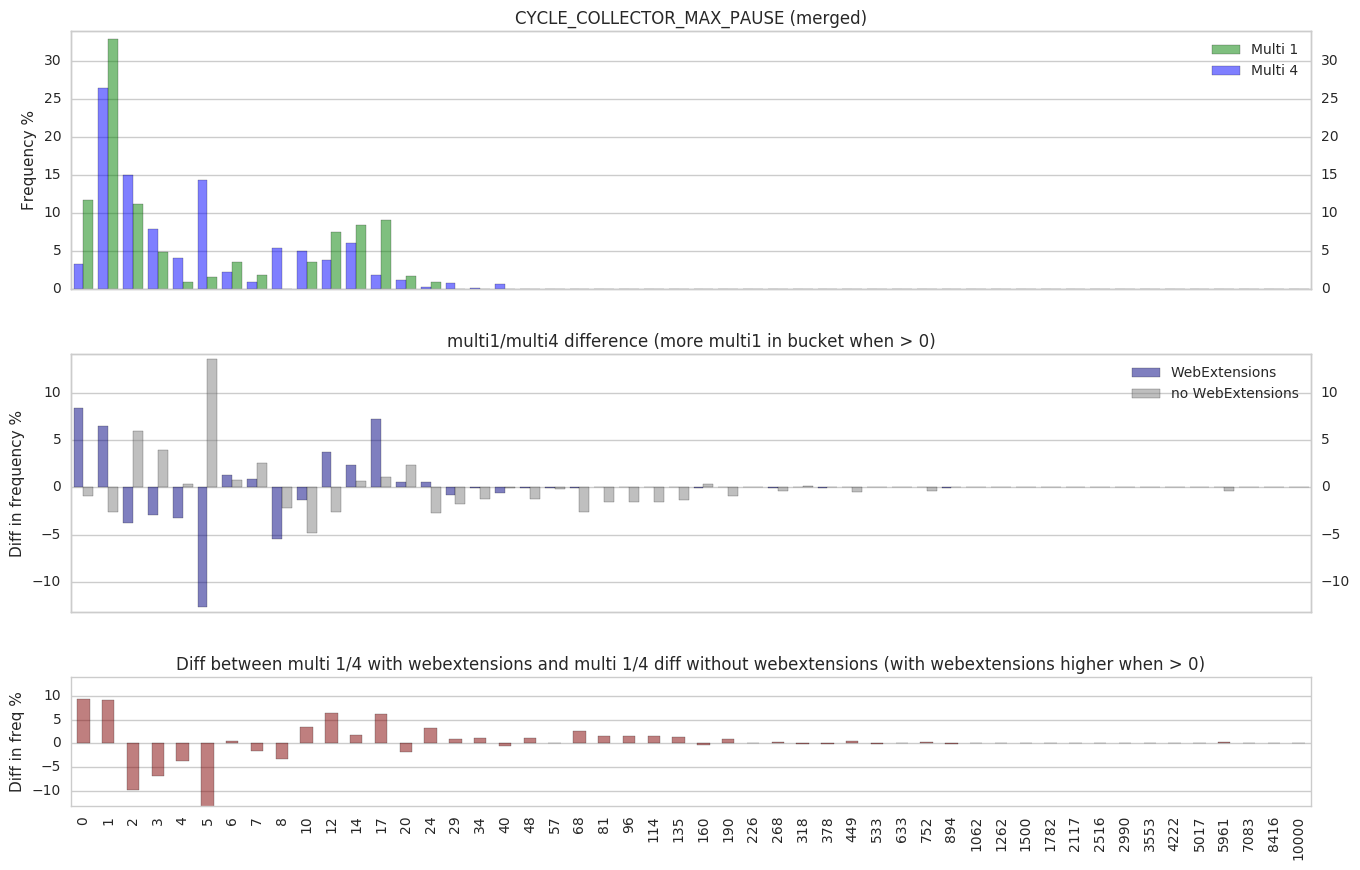

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (merged) (with webextensions)
are differing by chance is 0.393.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (merged) (without webextensions)
are differing by chance is 0.768.


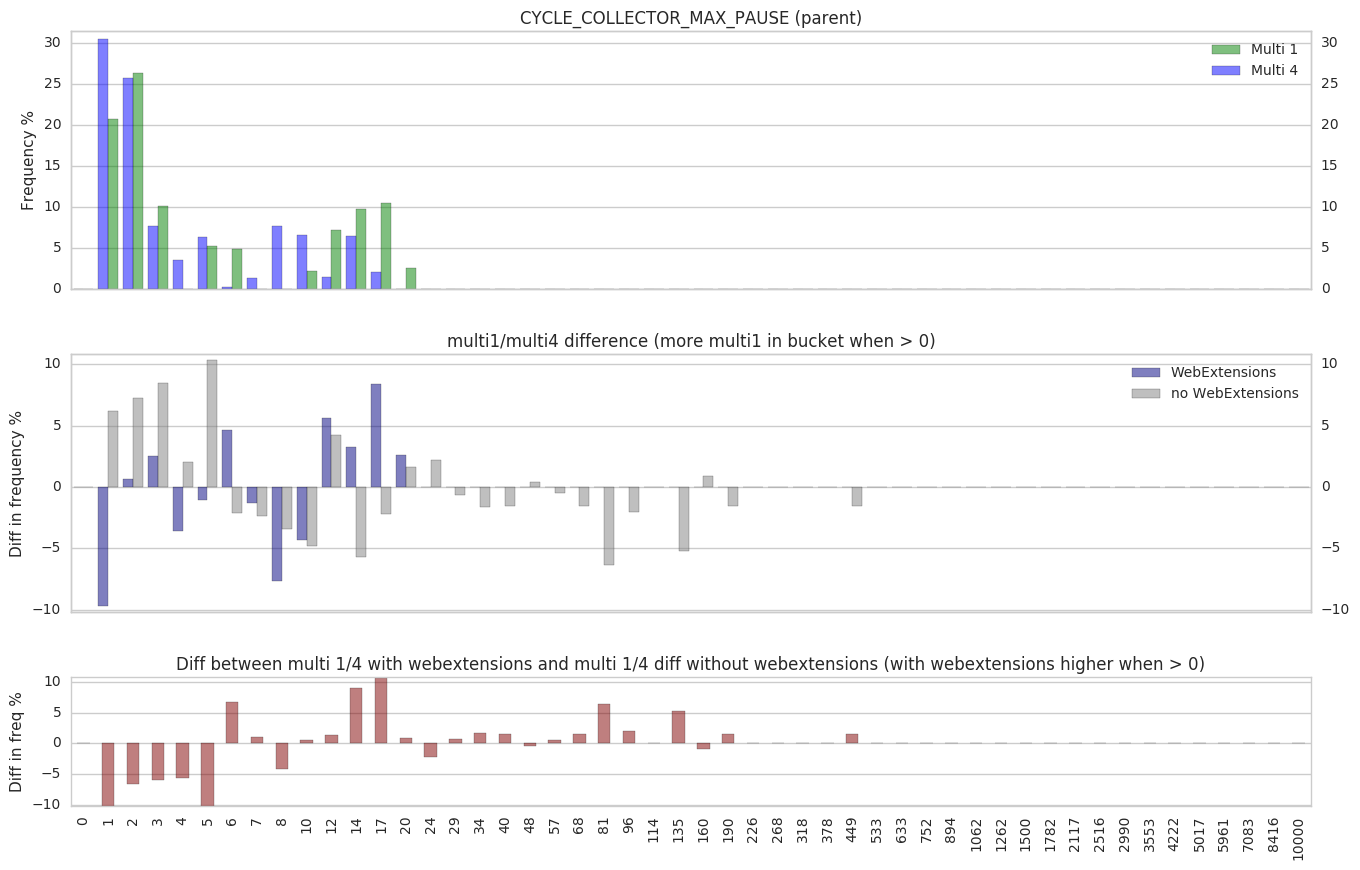

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (with webextensions)
are differing by chance is 0.330.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (without webextensions)
are differing by chance is 0.985.


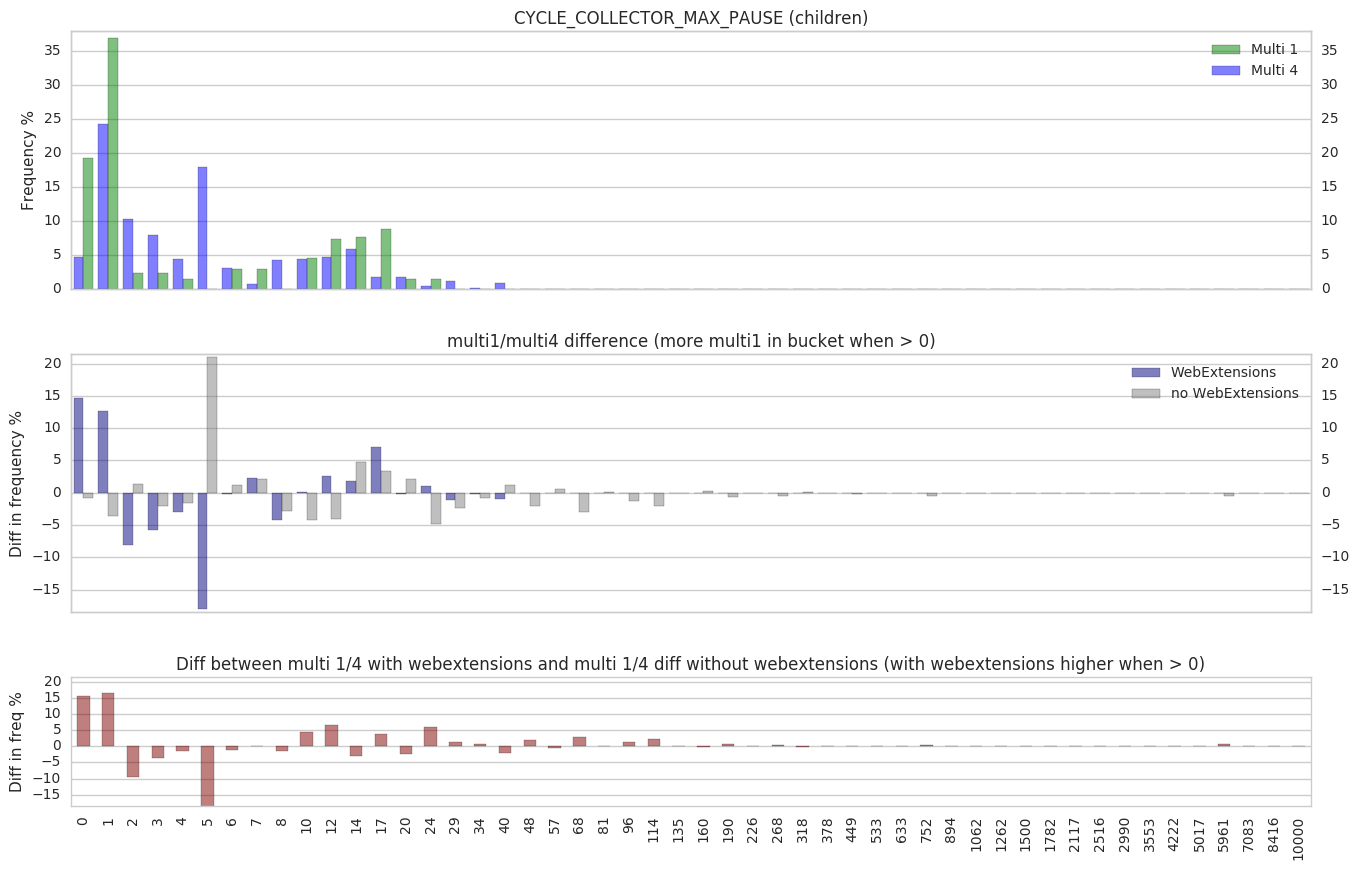

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (children) (with webextensions)
are differing by chance is 0.295.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (children) (without webextensions)
are differing by chance is 0.658.


# Windows_NT

Comparison for CYCLE_COLLECTOR_MAX_PAUSE (with add-ons):

24535 (92.0%) multi_1 profiles have this histogram.
24200 (92.2%) multi_4 profiles have this histogram.
24632 (93.1%) webext_multi_1 profiles have this histogram.
24397 (92.8%) webext_multi_4 profiles have this histogram.
24531 (92.0%) multi_1 profiles have the parent histogram.
24192 (92.2%) multi_4 profiles have the parent histogram.
24624 (93.1%) webext_multi_1 profiles have the parent histogram.
24385 (92.8%) webextx_multi_4 profiles have the parent histogram.
24077 (90.3%) multi_1 profiles have the child histogram.
23754 (90.5%) multi_4 profiles have the child histogram.
24228 (91.6%) webext_multi_1 profiles have the child histogram.
23955 (91.1%) webextx_multi_4 profiles have the child histogram.


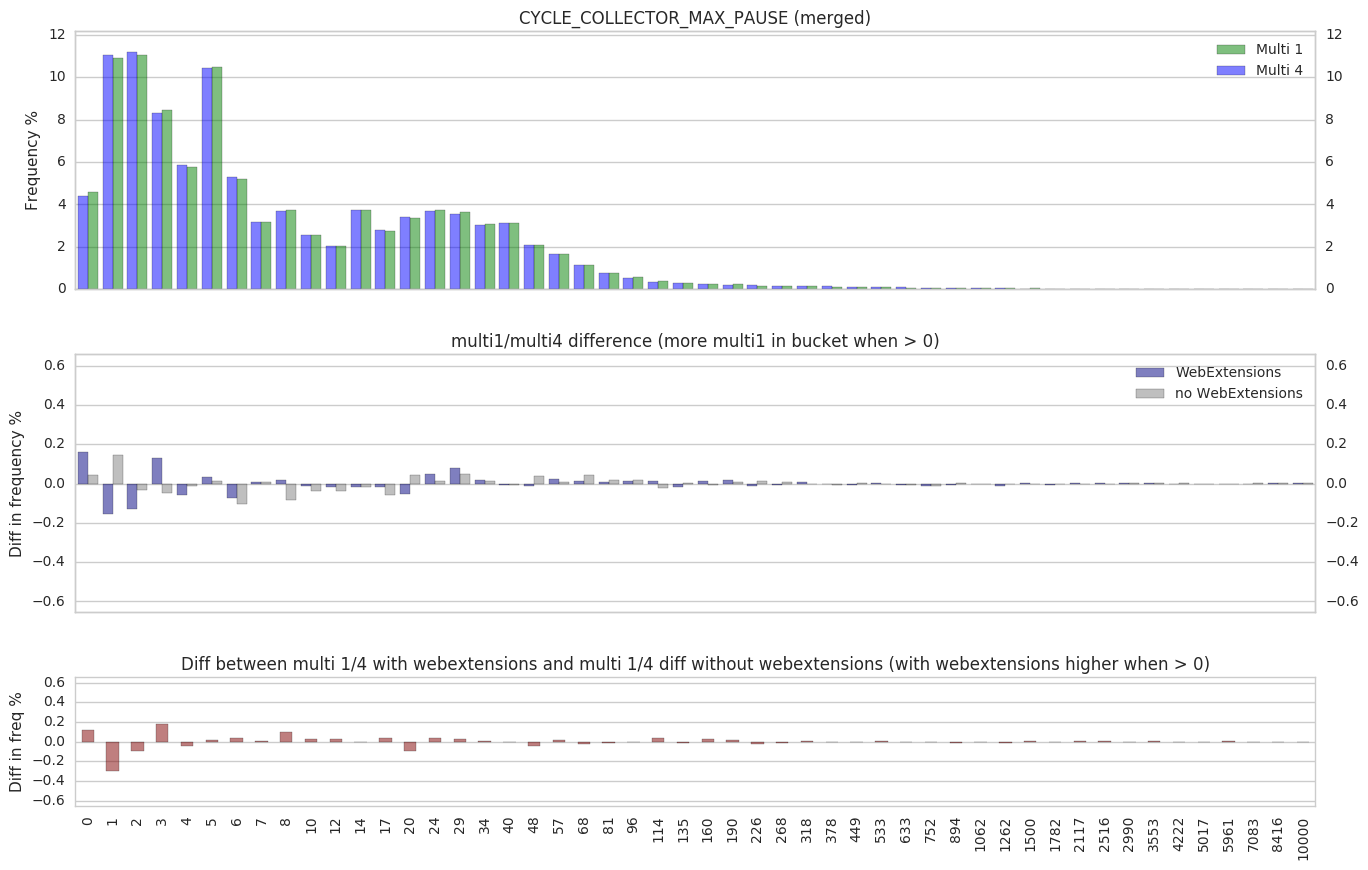

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (merged) (with webextensions)
are differing by chance is 0.125.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (merged) (without webextensions)
are differing by chance is 0.771.


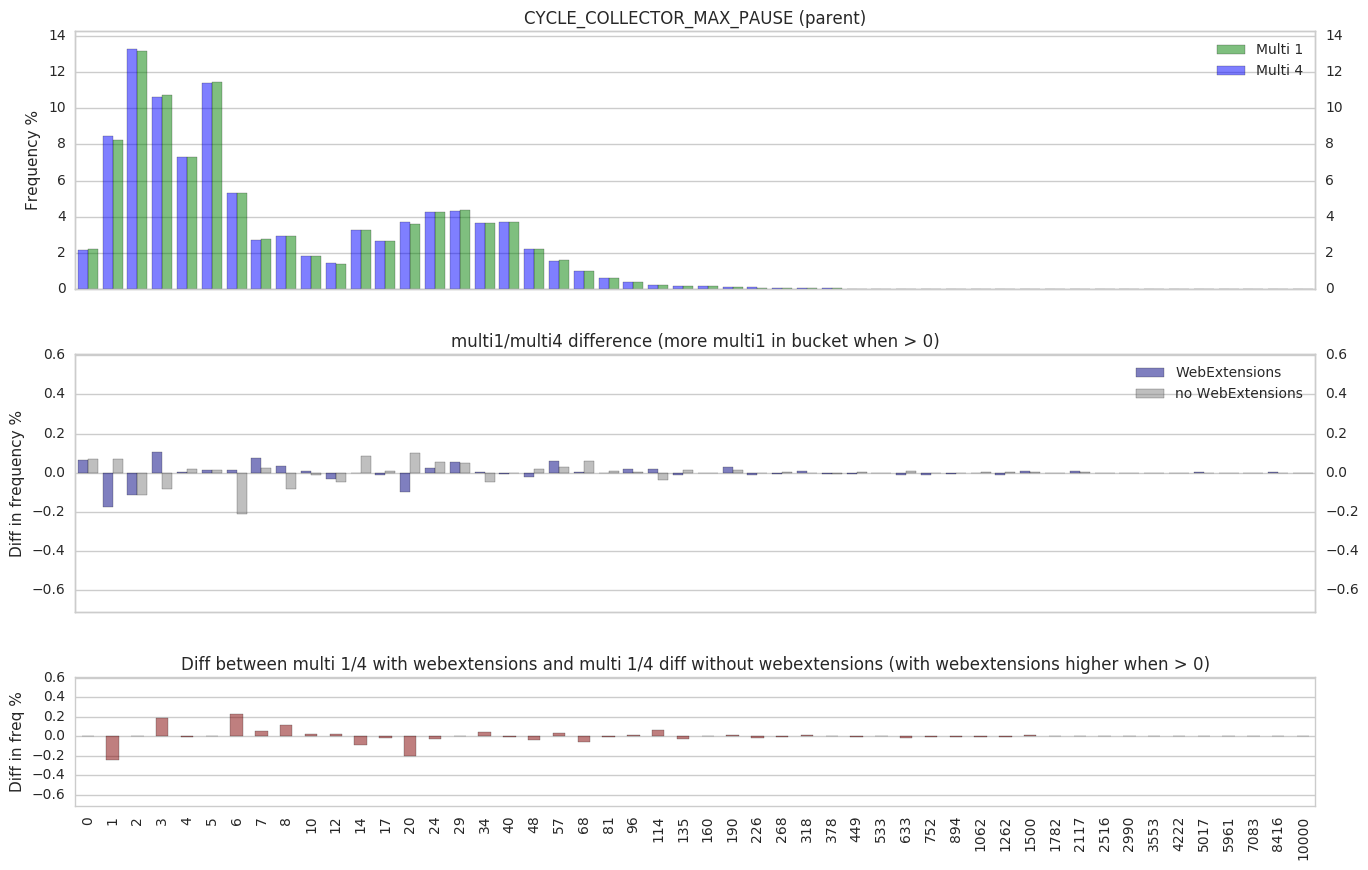

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (with webextensions)
are differing by chance is 0.446.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (parent) (without webextensions)
are differing by chance is 0.398.


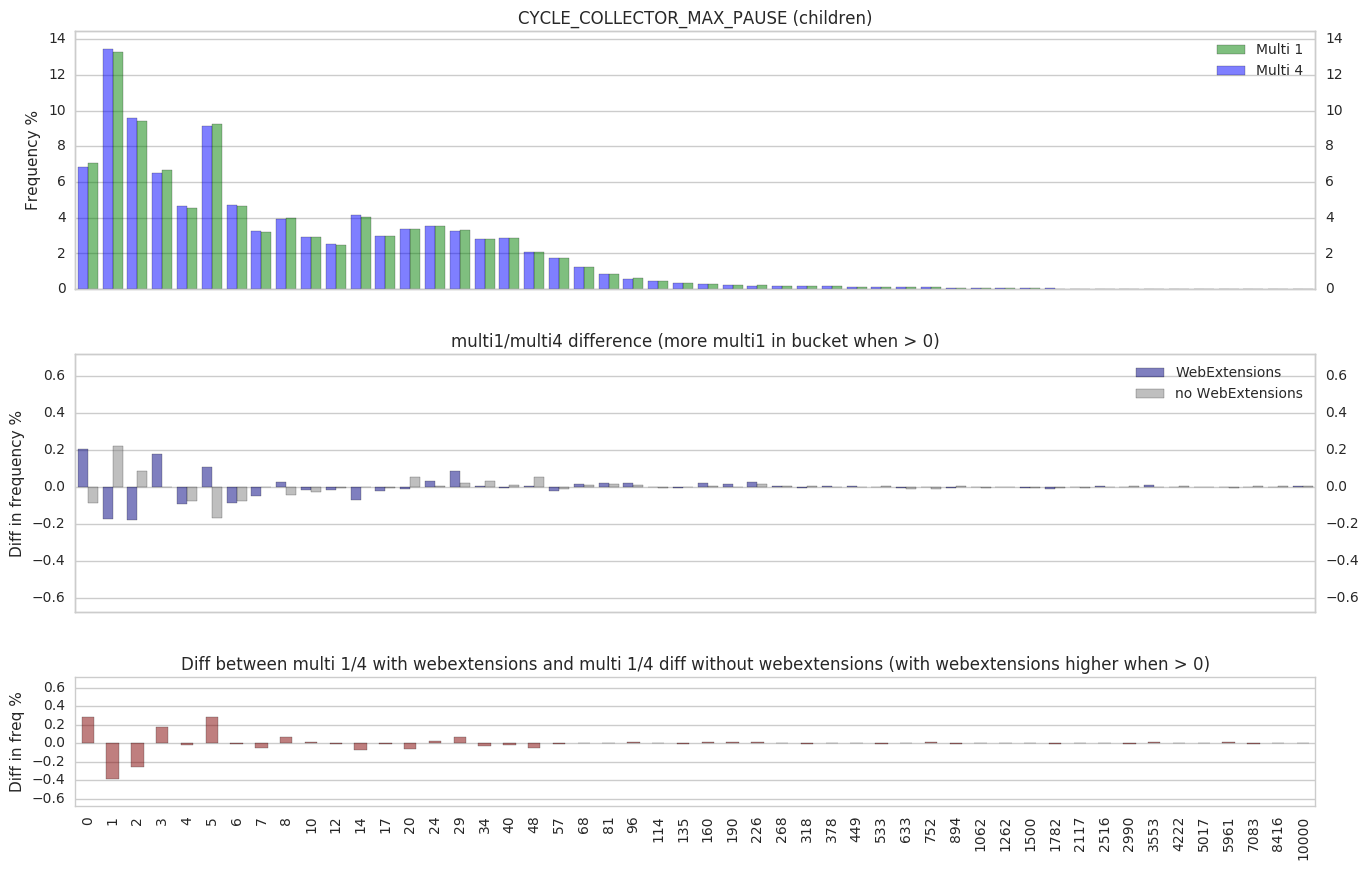

The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (children) (with webextensions)
are differing by chance is 0.143.
The probability that the distributions for CYCLE_COLLECTOR_MAX_PAUSE (children) (without webextensions)
are differing by chance is 0.704.


In [106]:
results.append(compare_histograms(subset, "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE"))

### INPUT_EVENT_RESPONSE_MS

# Darwin

Comparison for INPUT_EVENT_RESPONSE_MS (with add-ons):

158 (0.6%) multi_1 profiles have this histogram.
173 (0.7%) multi_4 profiles have this histogram.
126 (0.5%) webext_multi_1 profiles have this histogram.
134 (0.5%) webext_multi_4 profiles have this histogram.
158 (0.6%) multi_1 profiles have the parent histogram.
173 (0.7%) multi_4 profiles have the parent histogram.
126 (0.5%) webext_multi_1 profiles have the parent histogram.
134 (0.5%) webextx_multi_4 profiles have the parent histogram.
155 (0.6%) multi_1 profiles have the child histogram.
170 (0.6%) multi_4 profiles have the child histogram.
124 (0.5%) webext_multi_1 profiles have the child histogram.
131 (0.5%) webextx_multi_4 profiles have the child histogram.


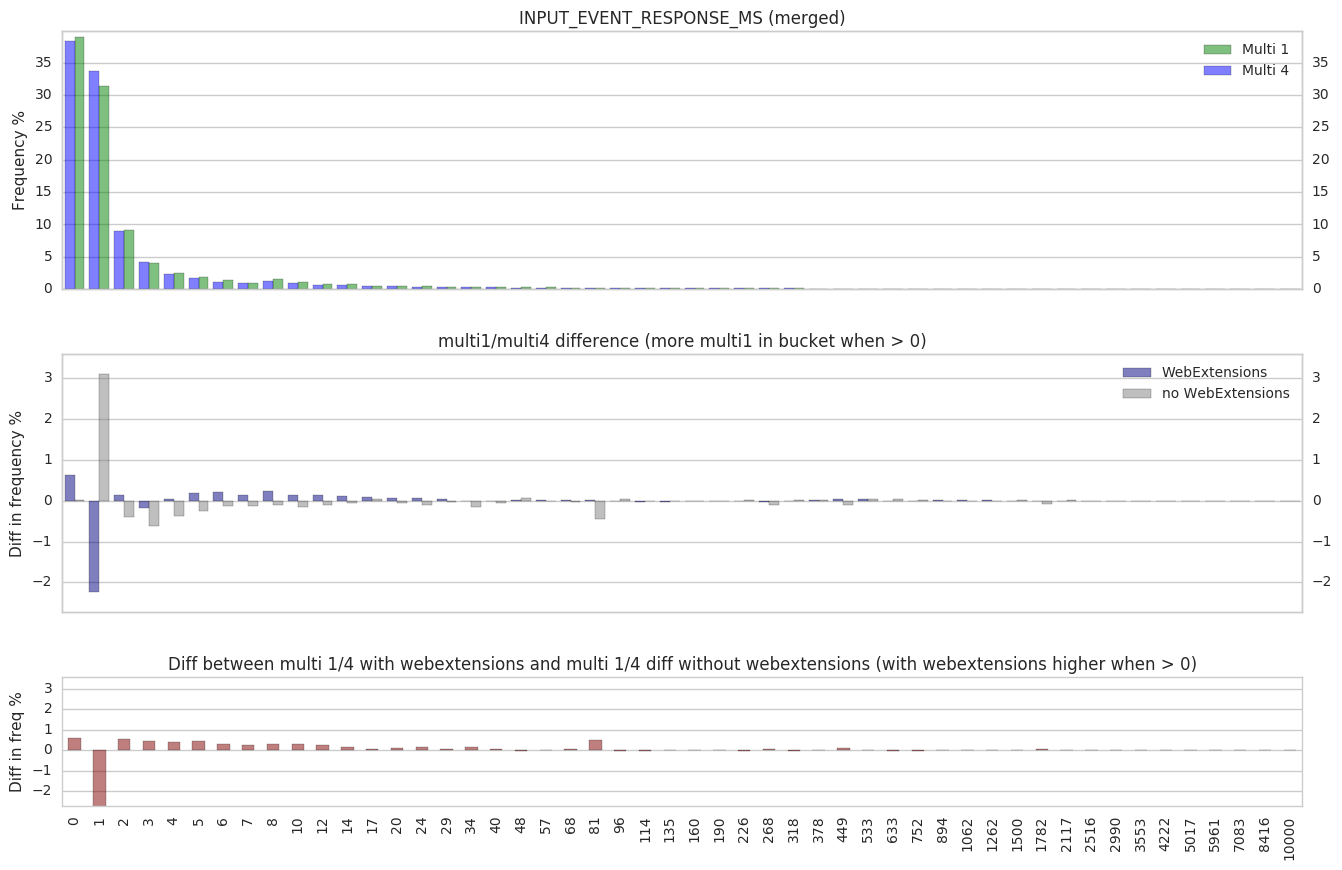

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (merged) (with webextensions)
are differing by chance is 0.393.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (merged) (without webextensions)
are differing by chance is 0.748.


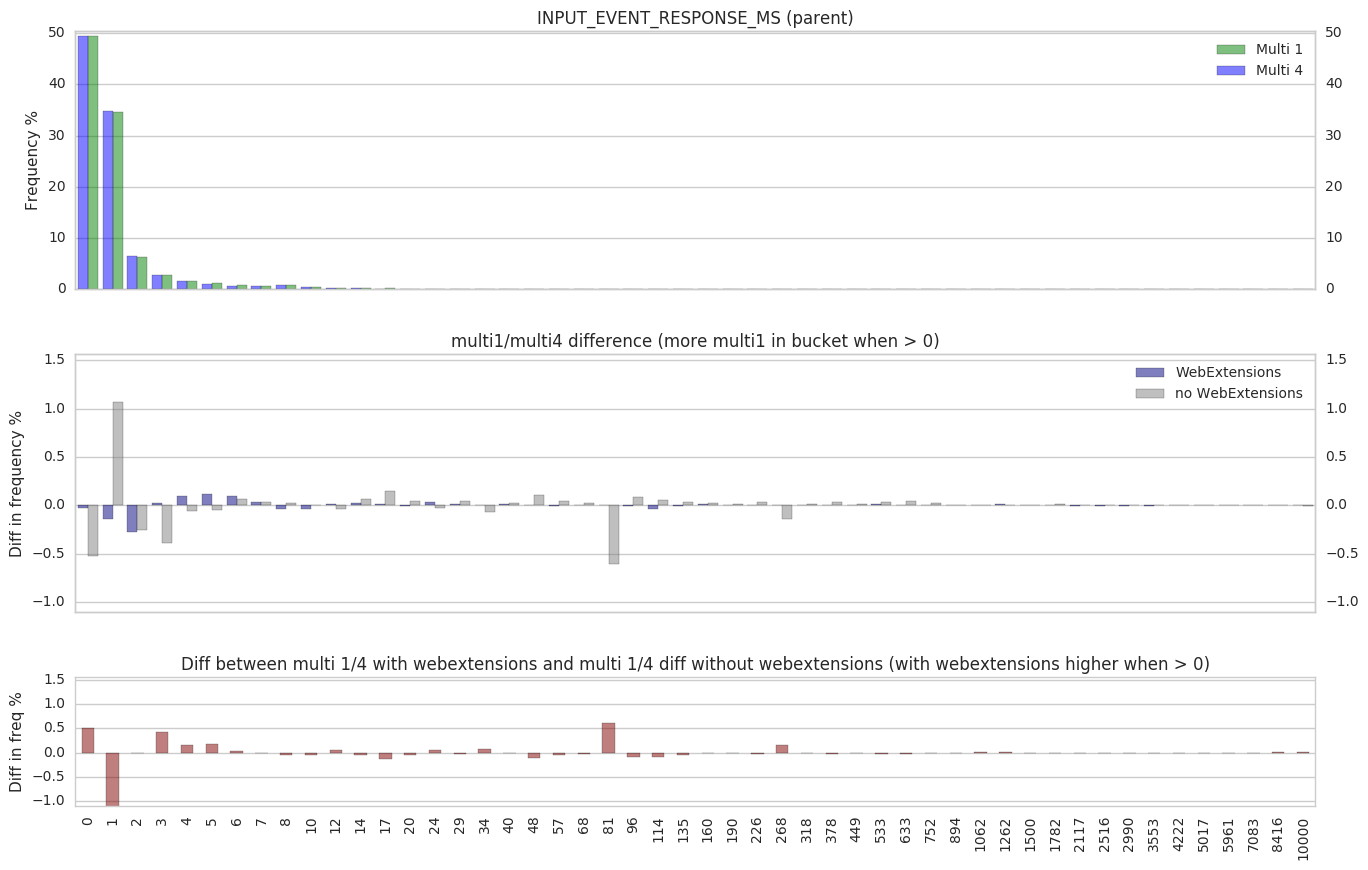

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (with webextensions)
are differing by chance is 0.420.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (without webextensions)
are differing by chance is 0.885.


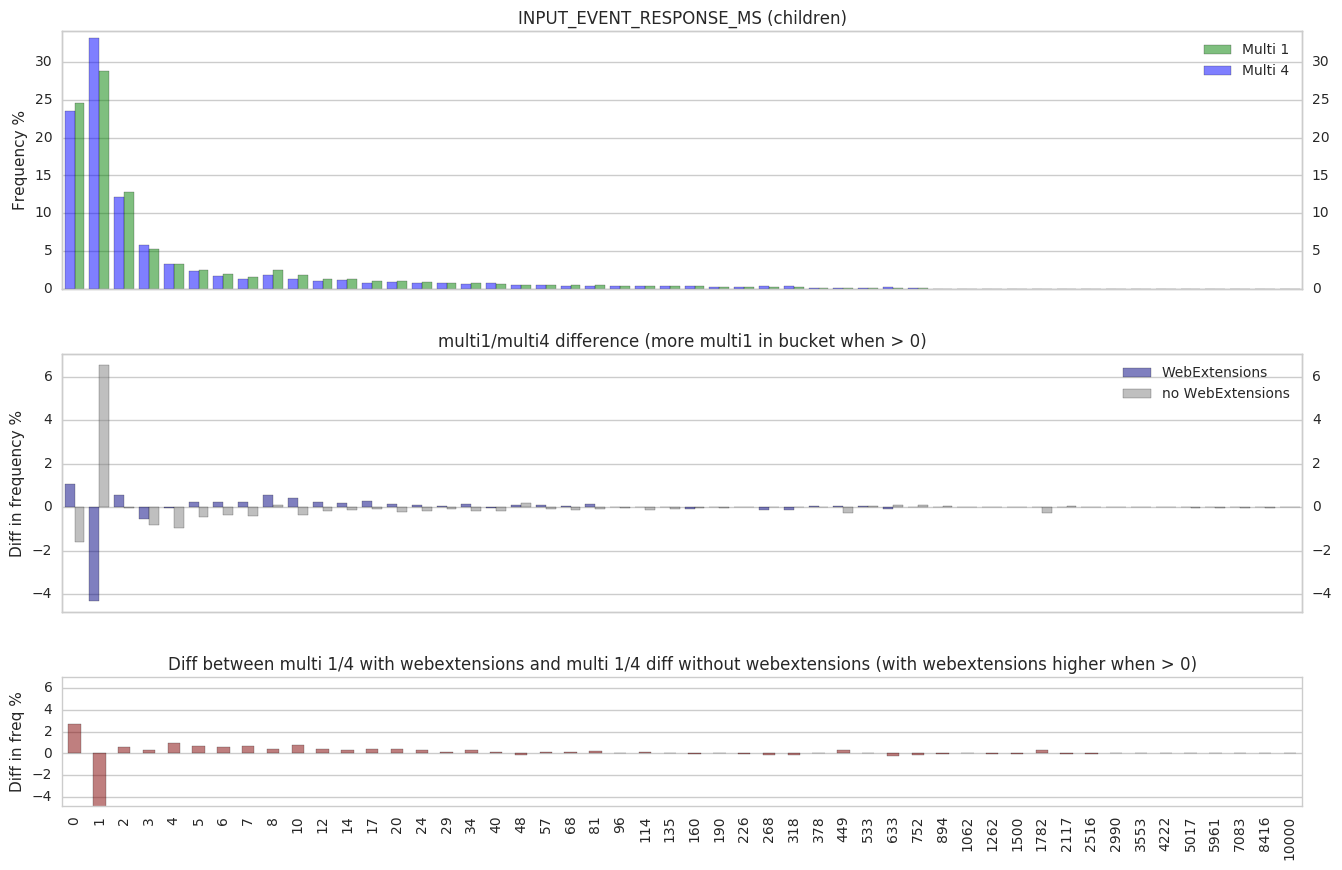

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (children) (with webextensions)
are differing by chance is 0.545.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (children) (without webextensions)
are differing by chance is 0.768.


# Linux

Comparison for INPUT_EVENT_RESPONSE_MS (with add-ons):

6 (0.0%) multi_1 profiles have this histogram.
3 (0.0%) multi_4 profiles have this histogram.
2 (0.0%) webext_multi_1 profiles have this histogram.
2 (0.0%) webext_multi_4 profiles have this histogram.
6 (0.0%) multi_1 profiles have the parent histogram.
3 (0.0%) multi_4 profiles have the parent histogram.
2 (0.0%) webext_multi_1 profiles have the parent histogram.
2 (0.0%) webextx_multi_4 profiles have the parent histogram.
6 (0.0%) multi_1 profiles have the child histogram.
3 (0.0%) multi_4 profiles have the child histogram.
2 (0.0%) webext_multi_1 profiles have the child histogram.
2 (0.0%) webextx_multi_4 profiles have the child histogram.


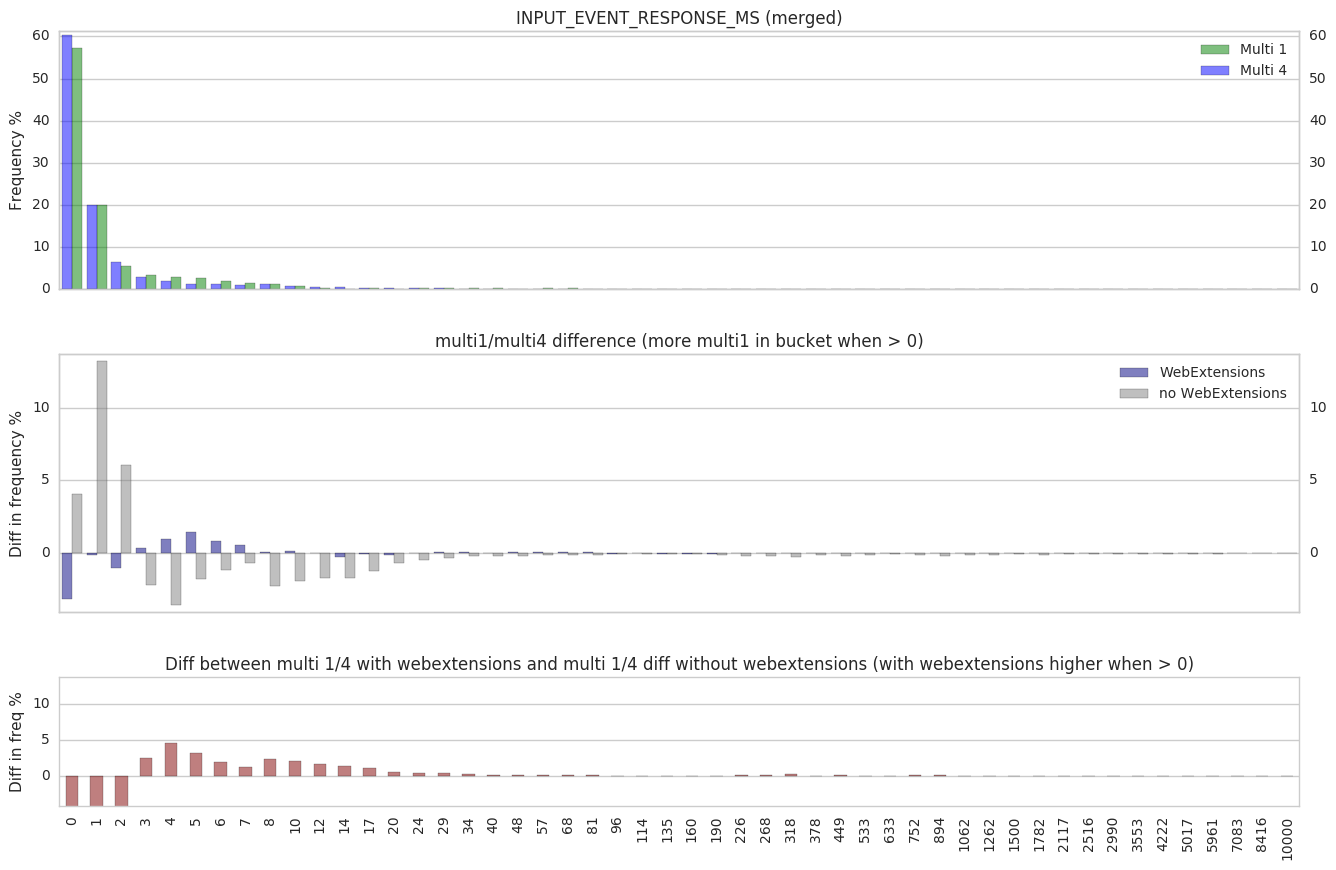

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (merged) (with webextensions)
are differing by chance is 0.348.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (merged) (without webextensions)
are differing by chance is 0.807.


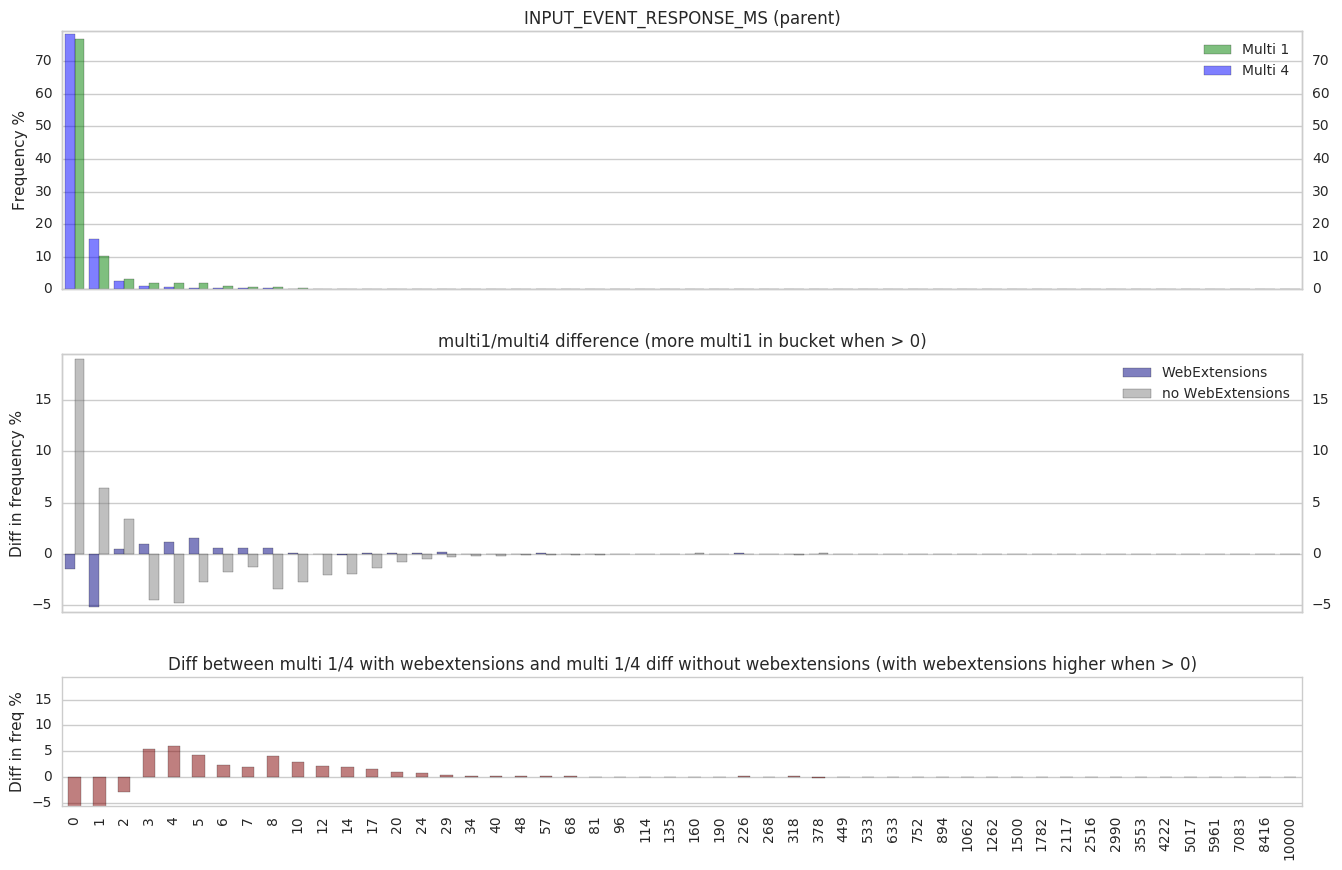

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (with webextensions)
are differing by chance is 0.714.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (without webextensions)
are differing by chance is 0.642.


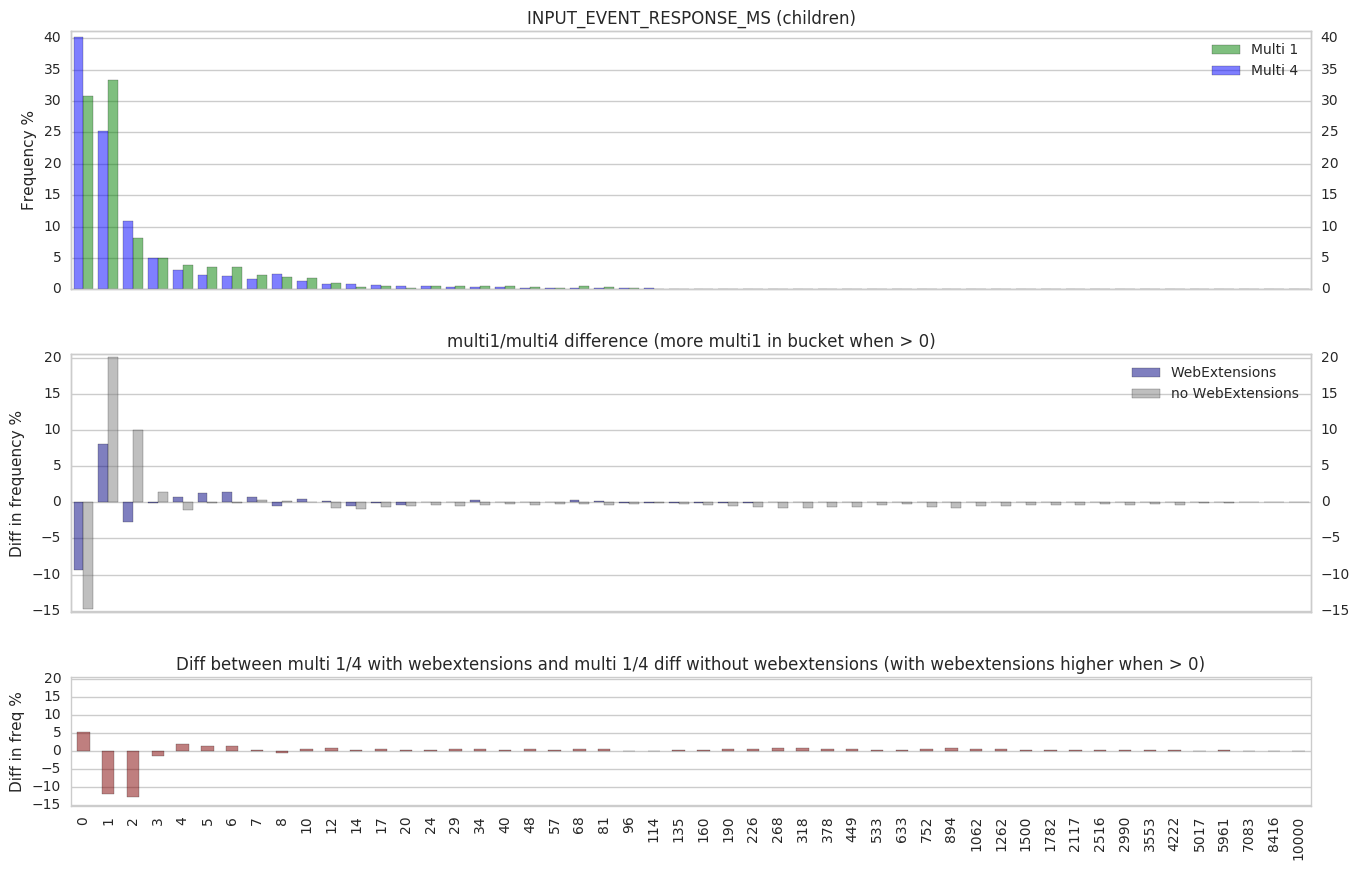

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (children) (with webextensions)
are differing by chance is 0.295.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (children) (without webextensions)
are differing by chance is 0.742.


# Windows_NT

Comparison for INPUT_EVENT_RESPONSE_MS (with add-ons):

26489 (99.4%) multi_1 profiles have this histogram.
26072 (99.3%) multi_4 profiles have this histogram.
26325 (99.5%) webext_multi_1 profiles have this histogram.
26149 (99.5%) webext_multi_4 profiles have this histogram.
26489 (99.4%) multi_1 profiles have the parent histogram.
26072 (99.3%) multi_4 profiles have the parent histogram.
26325 (99.5%) webext_multi_1 profiles have the parent histogram.
26149 (99.5%) webextx_multi_4 profiles have the parent histogram.
25234 (94.6%) multi_1 profiles have the child histogram.
24830 (94.6%) multi_4 profiles have the child histogram.
25132 (95.0%) webext_multi_1 profiles have the child histogram.
24901 (94.7%) webextx_multi_4 profiles have the child histogram.


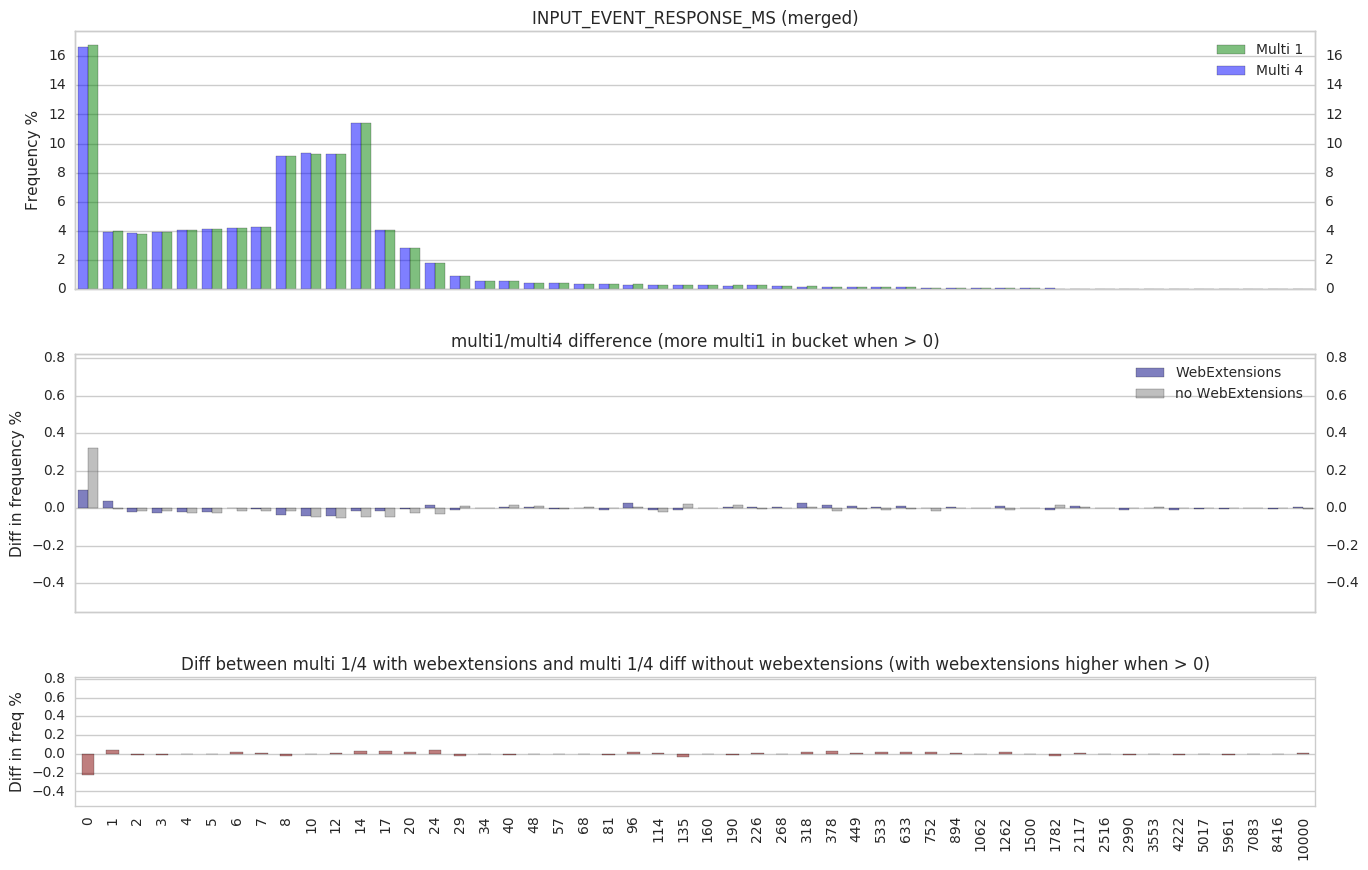

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (merged) (with webextensions)
are differing by chance is 0.634.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (merged) (without webextensions)
are differing by chance is 0.385.


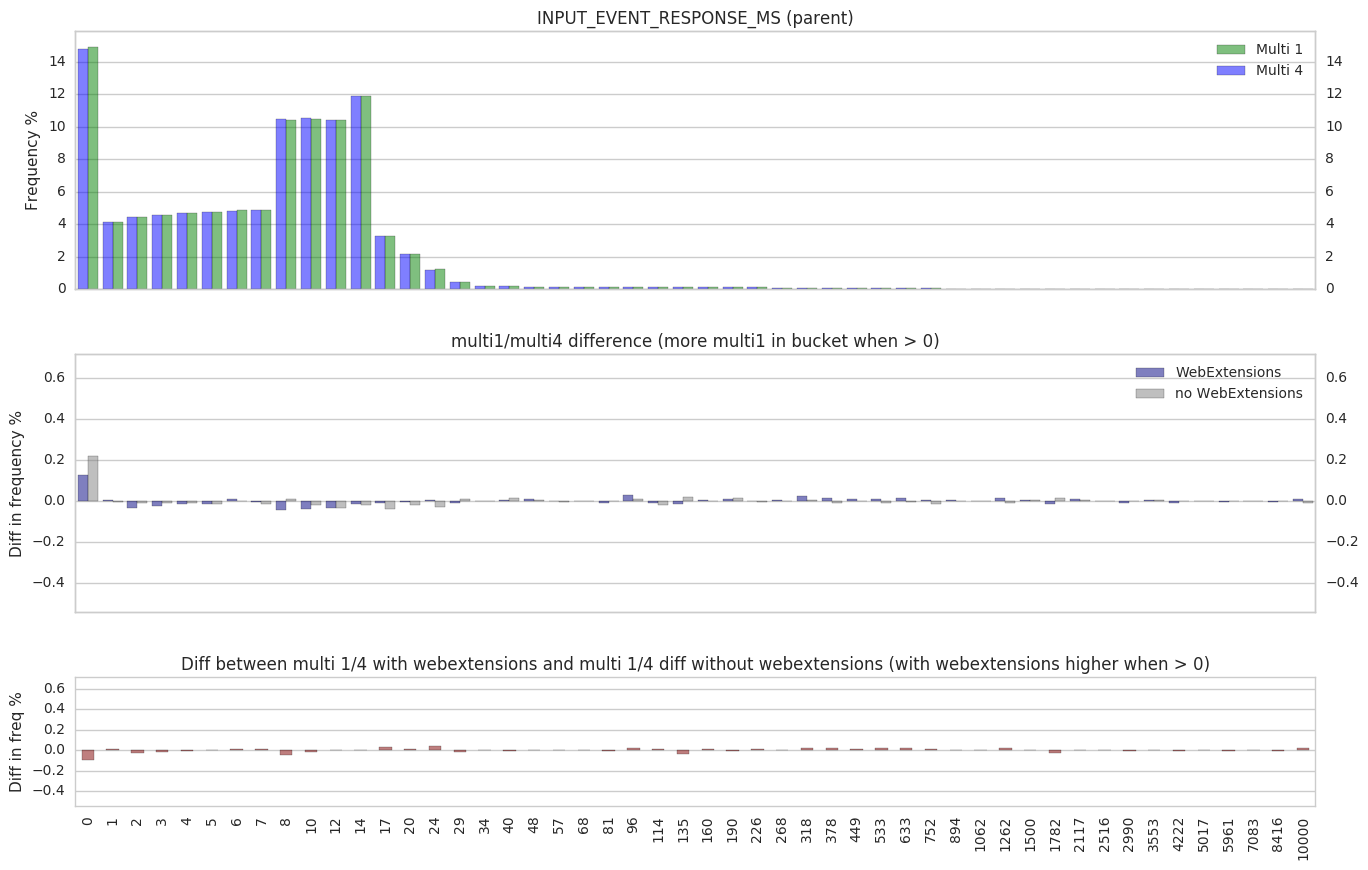

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (with webextensions)
are differing by chance is 0.420.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (parent) (without webextensions)
are differing by chance is 0.674.


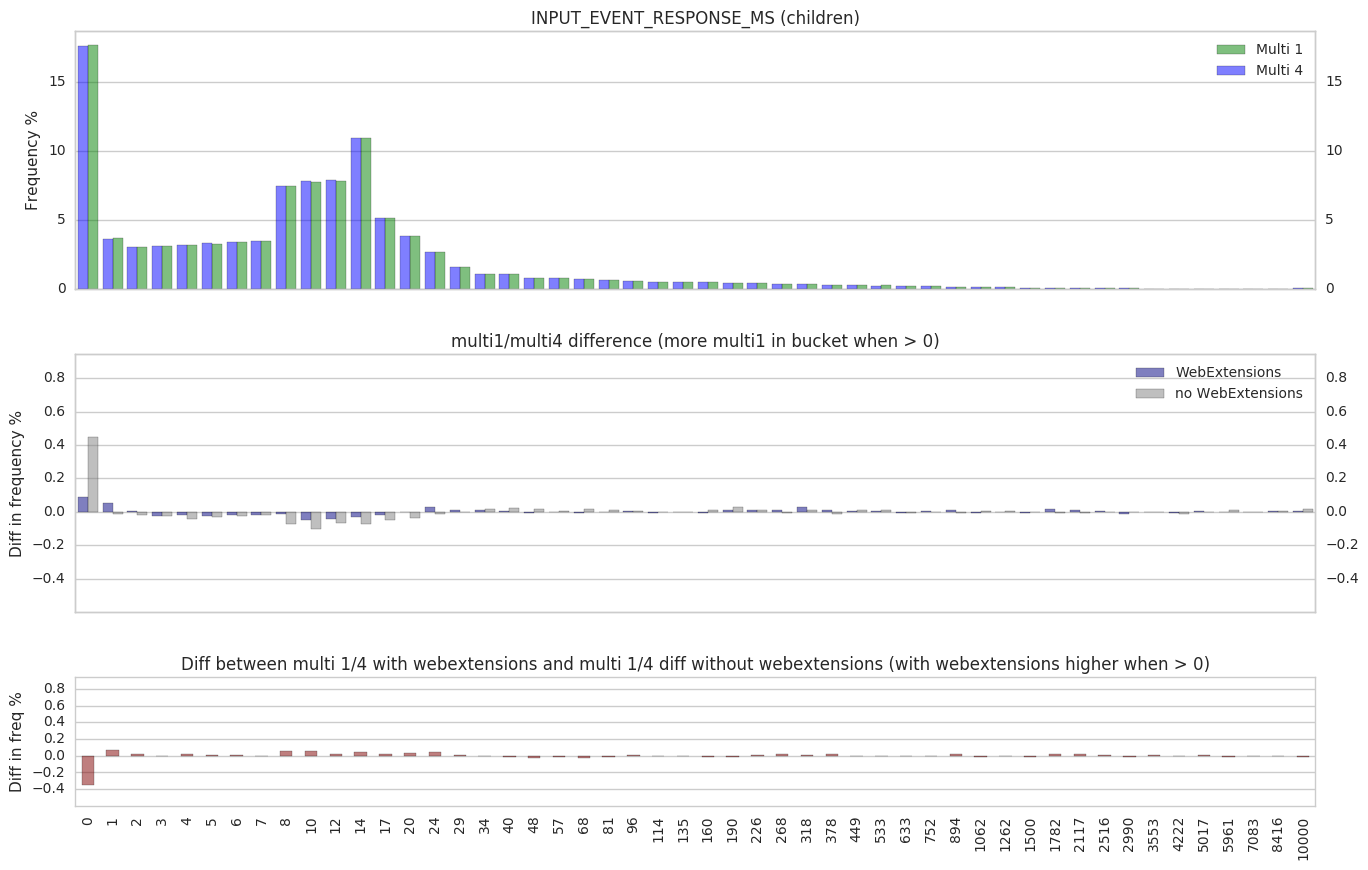

The probability that the distributions for INPUT_EVENT_RESPONSE_MS (children) (with webextensions)
are differing by chance is 0.598.
The probability that the distributions for INPUT_EVENT_RESPONSE_MS (children) (without webextensions)
are differing by chance is 0.158.


In [107]:
ier = compare_histograms(subset, "payload/histograms/INPUT_EVENT_RESPONSE_MS")
results.append(ier)

---

## PageLoad

### FX_PAGE_LOAD_MS

# Darwin

Comparison for FX_PAGE_LOAD_MS (with add-ons):

160 (0.6%) multi_1 profiles have this histogram.
173 (0.7%) multi_4 profiles have this histogram.
126 (0.5%) webext_multi_1 profiles have this histogram.
134 (0.5%) webext_multi_4 profiles have this histogram.
160 (0.6%) multi_1 profiles have the parent histogram.
173 (0.7%) multi_4 profiles have the parent histogram.
126 (0.5%) webext_multi_1 profiles have the parent histogram.
134 (0.5%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


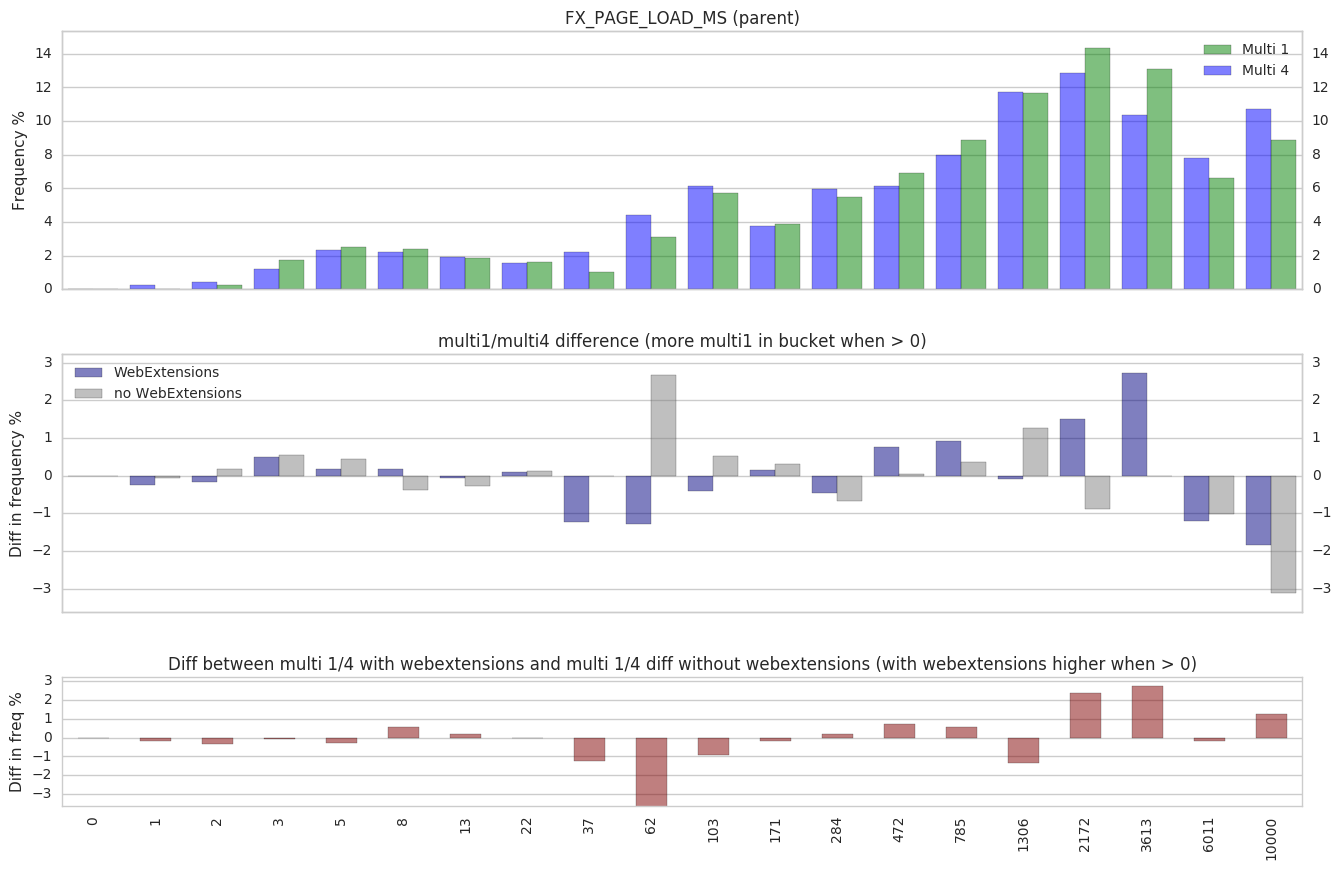

The probability that the distributions for FX_PAGE_LOAD_MS (parent) (with webextensions)
are differing by chance is 0.527.
The probability that the distributions for FX_PAGE_LOAD_MS (parent) (without webextensions)
are differing by chance is 0.218.


# Linux

Comparison for FX_PAGE_LOAD_MS (with add-ons):

6 (0.0%) multi_1 profiles have this histogram.
3 (0.0%) multi_4 profiles have this histogram.
2 (0.0%) webext_multi_1 profiles have this histogram.
2 (0.0%) webext_multi_4 profiles have this histogram.
6 (0.0%) multi_1 profiles have the parent histogram.
3 (0.0%) multi_4 profiles have the parent histogram.
2 (0.0%) webext_multi_1 profiles have the parent histogram.
2 (0.0%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


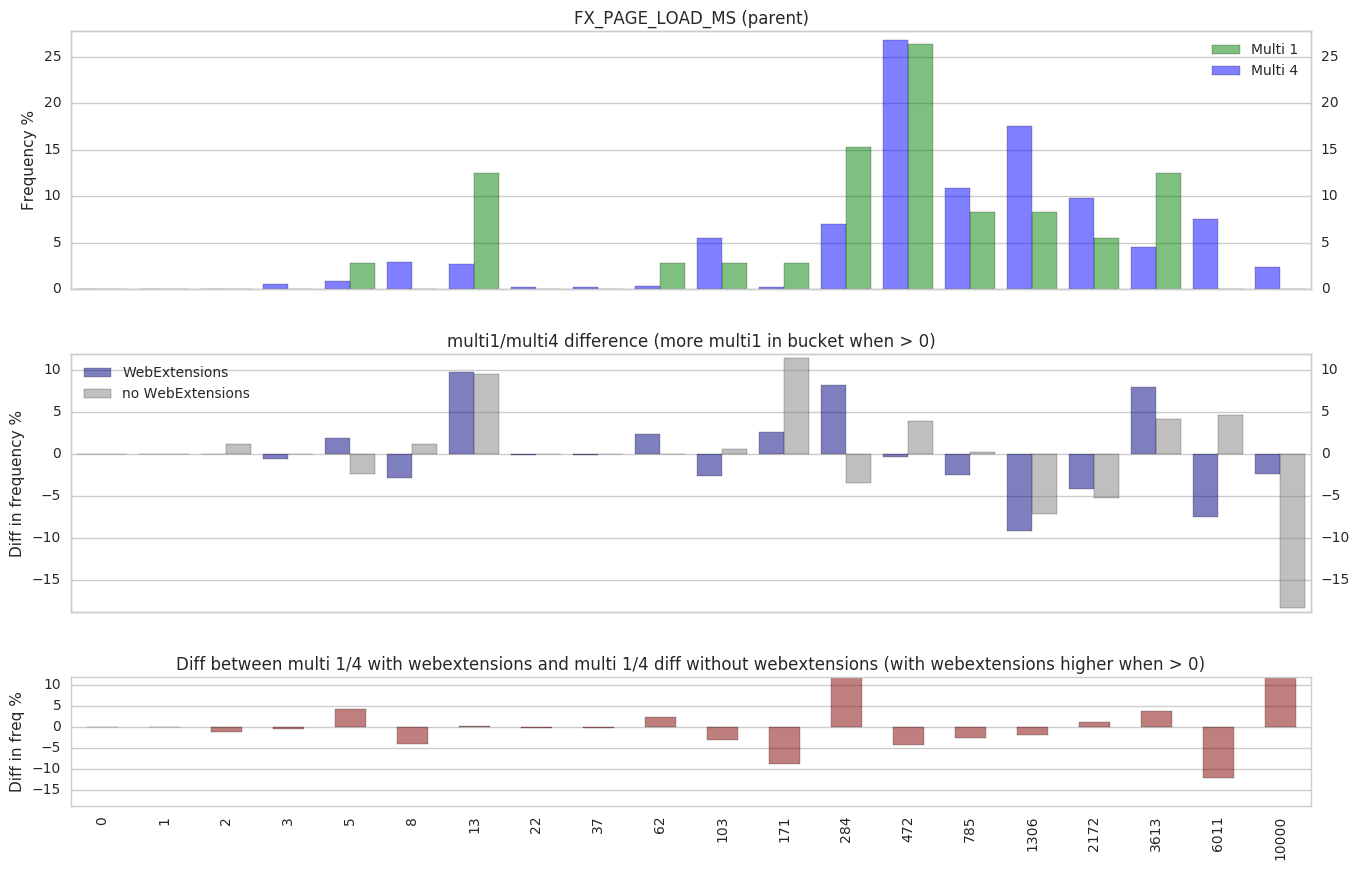

The probability that the distributions for FX_PAGE_LOAD_MS (parent) (with webextensions)
are differing by chance is 1.000.
The probability that the distributions for FX_PAGE_LOAD_MS (parent) (without webextensions)
are differing by chance is 0.848.


# Windows_NT

Comparison for FX_PAGE_LOAD_MS (with add-ons):

26338 (98.8%) multi_1 profiles have this histogram.
25929 (98.8%) multi_4 profiles have this histogram.
26188 (99.0%) webext_multi_1 profiles have this histogram.
26013 (99.0%) webext_multi_4 profiles have this histogram.
26338 (98.8%) multi_1 profiles have the parent histogram.
25929 (98.8%) multi_4 profiles have the parent histogram.
26188 (99.0%) webext_multi_1 profiles have the parent histogram.
26013 (99.0%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


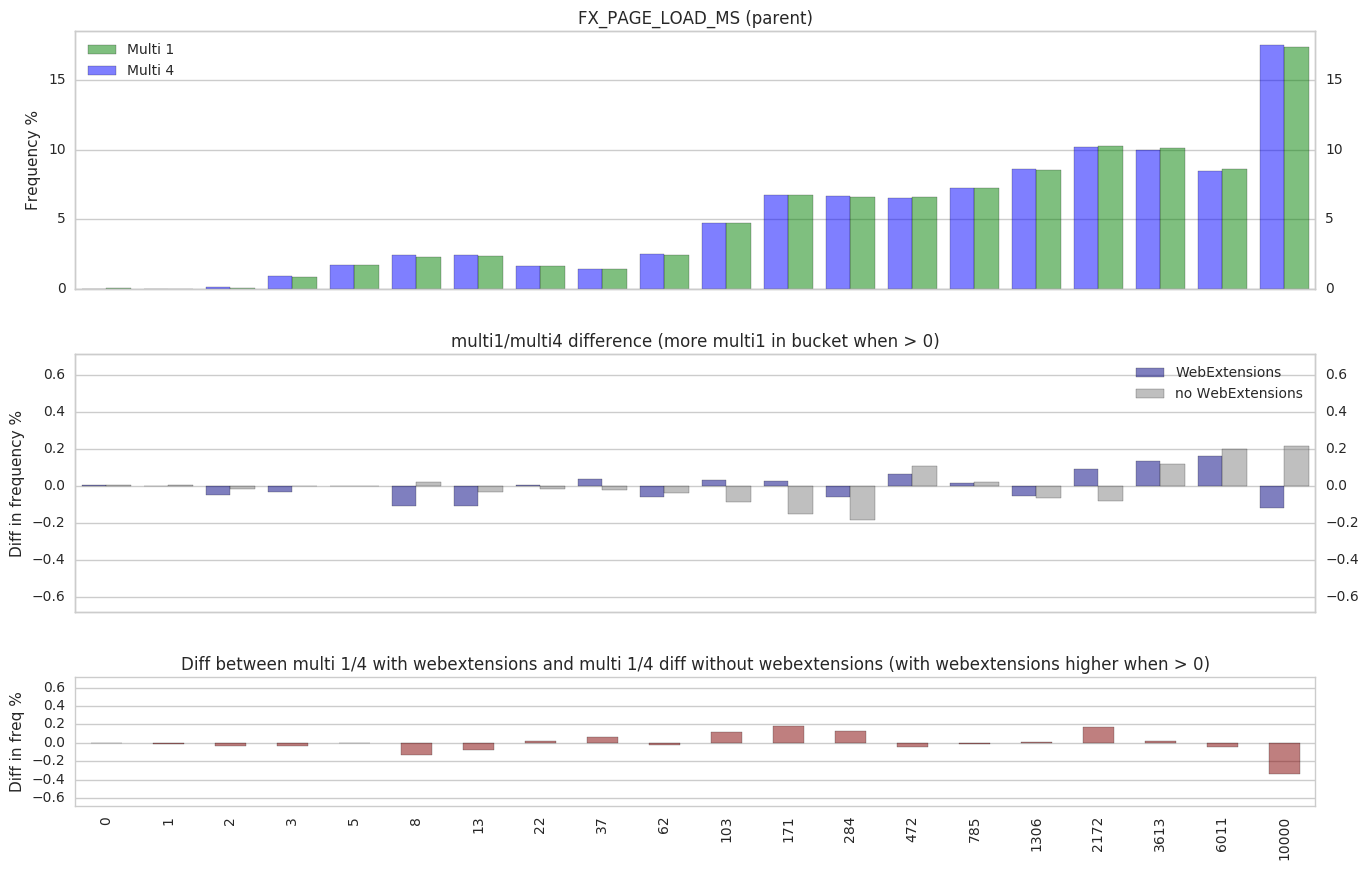

The probability that the distributions for FX_PAGE_LOAD_MS (parent) (with webextensions)
are differing by chance is 0.732.
The probability that the distributions for FX_PAGE_LOAD_MS (parent) (without webextensions)
are differing by chance is 0.443.


In [108]:
fpl = compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")
results.append(fpl)

--- 
## MemoryUsage

### MEMORY_TOTAL 

# Darwin

Comparison for MEMORY_TOTAL (with add-ons):

160 (0.6%) multi_1 profiles have this histogram.
173 (0.7%) multi_4 profiles have this histogram.
126 (0.5%) webext_multi_1 profiles have this histogram.
134 (0.5%) webext_multi_4 profiles have this histogram.
160 (0.6%) multi_1 profiles have the parent histogram.
173 (0.7%) multi_4 profiles have the parent histogram.
126 (0.5%) webext_multi_1 profiles have the parent histogram.
134 (0.5%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


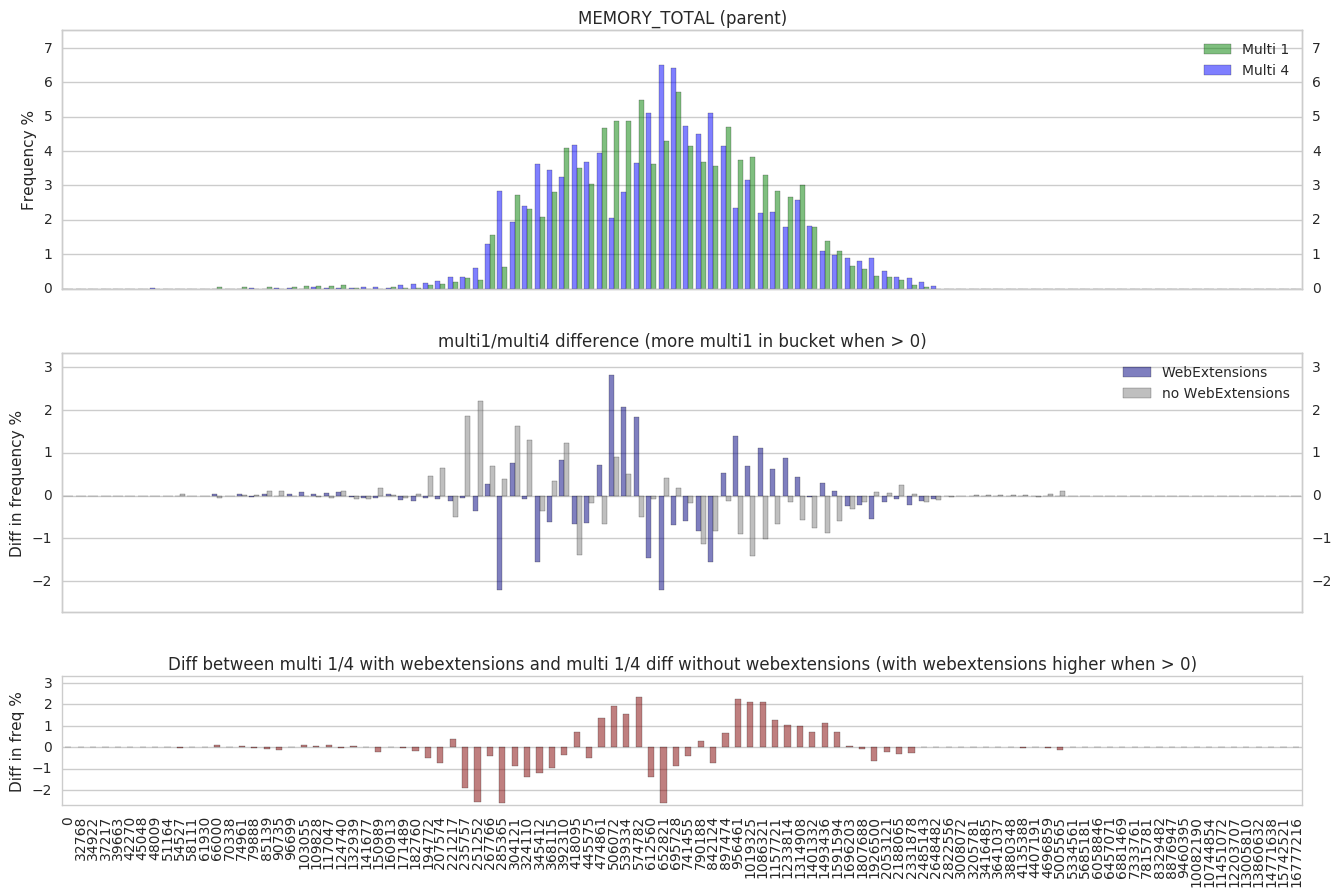

The probability that the distributions for MEMORY_TOTAL (parent) (with webextensions)
are differing by chance is 0.179.
The probability that the distributions for MEMORY_TOTAL (parent) (without webextensions)
are differing by chance is 0.117.


# Linux

Comparison for MEMORY_TOTAL (with add-ons):

6 (0.0%) multi_1 profiles have this histogram.
2 (0.0%) multi_4 profiles have this histogram.
2 (0.0%) webext_multi_1 profiles have this histogram.
2 (0.0%) webext_multi_4 profiles have this histogram.
6 (0.0%) multi_1 profiles have the parent histogram.
2 (0.0%) multi_4 profiles have the parent histogram.
2 (0.0%) webext_multi_1 profiles have the parent histogram.
2 (0.0%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


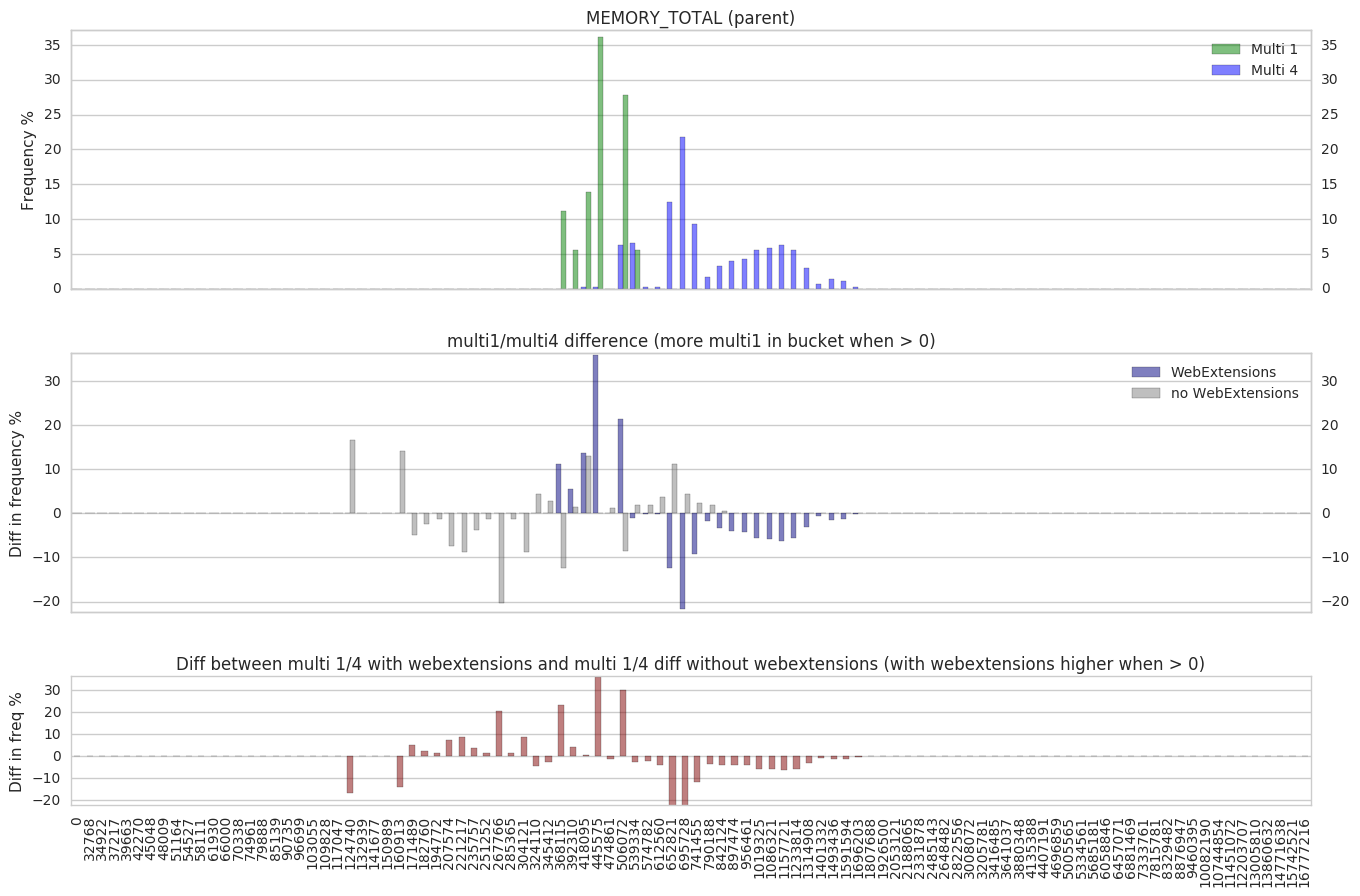

The probability that the distributions for MEMORY_TOTAL (parent) (with webextensions)
are differing by chance is 0.304.
The probability that the distributions for MEMORY_TOTAL (parent) (without webextensions)
are differing by chance is 0.495.


# Windows_NT

Comparison for MEMORY_TOTAL (with add-ons):

26305 (98.7%) multi_1 profiles have this histogram.
25900 (98.7%) multi_4 profiles have this histogram.
26139 (98.8%) webext_multi_1 profiles have this histogram.
25984 (98.8%) webext_multi_4 profiles have this histogram.
26305 (98.7%) multi_1 profiles have the parent histogram.
25900 (98.7%) multi_4 profiles have the parent histogram.
26139 (98.8%) webext_multi_1 profiles have the parent histogram.
25984 (98.8%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


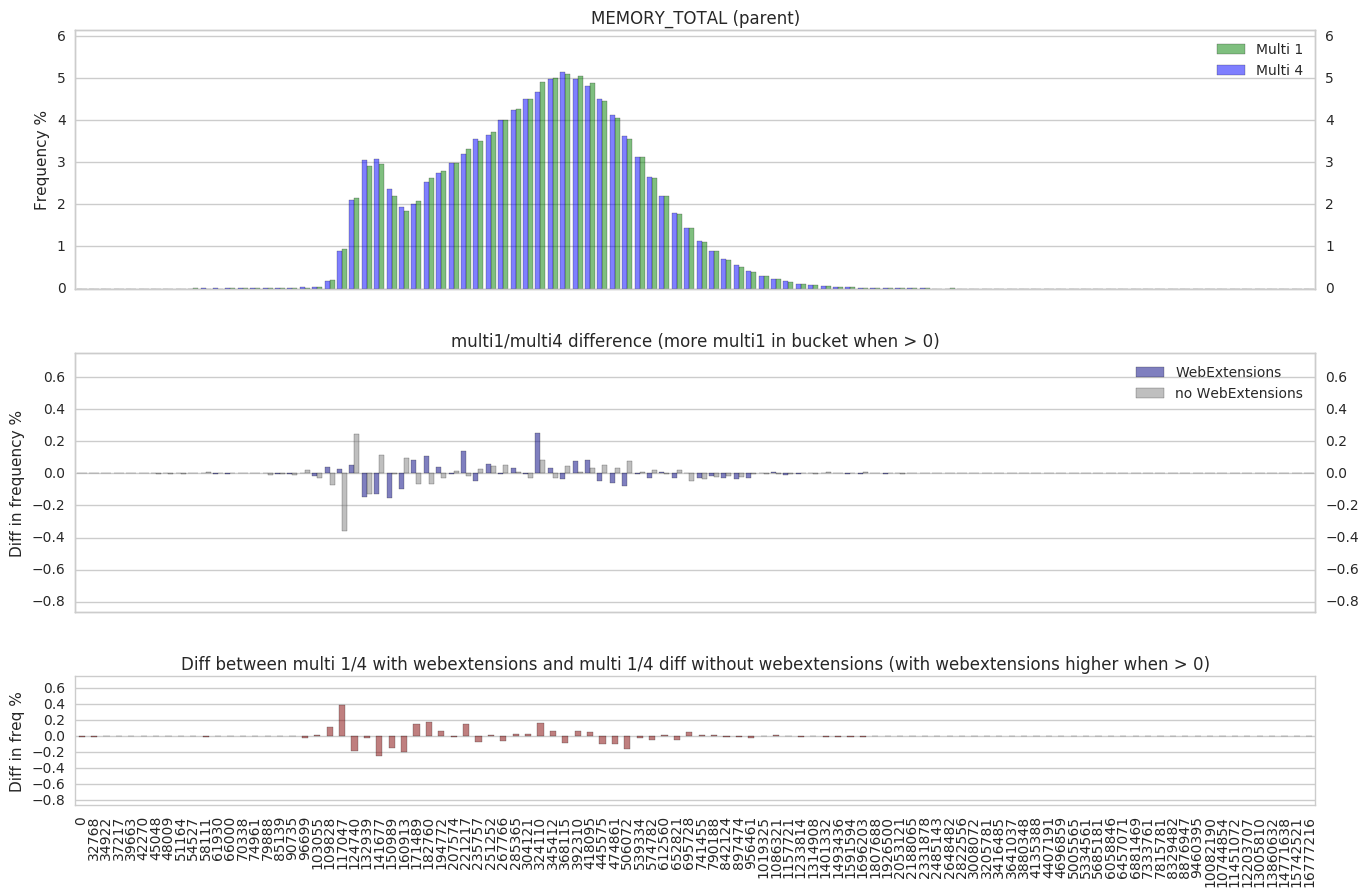

The probability that the distributions for MEMORY_TOTAL (parent) (with webextensions)
are differing by chance is 0.946.
The probability that the distributions for MEMORY_TOTAL (parent) (without webextensions)
are differing by chance is 0.814.


In [109]:
mt = compare_histograms(subset, "payload/histograms/MEMORY_TOTAL")
results.append(mt)

### MEMORY_VSIZE_MAX_CONTIGUOUS 

# Darwin

Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


# Linux

Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


# Windows_NT

Comparison for MEMORY_VSIZE_MAX_CONTIGUOUS (with add-ons):

26495 (99.4%) multi_1 profiles have this histogram.
26076 (99.3%) multi_4 profiles have this histogram.
26326 (99.5%) webext_multi_1 profiles have this histogram.
26151 (99.5%) webext_multi_4 profiles have this histogram.
26495 (99.4%) multi_1 profiles have the parent histogram.
26076 (99.3%) multi_4 profiles have the parent histogram.
26326 (99.5%) webext_multi_1 profiles have the parent histogram.
26151 (99.5%) webextx_multi_4 profiles have the parent histogram.
22429 (84.1%) multi_1 profiles have the child histogram.
22014 (83.9%) multi_4 profiles have the child histogram.
22487 (85.0%) webext_multi_1 profiles have the child histogram.
22268 (84.7%) webextx_multi_4 profiles have the child histogram.


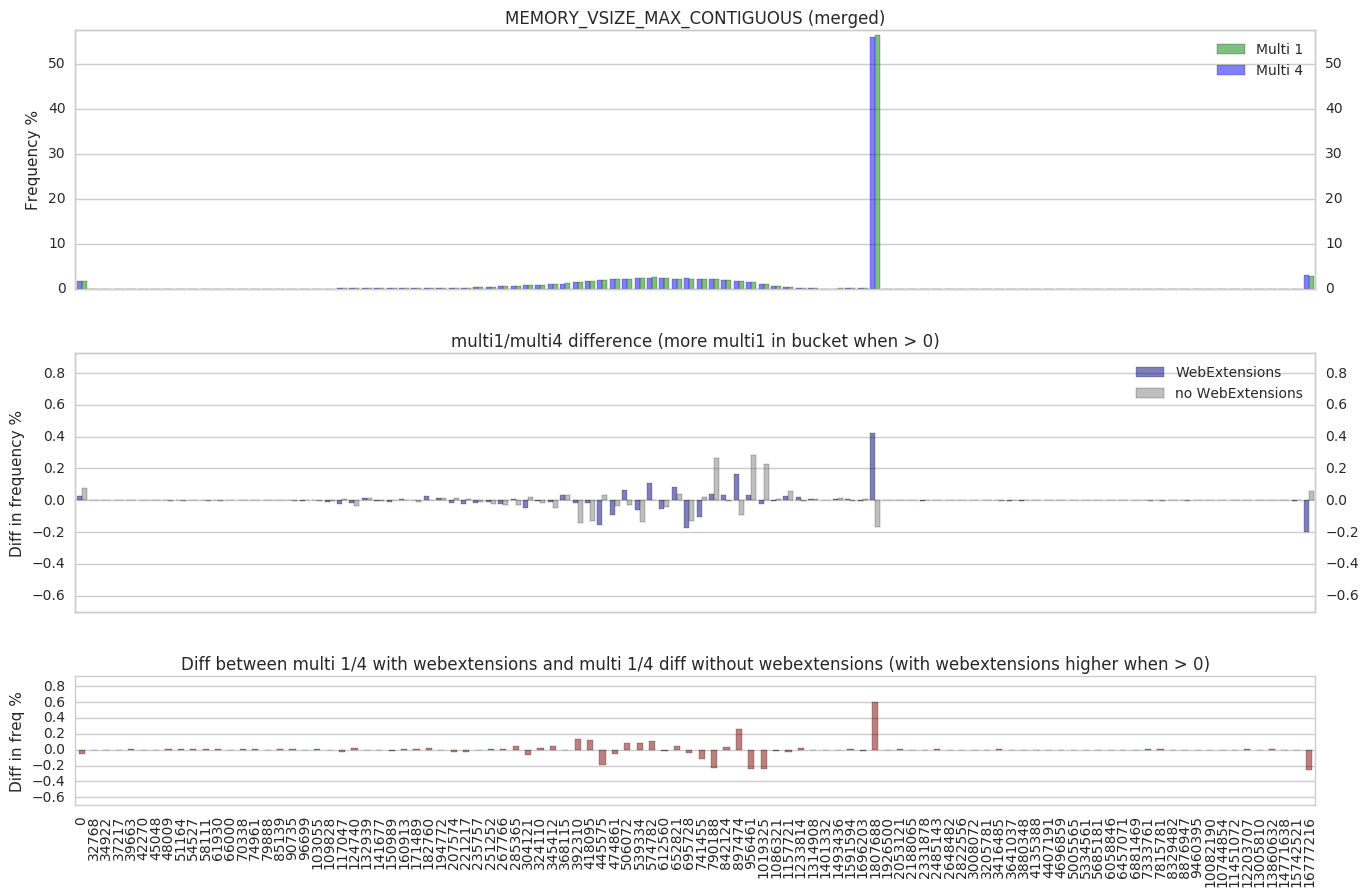

The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (merged) (with webextensions)
are differing by chance is 0.259.
The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (merged) (without webextensions)
are differing by chance is 0.858.


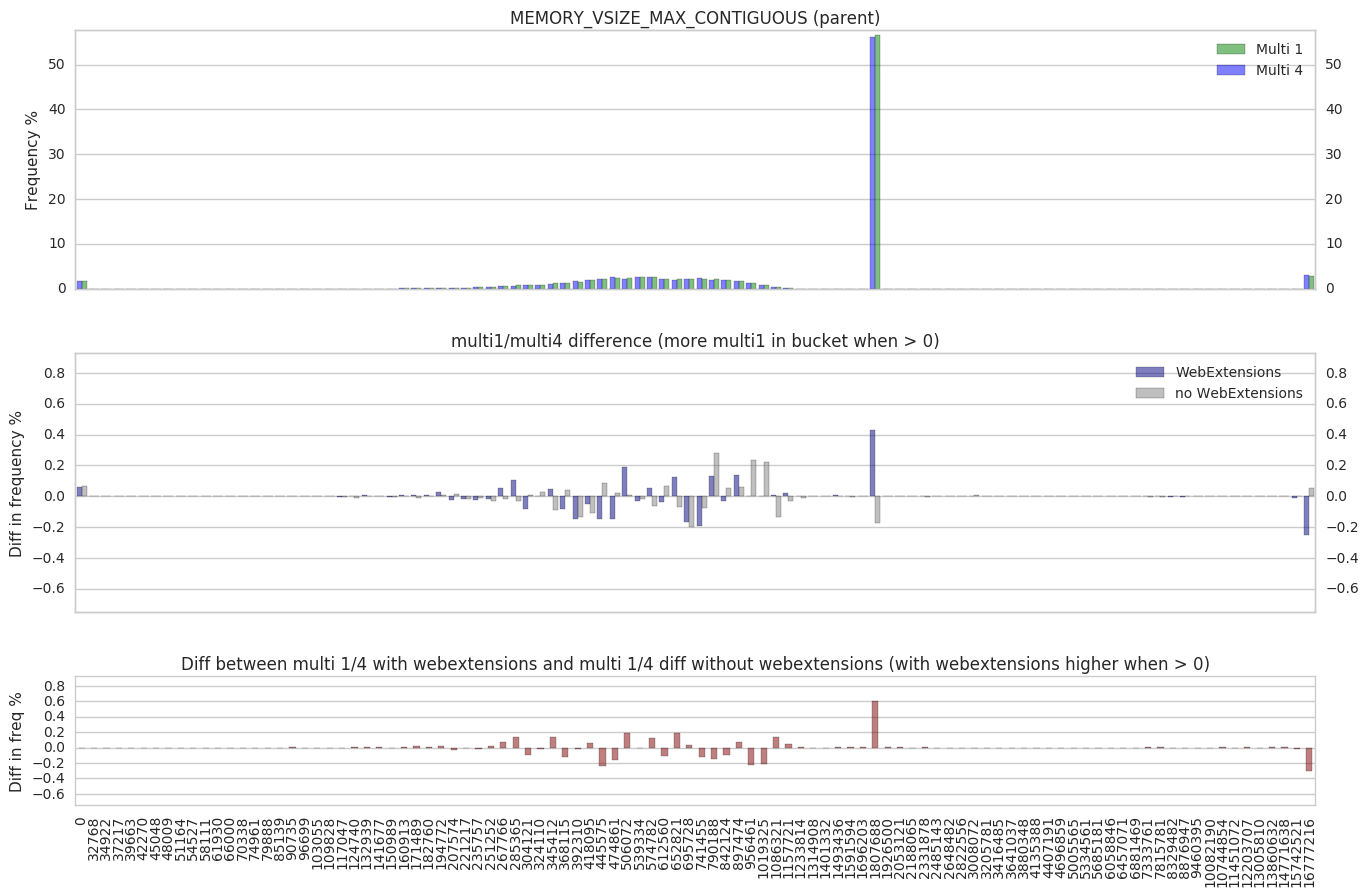

The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (parent) (with webextensions)
are differing by chance is 0.500.
The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (parent) (without webextensions)
are differing by chance is 0.970.


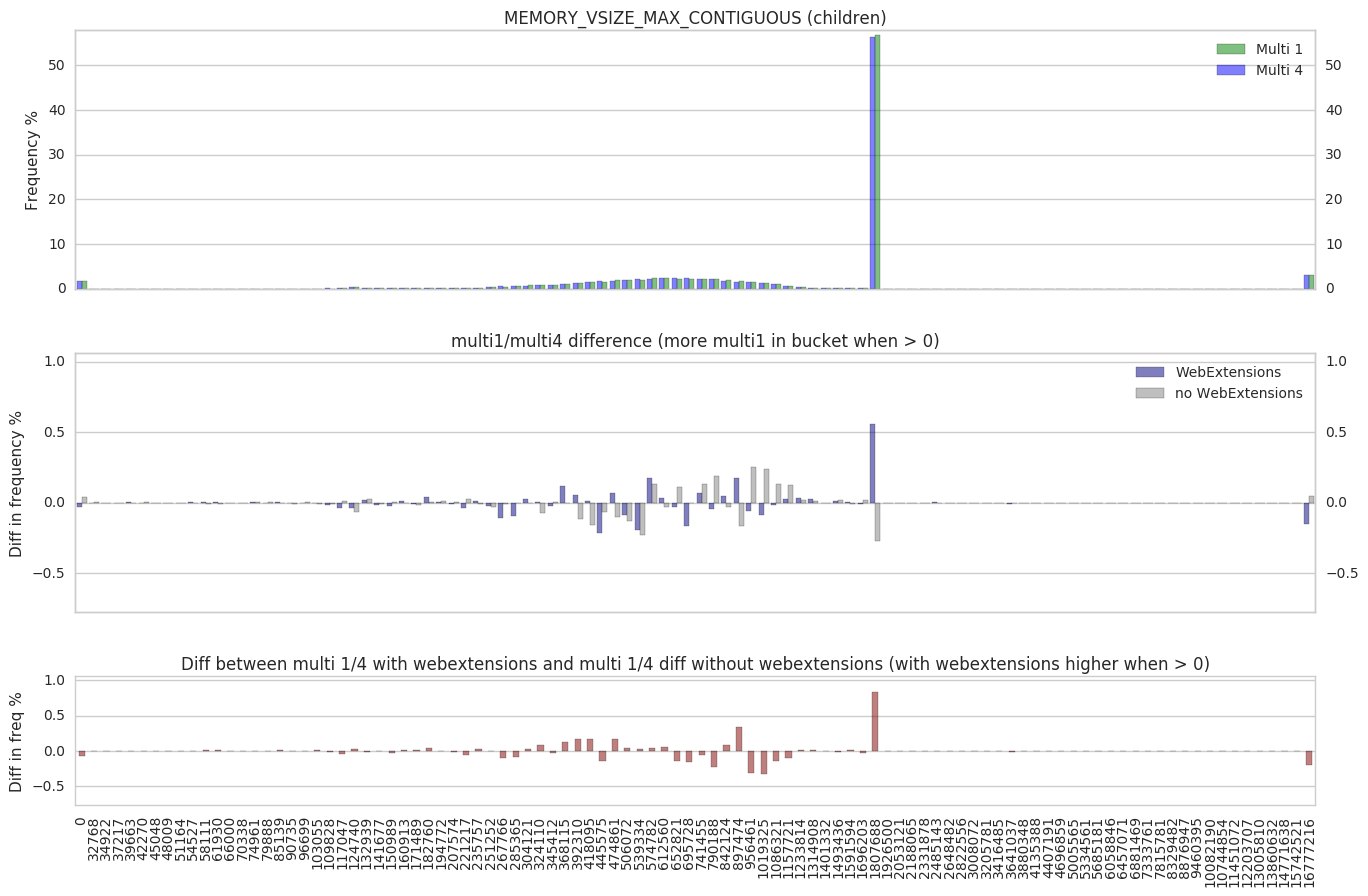

The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (children) (with webextensions)
are differing by chance is 0.312.
The probability that the distributions for MEMORY_VSIZE_MAX_CONTIGUOUS (children) (without webextensions)
are differing by chance is 0.641.


In [110]:
mvmc = compare_histograms(subset, "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS")
results.append(mvmc)

### MEMORY_DISTRIBUTION_AMONG_CONTENT

In [111]:
mdac = compare_histograms(subset, "payload/histograms/MEMORY_DISTRIBUTION_AMONG_CONTENT")
results.append(mdac)

# Darwin

Comparison for MEMORY_DISTRIBUTION_AMONG_CONTENT (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


# Linux

Comparison for MEMORY_DISTRIBUTION_AMONG_CONTENT (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


# Windows_NT

Comparison for MEMORY_DISTRIBUTION_AMONG_CONTENT (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


---
## TabSwitching

### FX_TAB_SWITCH_TOTAL_MS

# Darwin

Comparison for FX_TAB_SWITCH_TOTAL_MS (with add-ons):

104 (0.4%) multi_1 profiles have this histogram.
121 (0.5%) multi_4 profiles have this histogram.
93 (0.4%) webext_multi_1 profiles have this histogram.
87 (0.3%) webext_multi_4 profiles have this histogram.
104 (0.4%) multi_1 profiles have the parent histogram.
121 (0.5%) multi_4 profiles have the parent histogram.
93 (0.4%) webext_multi_1 profiles have the parent histogram.
87 (0.3%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


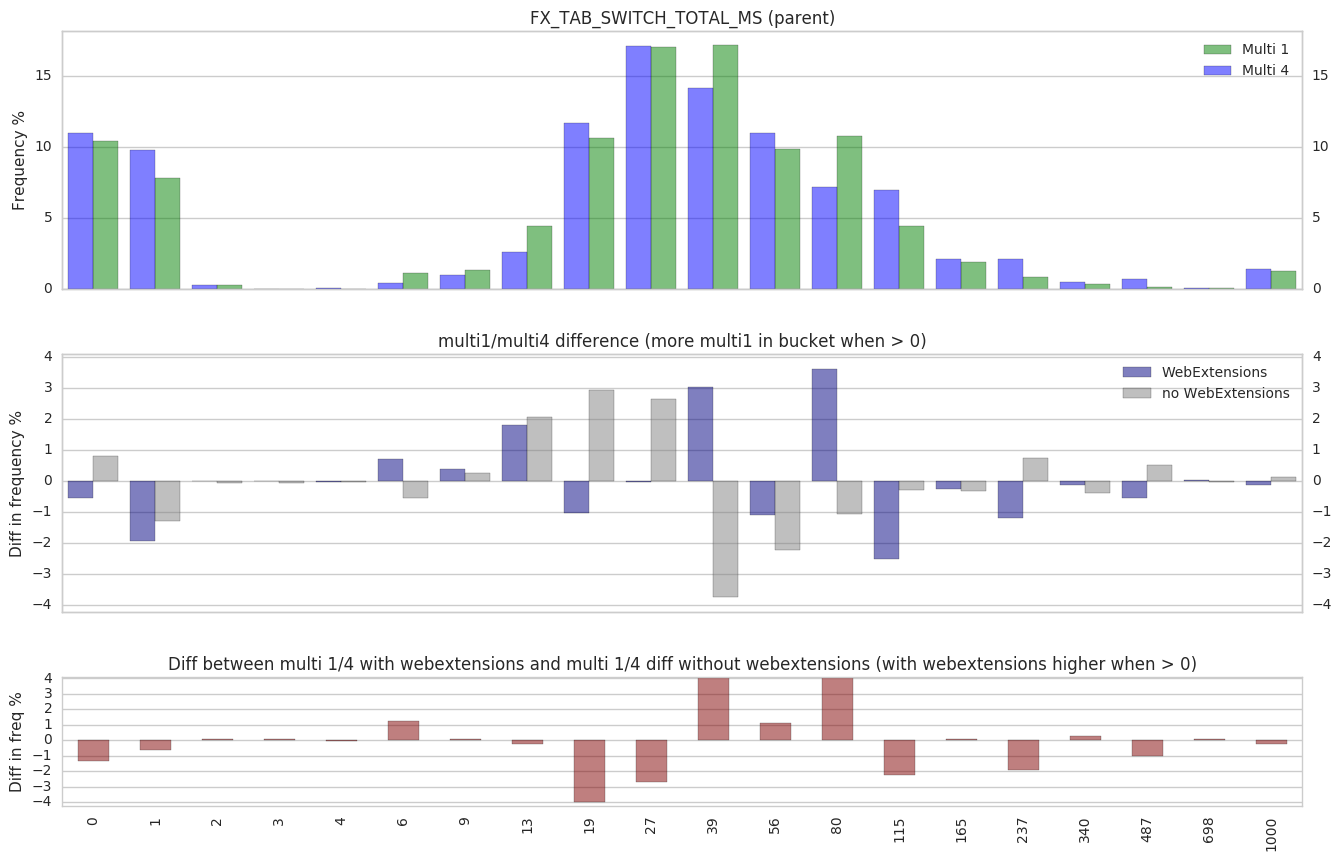

The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (with webextensions)
are differing by chance is 0.554.
The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (without webextensions)
are differing by chance is 0.814.


# Linux

Comparison for FX_TAB_SWITCH_TOTAL_MS (with add-ons):

4 (0.0%) multi_1 profiles have this histogram.
2 (0.0%) multi_4 profiles have this histogram.
1 (0.0%) webext_multi_1 profiles have this histogram.
2 (0.0%) webext_multi_4 profiles have this histogram.
4 (0.0%) multi_1 profiles have the parent histogram.
2 (0.0%) multi_4 profiles have the parent histogram.
1 (0.0%) webext_multi_1 profiles have the parent histogram.
2 (0.0%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


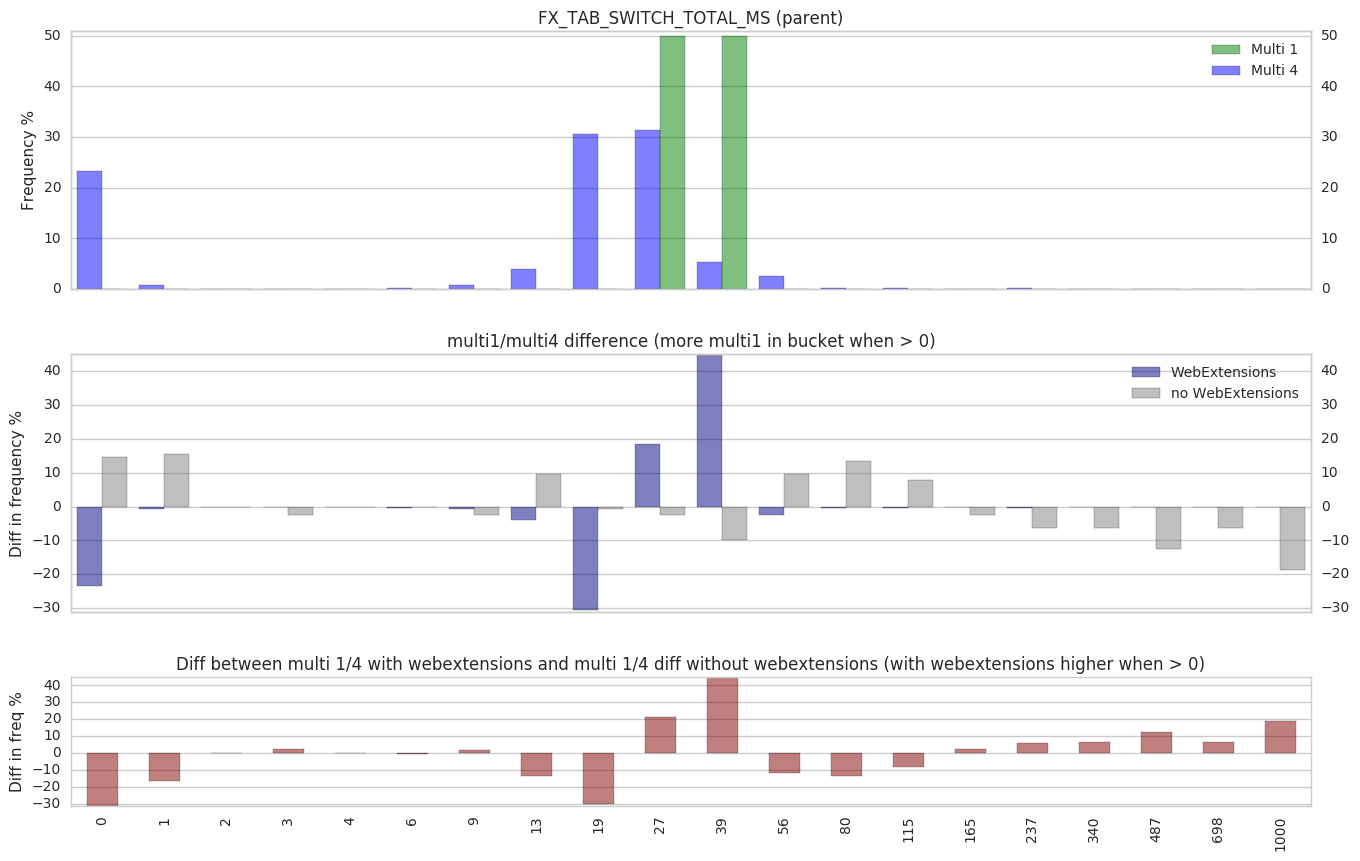

The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (with webextensions)
are differing by chance is 0.304.
The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (without webextensions)
are differing by chance is 0.728.


# Windows_NT

Comparison for FX_TAB_SWITCH_TOTAL_MS (with add-ons):

14418 (54.1%) multi_1 profiles have this histogram.
14090 (53.7%) multi_4 profiles have this histogram.
15967 (60.4%) webext_multi_1 profiles have this histogram.
15882 (60.4%) webext_multi_4 profiles have this histogram.
14418 (54.1%) multi_1 profiles have the parent histogram.
14090 (53.7%) multi_4 profiles have the parent histogram.
15967 (60.4%) webext_multi_1 profiles have the parent histogram.
15882 (60.4%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


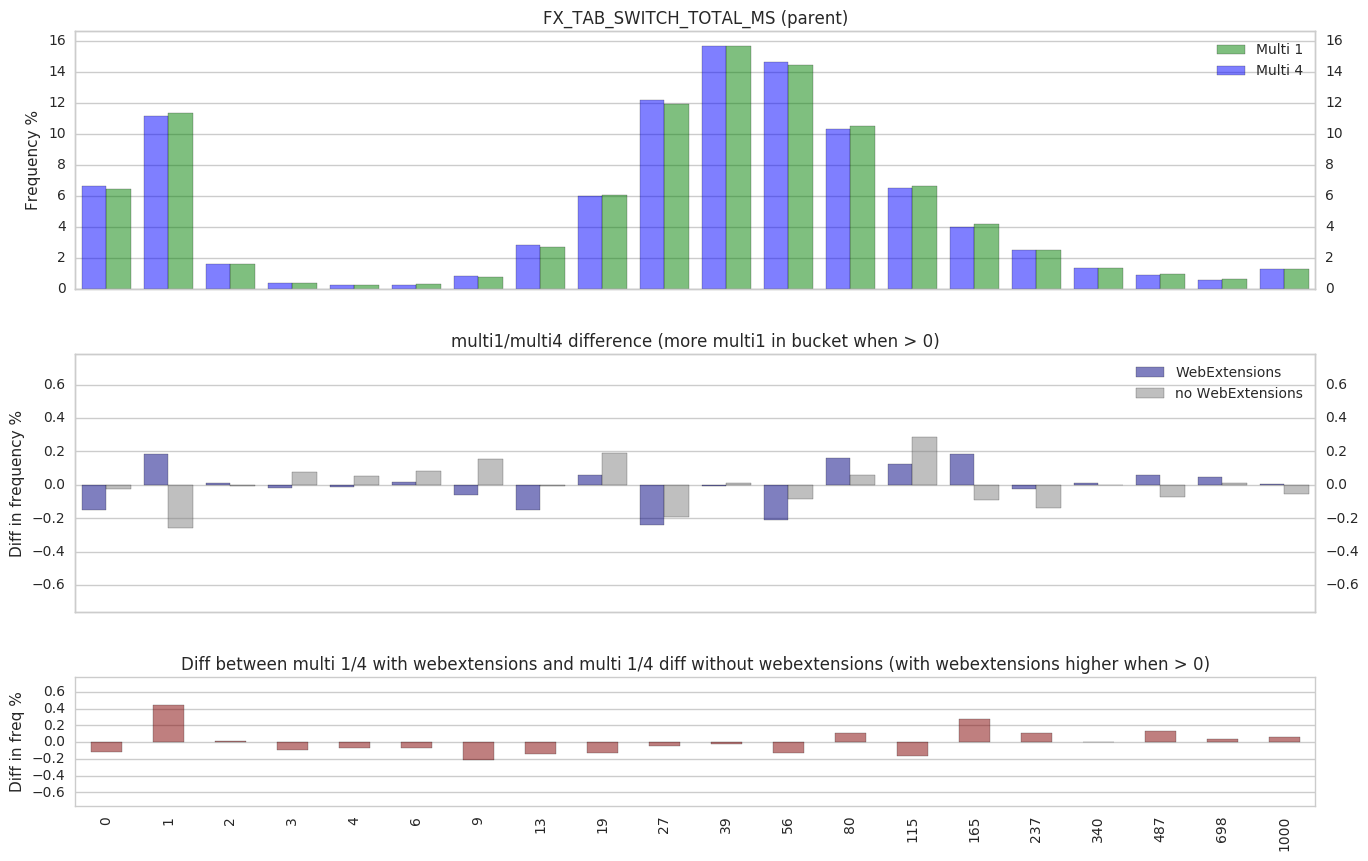

The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (with webextensions)
are differing by chance is 0.661.
The probability that the distributions for FX_TAB_SWITCH_TOTAL_MS (parent) (without webextensions)
are differing by chance is 0.099.


In [112]:
ftst = compare_histograms(subset, "payload/histograms/FX_TAB_SWITCH_TOTAL_MS")
results.append(ftst)

### FX_TAB_SWITCH_UPDATE_MS 

# Darwin

Comparison for FX_TAB_SWITCH_UPDATE_MS (with add-ons):

104 (0.4%) multi_1 profiles have this histogram.
121 (0.5%) multi_4 profiles have this histogram.
93 (0.4%) webext_multi_1 profiles have this histogram.
87 (0.3%) webext_multi_4 profiles have this histogram.
104 (0.4%) multi_1 profiles have the parent histogram.
121 (0.5%) multi_4 profiles have the parent histogram.
93 (0.4%) webext_multi_1 profiles have the parent histogram.
87 (0.3%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


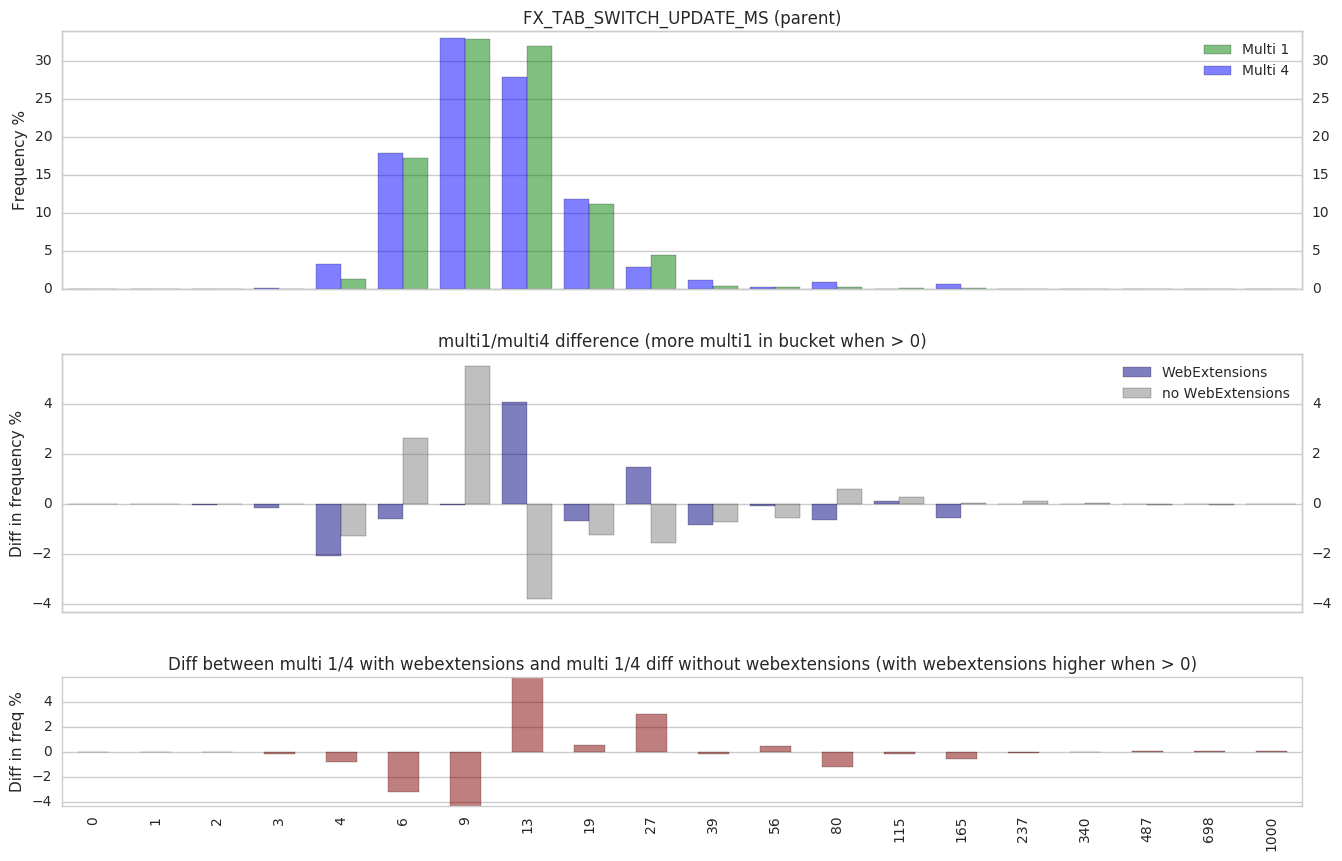

The probability that the distributions for FX_TAB_SWITCH_UPDATE_MS (parent) (with webextensions)
are differing by chance is 0.643.
The probability that the distributions for FX_TAB_SWITCH_UPDATE_MS (parent) (without webextensions)
are differing by chance is 0.818.


# Linux

Comparison for FX_TAB_SWITCH_UPDATE_MS (with add-ons):

4 (0.0%) multi_1 profiles have this histogram.
2 (0.0%) multi_4 profiles have this histogram.
1 (0.0%) webext_multi_1 profiles have this histogram.
2 (0.0%) webext_multi_4 profiles have this histogram.
4 (0.0%) multi_1 profiles have the parent histogram.
2 (0.0%) multi_4 profiles have the parent histogram.
1 (0.0%) webext_multi_1 profiles have the parent histogram.
2 (0.0%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


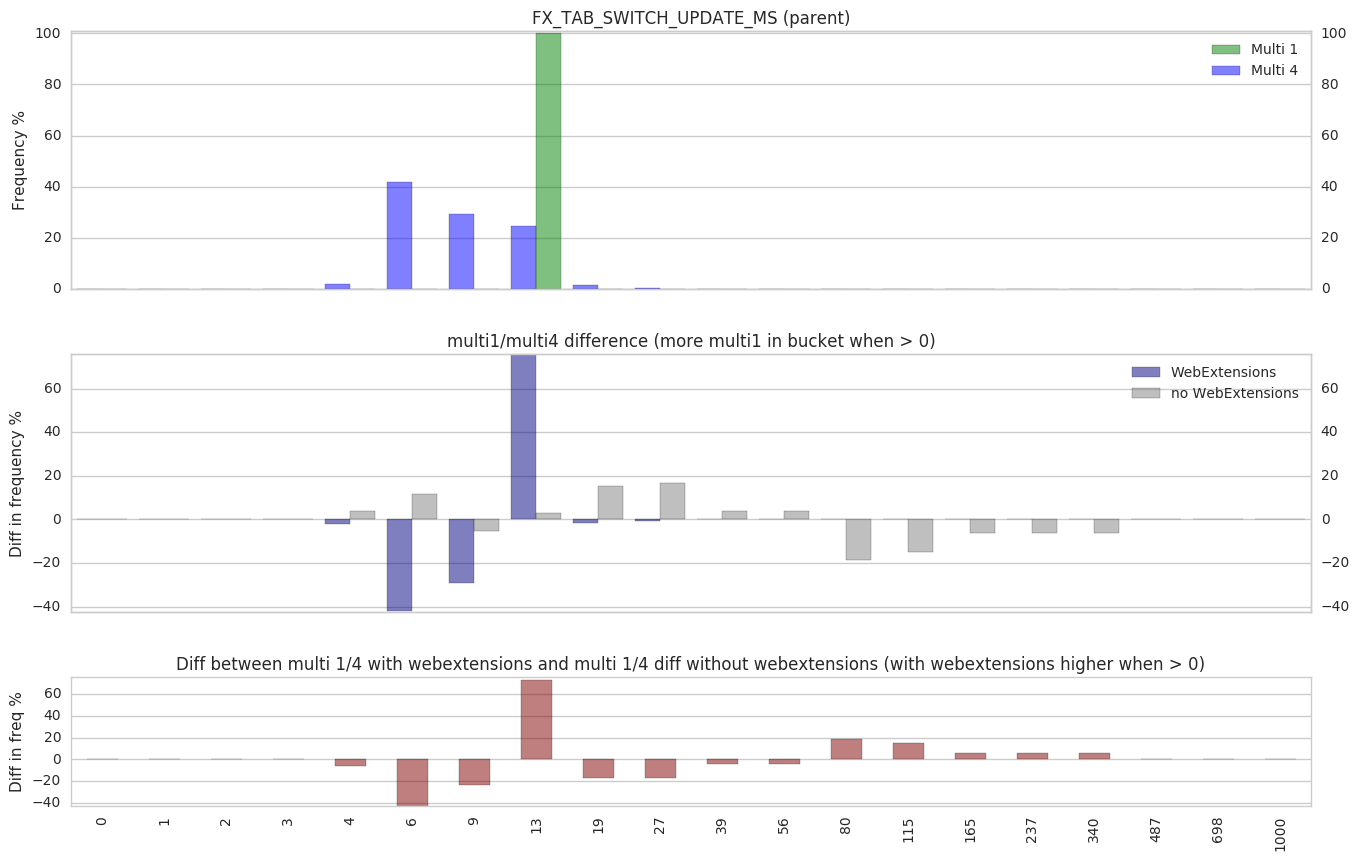

The probability that the distributions for FX_TAB_SWITCH_UPDATE_MS (parent) (with webextensions)
are differing by chance is 0.312.
The probability that the distributions for FX_TAB_SWITCH_UPDATE_MS (parent) (without webextensions)
are differing by chance is 0.799.


# Windows_NT

Comparison for FX_TAB_SWITCH_UPDATE_MS (with add-ons):

14467 (54.3%) multi_1 profiles have this histogram.
14148 (53.9%) multi_4 profiles have this histogram.
16014 (60.5%) webext_multi_1 profiles have this histogram.
15934 (60.6%) webext_multi_4 profiles have this histogram.
14467 (54.3%) multi_1 profiles have the parent histogram.
14148 (53.9%) multi_4 profiles have the parent histogram.
16014 (60.5%) webext_multi_1 profiles have the parent histogram.
15934 (60.6%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


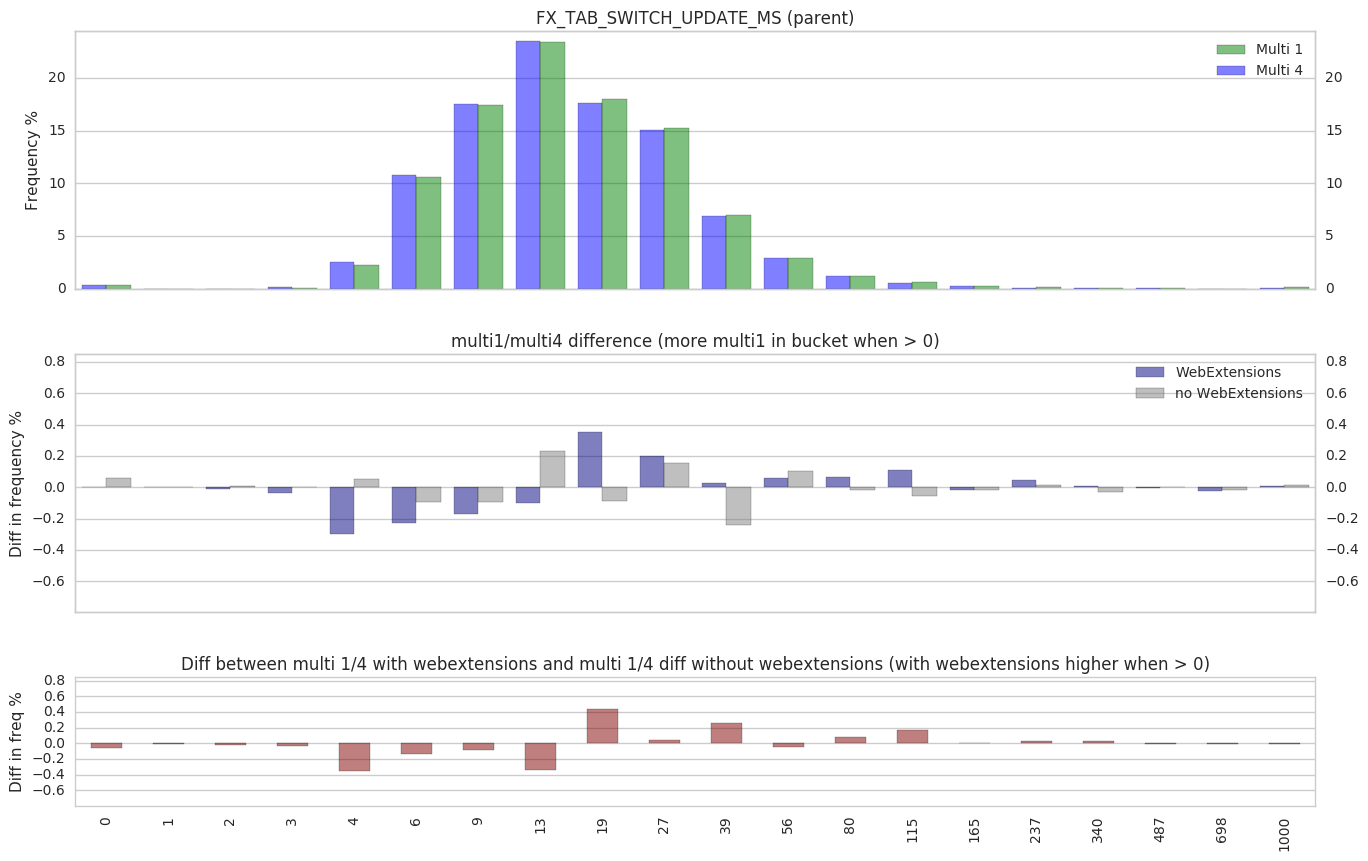

The probability that the distributions for FX_TAB_SWITCH_UPDATE_MS (parent) (with webextensions)
are differing by chance is 0.214.
The probability that the distributions for FX_TAB_SWITCH_UPDATE_MS (parent) (without webextensions)
are differing by chance is 0.363.


In [113]:
ftsu = compare_histograms(subset, "payload/histograms/FX_TAB_SWITCH_UPDATE_MS")
results.append(ftsu)

### FX_TAB_SWITCH_SPINNER_VISIBLE_MS 

# Darwin

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_MS (with add-ons):

37 (0.1%) multi_1 profiles have this histogram.
46 (0.2%) multi_4 profiles have this histogram.
24 (0.1%) webext_multi_1 profiles have this histogram.
30 (0.1%) webext_multi_4 profiles have this histogram.
37 (0.1%) multi_1 profiles have the parent histogram.
46 (0.2%) multi_4 profiles have the parent histogram.
24 (0.1%) webext_multi_1 profiles have the parent histogram.
30 (0.1%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


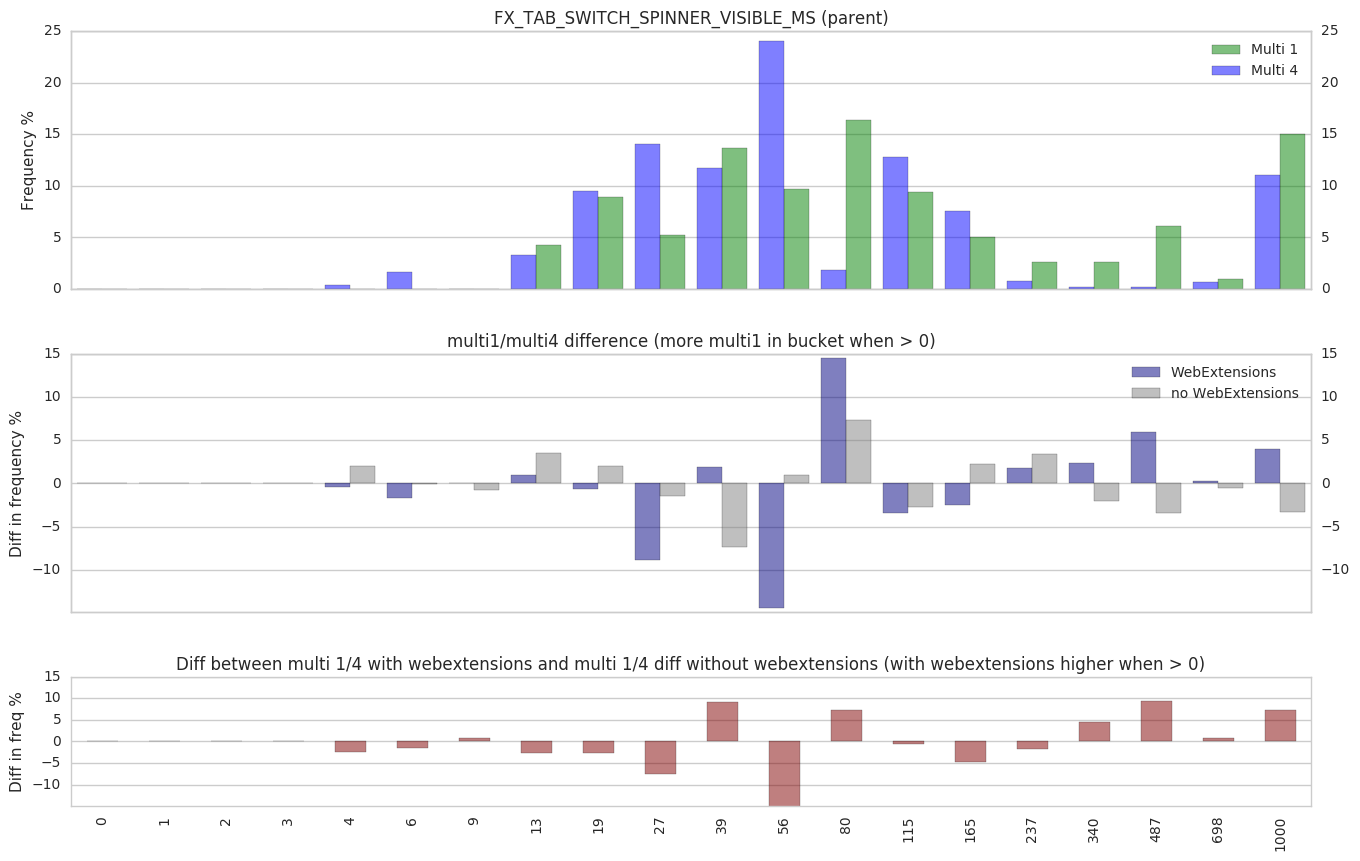

The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) (with webextensions)
are differing by chance is 0.196.
The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) (without webextensions)
are differing by chance is 0.938.


# Linux

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_MS (with add-ons):

No multi_1 profiles have this histogram.
1 (0.0%) multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No multi_1 profiles have the parent histogram.
1 (0.0%) multi_4 profiles have the parent histogram.
No webext_multi_1 profiles have the parent histogram.
No webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


# Windows_NT

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_MS (with add-ons):

4271 (16.0%) multi_1 profiles have this histogram.
4306 (16.4%) multi_4 profiles have this histogram.
5635 (21.3%) webext_multi_1 profiles have this histogram.
5630 (21.4%) webext_multi_4 profiles have this histogram.
4271 (16.0%) multi_1 profiles have the parent histogram.
4306 (16.4%) multi_4 profiles have the parent histogram.
5635 (21.3%) webext_multi_1 profiles have the parent histogram.
5630 (21.4%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


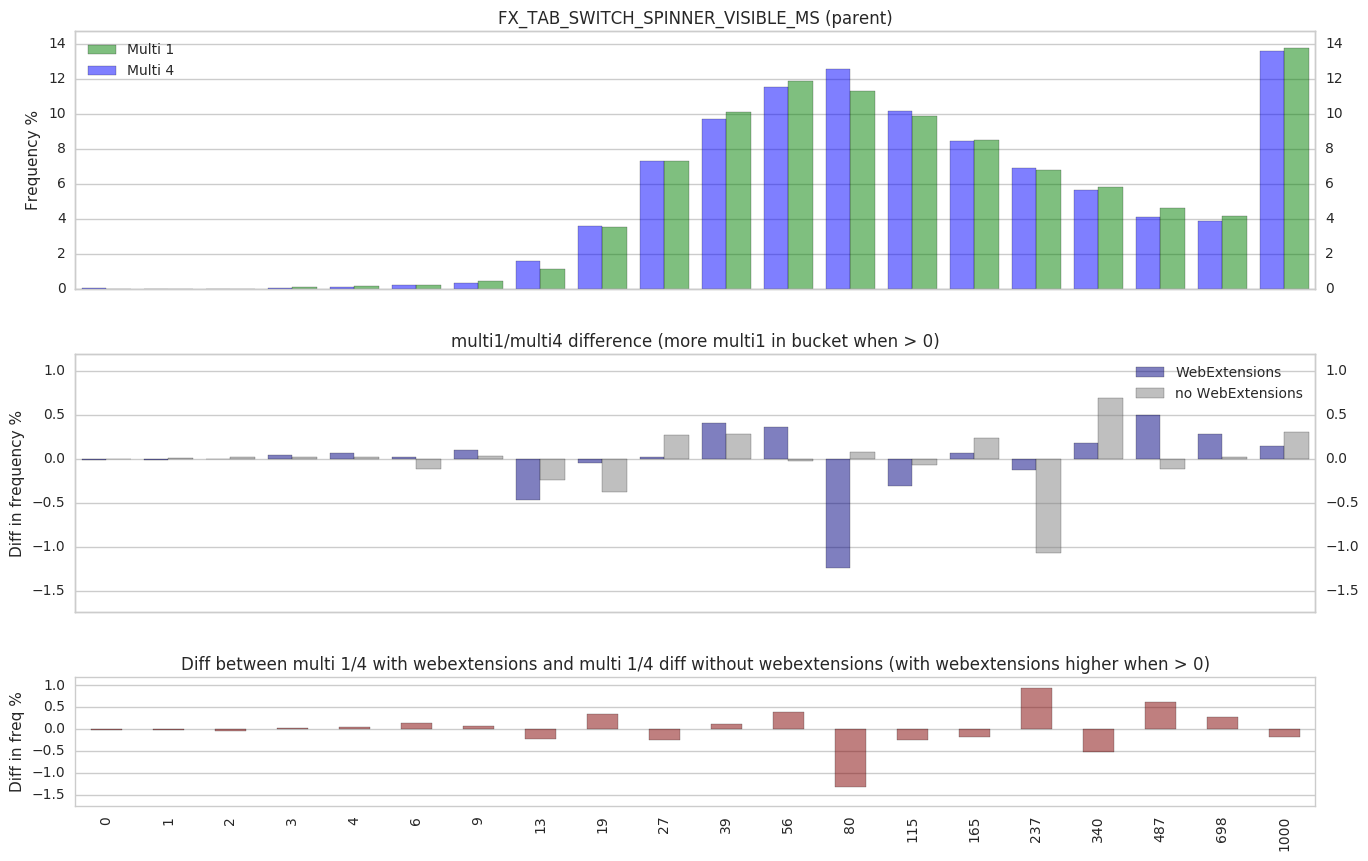

The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) (with webextensions)
are differing by chance is 0.304.
The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent) (without webextensions)
are differing by chance is 0.911.


In [114]:
ftssv = compare_histograms(subset, "payload/histograms/FX_TAB_SWITCH_SPINNER_VISIBLE_MS")
results.append(ftssv)

### FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS

# Darwin

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (with add-ons):

37 (0.1%) multi_1 profiles have this histogram.
46 (0.2%) multi_4 profiles have this histogram.
24 (0.1%) webext_multi_1 profiles have this histogram.
30 (0.1%) webext_multi_4 profiles have this histogram.
37 (0.1%) multi_1 profiles have the parent histogram.
46 (0.2%) multi_4 profiles have the parent histogram.
24 (0.1%) webext_multi_1 profiles have the parent histogram.
30 (0.1%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


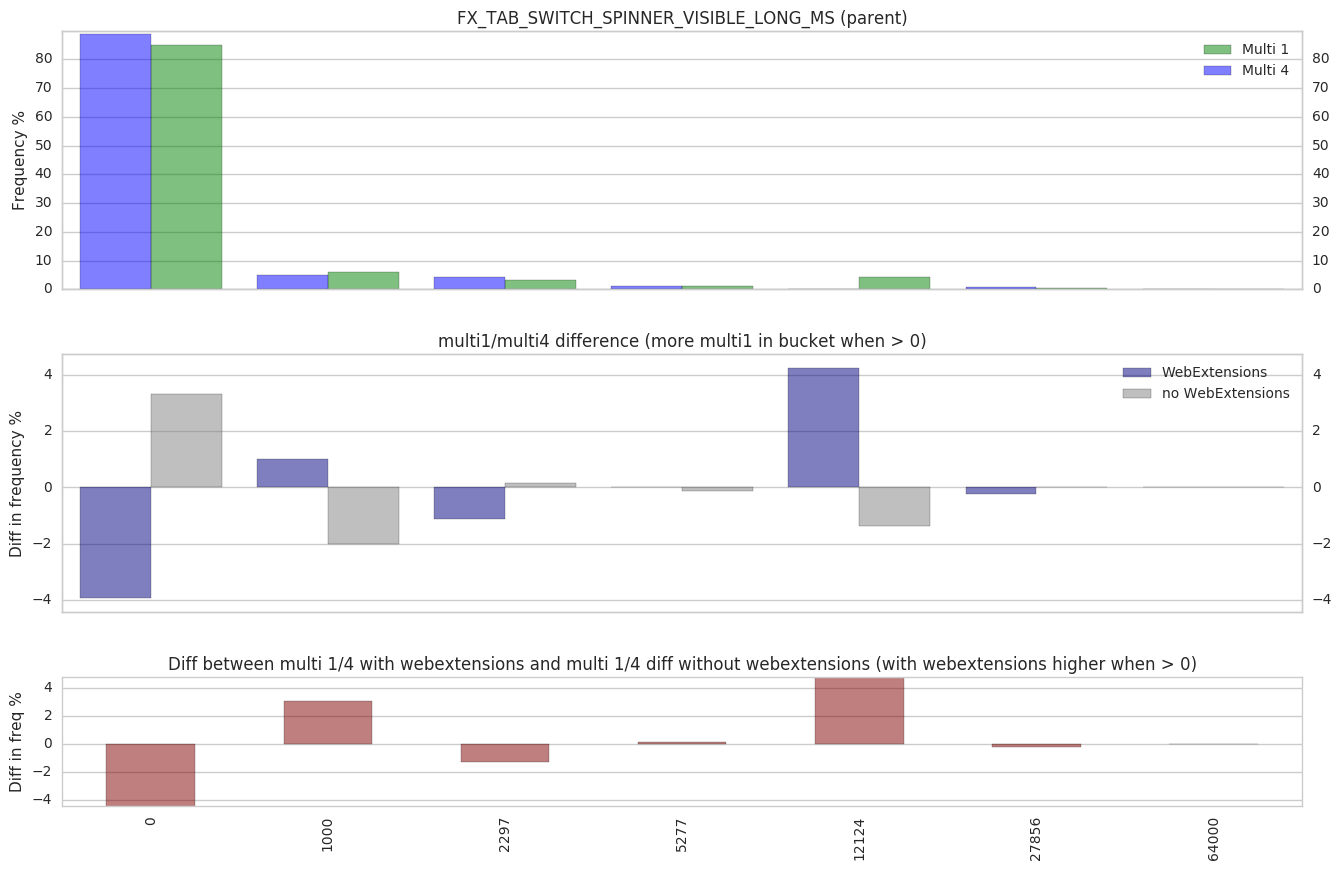

The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) (with webextensions)
are differing by chance is 0.652.
The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) (without webextensions)
are differing by chance is 0.665.


# Linux

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (with add-ons):

No multi_1 profiles have this histogram.
1 (0.0%) multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No multi_1 profiles have the parent histogram.
1 (0.0%) multi_4 profiles have the parent histogram.
No webext_multi_1 profiles have the parent histogram.
No webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


# Windows_NT

Comparison for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (with add-ons):

4271 (16.0%) multi_1 profiles have this histogram.
4306 (16.4%) multi_4 profiles have this histogram.
5635 (21.3%) webext_multi_1 profiles have this histogram.
5630 (21.4%) webext_multi_4 profiles have this histogram.
4271 (16.0%) multi_1 profiles have the parent histogram.
4306 (16.4%) multi_4 profiles have the parent histogram.
5635 (21.3%) webext_multi_1 profiles have the parent histogram.
5630 (21.4%) webextx_multi_4 profiles have the parent histogram.
No multi_1 profiles have the child histogram.
No multi_4 profiles have the child histogram.
No webext_multi_1 profiles have the child histogram.
No webextx_multi_4 profiles have the child histogram.


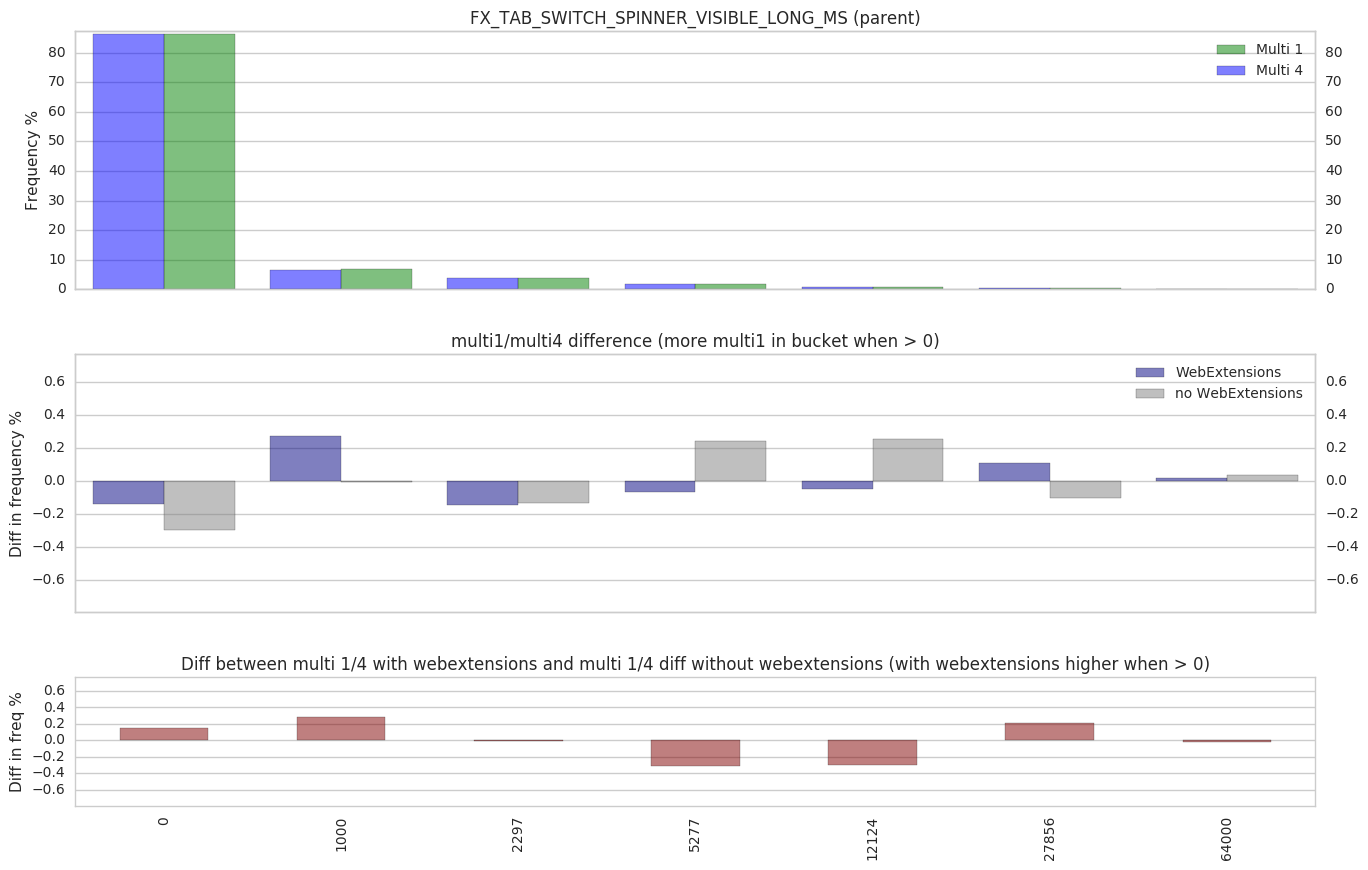

The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) (with webextensions)
are differing by chance is 0.536.
The probability that the distributions for FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent) (without webextensions)
are differing by chance is 0.213.


In [115]:
ftssvl = compare_histograms(subset, "payload/histograms/FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS")
results.append(ftssvl)

### FX_TAB_REMOTE_NAVIGATION_DELAY_MS 

In [116]:
ftrnd = compare_histograms(subset, "payload/histograms/FX_TAB_REMOTE_NAVIGATION_DELAY_MS")
results.append(ftrnd)

# Darwin

Comparison for FX_TAB_REMOTE_NAVIGATION_DELAY_MS (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


# Linux

Comparison for FX_TAB_REMOTE_NAVIGATION_DELAY_MS (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


# Windows_NT

Comparison for FX_TAB_REMOTE_NAVIGATION_DELAY_MS (with add-ons):

No multi_1 profiles have this histogram.
No multi_4 profiles have this histogram.
No webext_multi_1 profiles have this histogram.
No webext_multi_4 profiles have this histogram.
No hists found


---

## SlowScripts

### SLOW_SCRIPT_NOTICE_COUNT

In [117]:
ssnc = compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")
results.append(ssnc)

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_NOTICE_COUNT (with add-ons):

2 (0.0%) Multi 4 profiles (with webextenisons) have this histogram.
3 (0.0%) Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTICE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.172 units different from median with 4 processes.
- This is a relative difference of 184.4%.
- Multi 1 group median is 0.2645, Multi 4 group median is 0.093.

(with webextensions) The probability of this difference occurring purely by chance is 0.510.

For cohorts with no webextensions, median with 1 content process is 0.0149 units (58.3%) different from median with 4 processes
- This is a relative difference of 58.3%.
- Multi 1 group median is 0.04047, Multi 4 group median is 0.02557.

(without webextensions) The probability of this difference occurring purely by chance is 0.421.


---

# Linux

Comparison for count histogram SLOW_SCRIPT_NOTICE_COUNT (with add-ons):

No Multi 4 profiles (with webextenisons) have this histogram.
No Multi 1 profiles (with webextensions) have this histogram.


---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_NOTICE_COUNT (with add-ons):

811 (3.1%) Multi 4 profiles (with webextenisons) have this histogram.
764 (2.9%) Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTICE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.0645 units different from median with 4 processes.
- This is a relative difference of 9.8%.
- Multi 1 group median is 0.7241, Multi 4 group median is 0.6596.

(with webextensions) The probability of this difference occurring purely by chance is 0.334.

For cohorts with no webextensions, median with 1 content process is 0.0543 units (11.7%) different from median with 4 processes
- This is a relative difference of 11.7%.
- Multi 1 group median is 0.5181, Multi 4 group median is 0.4638.

(without webextensions) The probability of this difference occurring purely by chance is 0.444.


### SLOW_SCRIPT_PAGE_COUNT

In [118]:
sspc = compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")
results.append(sspc)

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT (with add-ons):

2 (0.0%) Multi 4 profiles (with webextenisons) have this histogram.
3 (0.0%) Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with webextensions):

- Median with 1 content process is -0.0233 units different from median with 4 processes.
- This is a relative difference of -35.7%.
- Multi 1 group median is 0.04206, Multi 4 group median is 0.06541.

(with webextensions) The probability of this difference occurring purely by chance is 1.000.

For cohorts with no webextensions, median with 1 content process is 0.0265 units (188.8%) different from median with 4 processes
- This is a relative difference of 188.8%.
- Multi 1 group median is 0.04047, Multi 4 group median is 0.01401.

(without webextensions) The probability of this difference occurring purely by chance is 0.324.


---

# Linux

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT (with add-ons):

No Multi 4 profiles (with webextenisons) have this histogram.
No Multi 1 profiles (with webextensions) have this histogram.


---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_PAGE_COUNT (with add-ons):

775 (2.9%) Multi 4 profiles (with webextenisons) have this histogram.
737 (2.8%) Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with webextensions):

- Median with 1 content process is 0.0262 units different from median with 4 processes.
- This is a relative difference of 5.8%.
- Multi 1 group median is 0.4786, Multi 4 group median is 0.4524.

(with webextensions) The probability of this difference occurring purely by chance is 0.585.

For cohorts with no webextensions, median with 1 content process is 0.0652 units (20.1%) different from median with 4 processes
- This is a relative difference of 20.1%.
- Multi 1 group median is 0.3904, Multi 4 group median is 0.3252.

(without webextensions) The probability of this difference occurring purely by chance is 0.182.


---
### SLOW_SCRIPT_NOTIFY_DELAY

In [119]:
ssnd = compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY")
results.append(ssnd)

---

# Darwin

Comparison for count histogram SLOW_SCRIPT_NOTIFY_DELAY (with add-ons):

2 (0.0%) Multi 4 profiles (with webextenisons) have this histogram.
3 (0.0%) Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTIFY_DELAY per hour (with webextensions):

- Median with 1 content process is 0 units different from median with 4 processes.
- This is a relative difference of nan%.
- Multi 1 group median is 0, Multi 4 group median is 0.

(with webextensions) The probability of this difference occurring purely by chance is 1.000.

For cohorts with no webextensions, median with 1 content process is 0 units (nan%) different from median with 4 processes
- This is a relative difference of nan%.
- Multi 1 group median is 0, Multi 4 group median is 0.

(without webextensions) The probability of this difference occurring purely by chance is 1.000.


---

# Linux

Comparison for count histogram SLOW_SCRIPT_NOTIFY_DELAY (with add-ons):

No Multi 4 profiles (with webextenisons) have this histogram.
No Multi 1 profiles (with webextensions) have this histogram.


---

# Windows_NT

Comparison for count histogram SLOW_SCRIPT_NOTIFY_DELAY (with add-ons):

752 (2.9%) Multi 4 profiles (with webextenisons) have this histogram.
709 (2.7%) Multi 1 profiles (with webextensions) have this histogram.

Comparison for SLOW_SCRIPT_NOTIFY_DELAY per hour (with webextensions):

- Median with 1 content process is 6.85 units different from median with 4 processes.
- This is a relative difference of 41.3%.
- Multi 1 group median is 23.44, Multi 4 group median is 16.59.

(with webextensions) The probability of this difference occurring purely by chance is 0.488.

For cohorts with no webextensions, median with 1 content process is -8.14 units (-39.4%) different from median with 4 processes
- This is a relative difference of -39.4%.
- Multi 1 group median is 12.54, Multi 4 group median is 20.67.

(without webextensions) The probability of this difference occurring purely by chance is 0.170.


---
Wrangling summary data together for trending week over week

In [120]:
def get_summary_data(results):
    '''
    Unnests results to from one row for every os, probe, and cohort, 
    creating individual columns for each decile
    '''
    suffix_map = {
        '_1' : 'webextensions-multiBucket1',
        '_4': 'webextensions-multiBucket4',
        '_1_std': 'multiBucket1', 
        '_4_std': 'multiBucket4'
    }
    ret = []
    for result in results:
        for os in result:
            for probe in result[os]:
                for suffix in suffix_map:
                    curr = {'os': os, 'probe':probe, 'cohort':suffix_map[suffix]}
                    curr['n'] = result[os][probe]["n" + suffix]
                    decile = result[os][probe]["dec" + suffix]
                    p = 'pvalue_14_std' if 'std' in suffix else 'pvalue_14'
                    curr['pvalue'] = result[os][probe][p]
                        
                    for i in range(10):
                        curr['decile_{}'.format(i)] = decile[i]
                    ret.append(curr)
    return ret

s = get_summary_data(results)

In [121]:
s =  pd.DataFrame(s)
cols = ['probe', 'os', 'cohort', 'n'] + ['decile_{}'.format(i) for i in range(10)]
s = s.sort_values(['probe', 'os', 'cohort'])[cols]
s

probe          os  \
38                CYCLE_COLLECTOR_MAX_PAUSE (child)      Darwin   
36                CYCLE_COLLECTOR_MAX_PAUSE (child)      Darwin   
39                CYCLE_COLLECTOR_MAX_PAUSE (child)      Darwin   
37                CYCLE_COLLECTOR_MAX_PAUSE (child)      Darwin   
62                CYCLE_COLLECTOR_MAX_PAUSE (child)       Linux   
60                CYCLE_COLLECTOR_MAX_PAUSE (child)       Linux   
63                CYCLE_COLLECTOR_MAX_PAUSE (child)       Linux   
61                CYCLE_COLLECTOR_MAX_PAUSE (child)       Linux   
50                CYCLE_COLLECTOR_MAX_PAUSE (child)  Windows_NT   
48                CYCLE_COLLECTOR_MAX_PAUSE (child)  Windows_NT   
51                CYCLE_COLLECTOR_MAX_PAUSE (child)  Windows_NT   
49                CYCLE_COLLECTOR_MAX_PAUSE (child)  Windows_NT   
42               CYCLE_COLLECTOR_MAX_PAUSE (merged)      Darwin   
40               CYCLE_COLLECTOR_MAX_PAUSE (merged)      Darwin   
43               CYCLE_COLLECTOR_MAX_PAUSE (merged)      Darwin   
41               CYCLE_COLLECTOR_MAX_PAUSE (merged)      Darwin   
66               CYCLE_COLLECTOR_MAX_PAUSE (merged)       Linux   
64               CYCLE_COLLECTOR_MAX_PAUSE (merged)       Linux   
67               CYCLE_COLLECTOR_MAX_PAUSE (merged)       Linux   
65               CYCLE_COLLECTOR_MAX_PAUSE (merged)       Linux   
54               CYCLE_COLLECTOR_MAX_PAUSE (merged)  Windows_NT   
52               CYCLE_COLLECTOR_MAX_PAUSE (merged)  Windows_NT   
55               CYCLE_COLLECTOR_MAX_PAUSE (merged)  Windows_NT   
53               CYCLE_COLLECTOR_MAX_PAUSE (merged)  Windows_NT   
46               CYCLE_COLLECTOR_MAX_PAUSE (parent)      Darwin   
44               CYCLE_COLLECTOR_MAX_PAUSE (parent)      Darwin   
47               CYCLE_COLLECTOR_MAX_PAUSE (parent)      Darwin   
45               CYCLE_COLLECTOR_MAX_PAUSE (parent)      Darwin   
70               CYCLE_COLLECTOR_MAX_PAUSE (parent)       Linux   
68               CYCLE_COLLECTOR_MAX_PAUSE (parent)       Linux   
71               CYCLE_COLLECTOR_MAX_PAUSE (parent)       Linux   
69               CYCLE_COLLECTOR_MAX_PAUSE (parent)       Linux   
58               CYCLE_COLLECTOR_MAX_PAUSE (parent)  Windows_NT   
56               CYCLE_COLLECTOR_MAX_PAUSE (parent)  Windows_NT   
59               CYCLE_COLLECTOR_MAX_PAUSE (parent)  Windows_NT   
57               CYCLE_COLLECTOR_MAX_PAUSE (parent)  Windows_NT   
110                        FX_PAGE_LOAD_MS (parent)      Darwin   
108                        FX_PAGE_LOAD_MS (parent)      Darwin   
111                        FX_PAGE_LOAD_MS (parent)      Darwin   
109                        FX_PAGE_LOAD_MS (parent)      Darwin   
118                        FX_PAGE_LOAD_MS (parent)       Linux   
116                        FX_PAGE_LOAD_MS (parent)       Linux   
119                        FX_PAGE_LOAD_MS (parent)       Linux   
117                        FX_PAGE_LOAD_MS (parent)       Linux   
114                        FX_PAGE_LOAD_MS (parent)  Windows_NT   
112                        FX_PAGE_LOAD_MS (parent)  Windows_NT   
115                        FX_PAGE_LOAD_MS (parent)  Windows_NT   
113                        FX_PAGE_LOAD_MS (parent)  Windows_NT   
178  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)      Darwin   
176  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)      Darwin   
179  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)      Darwin   
177  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)      Darwin   
182  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)  Windows_NT   
180  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)  Windows_NT   
183  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)  Windows_NT   
181  FX_TAB_SWITCH_SPINNER_VISIBLE_LONG_MS (parent)  Windows_NT   
170       FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent)      Darwin   
168       FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent)      Darwin   
171       FX_TAB_SWITCH_SPINNER_VISIBLE_MS (parent)      Darwin   
169       FX_TAB_SWITCH_SP

In [122]:
s.to_csv("summary_multi_1.csv", index=False)